# Pipeline X — Spatial Structural Modeling
Paper 3 — Spatial AI Enhancement Layer

Objective:
Strengthen the methodological design of the Market Infrastructure Index (MII)
by incorporating spatial dependence, sensitivity analysis, and geographically
weighted modeling.

In [2]:
# ============================================================
# Block X0 — Environment & Config
# Pipeline X — Spatial Structural Modeling
#
# PURPOSE
# Establish reproducible environment, define paths,
# configure runtime logging and output structure.
# ============================================================

import os
import json
import time
import random
from datetime import datetime

import numpy as np
import pandas as pd

# ------------------------------------------------------------
# 0.1 — REPRODUCIBILITY
# ------------------------------------------------------------
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

RUN_ID = datetime.now().strftime("%Y%m%d_%H%M%S")
START_TIME = time.time()

print("▶️ Pipeline X — Spatial Structural Modeling")
print(f"Run ID: {RUN_ID}")
print(f"Random Seed: {SEED}")
print("-" * 60)

# ------------------------------------------------------------
# 0.2 — INPUT PATHS (MacBook Desktop)
# ------------------------------------------------------------

BASE_MII_PATH = (
    "/Users/rafaelalbuquerque/Desktop/"
    "Output Pipeline A (Mobility)/A4/"
    "mobility_by_tract_aug2024_with_mii_FINAL.csv.gz"
)

TRACTS_GPKG_PATH = (
    "/Users/rafaelalbuquerque/Desktop/"
    "Output Pipeline S (Shapefiles)/S2/"
    "census_tracts_brazil_mobility_mii.gpkg"
)

NIGHTLIGHTS_PATH = (
    "/Users/rafaelalbuquerque/Desktop/"
    "Nightlights/"
    "VIIRS_annual_2024.tif"
)

# ------------------------------------------------------------
# 0.3 — OUTPUT STRUCTURE
# ------------------------------------------------------------

X_OUTPUT_ROOT = (
    "/Users/rafaelalbuquerque/Desktop/"
    "Output Pipeline X (Spatial Modeling)/"
)

BLOCK_DIRS = {
    "X1": os.path.join(X_OUTPUT_ROOT, "X1_descriptive_diagnostics"),
    "X2": os.path.join(X_OUTPUT_ROOT, "X2_pca_sensitivity"),
    "X3": os.path.join(X_OUTPUT_ROOT, "X3_structural_orthogonalization"),
    "X4": os.path.join(X_OUTPUT_ROOT, "X4_global_spatial_dependence"),
    "X5": os.path.join(X_OUTPUT_ROOT, "X5_local_spatial_structure"),
    "X6": os.path.join(X_OUTPUT_ROOT, "X6_geographically_weighted_pca"),
}

for path in BLOCK_DIRS.values():
    os.makedirs(path, exist_ok=True)

print("📁 Output structure initialized:")
for k, v in BLOCK_DIRS.items():
    print(f"  - {k}: {v}")

print("-" * 60)

# ------------------------------------------------------------
# 0.4 — BASIC FILE CHECKS
# ------------------------------------------------------------

def check_file(path):
    exists = os.path.exists(path)
    print(f"Checking: {path}")
    print(f"  Exists: {exists}")
    print("-" * 30)
    return exists

check_file(BASE_MII_PATH)
check_file(TRACTS_GPKG_PATH)
check_file(NIGHTLIGHTS_PATH)

# ------------------------------------------------------------
# 0.5 — ENVIRONMENT SNAPSHOT (for reproducibility appendix)
# ------------------------------------------------------------

env_snapshot = {
    "run_id": RUN_ID,
    "seed": SEED,
    "python_version": os.sys.version,
    "input_files": {
        "base_mii": BASE_MII_PATH,
        "tracts_gpkg": TRACTS_GPKG_PATH,
        "nightlights": NIGHTLIGHTS_PATH
    },
    "output_root": X_OUTPUT_ROOT,
    "timestamp": datetime.now().isoformat()
}

with open(os.path.join(X_OUTPUT_ROOT, "X0_environment_snapshot.json"), "w") as f:
    json.dump(env_snapshot, f, indent=2)

print("✅ Block X0 completed successfully.")
print(f"Environment snapshot saved to: {X_OUTPUT_ROOT}")
print("-" * 60)

▶️ Pipeline X — Spatial Structural Modeling
Run ID: 20260212_102039
Random Seed: 42
------------------------------------------------------------
📁 Output structure initialized:
  - X1: /Users/rafaelalbuquerque/Desktop/Output Pipeline X (Spatial Modeling)/X1_descriptive_diagnostics
  - X2: /Users/rafaelalbuquerque/Desktop/Output Pipeline X (Spatial Modeling)/X2_pca_sensitivity
  - X3: /Users/rafaelalbuquerque/Desktop/Output Pipeline X (Spatial Modeling)/X3_structural_orthogonalization
  - X4: /Users/rafaelalbuquerque/Desktop/Output Pipeline X (Spatial Modeling)/X4_global_spatial_dependence
  - X5: /Users/rafaelalbuquerque/Desktop/Output Pipeline X (Spatial Modeling)/X5_local_spatial_structure
  - X6: /Users/rafaelalbuquerque/Desktop/Output Pipeline X (Spatial Modeling)/X6_geographically_weighted_pca
------------------------------------------------------------
Checking: /Users/rafaelalbuquerque/Desktop/Output Pipeline A (Mobility)/A4/mobility_by_tract_aug2024_with_mii_FINAL.csv.gz
  Exis

In [4]:
# ============================================================
# Block X1 — Structural Diagnostics
# Purpose:
# Diagnose internal multicollinearity and dimensionality
# of mobility infrastructure components.
# ============================================================

# ------------------------------------------------------------
# 0) ENSURE REQUIRED PACKAGES
# ------------------------------------------------------------

import sys
import subprocess

def ensure_package(pkg):
    try:
        __import__(pkg)
    except ImportError:
        print(f"[INFO] Installing {pkg}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg])

ensure_package("statsmodels")

# ------------------------------------------------------------
# 1) IMPORTS
# ------------------------------------------------------------

import os
import json
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from statsmodels.stats.outliers_influence import variance_inflation_factor

print("▶️ Block X1 — Structural Diagnostics")
print("-" * 60)

# ------------------------------------------------------------
# 2) LOAD DATA
# ------------------------------------------------------------

df = pd.read_csv(BASE_MII_PATH, compression="gzip", low_memory=False)

components = [
    "visits",
    "unique",
    "dwell_time_mins",
    "repeat_visitors",
    "new_visitors",
    "stability_visits_week_cv_A4"
]

for c in components:
    if c not in df.columns:
        raise ValueError(f"Missing required component: {c}")

X = df[components].copy()
X = X.dropna()

print(f"N observations: {len(X):,}")
print("-" * 60)

# ------------------------------------------------------------
# 3) CORRELATION MATRIX
# ------------------------------------------------------------

corr_matrix = X.corr()

corr_path = os.path.join(
    BLOCK_DIRS["X1"],
    "X1_correlation_matrix.csv"
)
corr_matrix.to_csv(corr_path)

print("Correlation matrix saved.")
print("-" * 60)

# ------------------------------------------------------------
# 4) VIF (Variance Inflation Factor)
# ------------------------------------------------------------

X_std = StandardScaler().fit_transform(X)
X_std_df = pd.DataFrame(X_std, columns=components)

vif_data = []
for i in range(len(components)):
    vif = variance_inflation_factor(X_std_df.values, i)
    vif_data.append({
        "variable": components[i],
        "VIF": round(float(vif), 4)
    })

vif_df = pd.DataFrame(vif_data)

vif_path = os.path.join(
    BLOCK_DIRS["X1"],
    "X1_vif.csv"
)
vif_df.to_csv(vif_path, index=False)

print("VIF diagnostics saved.")
print("-" * 60)

# ------------------------------------------------------------
# 5) PCA — EIGEN STRUCTURE
# ------------------------------------------------------------

pca = PCA()
pca.fit(X_std)

explained = pca.explained_variance_ratio_
eigenvalues = pca.explained_variance_

pca_df = pd.DataFrame({
    "component": [f"PC{i+1}" for i in range(len(explained))],
    "eigenvalue": eigenvalues,
    "explained_variance_ratio": explained,
    "cumulative_variance": np.cumsum(explained)
})

pca_path = os.path.join(
    BLOCK_DIRS["X1"],
    "X1_pca_eigen_structure.csv"
)
pca_df.to_csv(pca_path, index=False)

print("PCA eigen structure saved.")
print("-" * 60)

# ------------------------------------------------------------
# 6) CONDITION NUMBER
# ------------------------------------------------------------

cond_number = np.linalg.cond(X_std)

cond_dict = {
    "condition_number": float(cond_number),
    "interpretation": (
        "Values > 30 suggest severe multicollinearity."
    )
}

with open(os.path.join(
    BLOCK_DIRS["X1"],
    "X1_condition_number.json"
), "w") as f:
    json.dump(cond_dict, f, indent=2)

print(f"Condition number: {cond_number:.2f}")
print("-" * 60)

# ------------------------------------------------------------
# 7) SUMMARY PRINT
# ------------------------------------------------------------

print("Top PCA variance explained:")
for i, v in enumerate(explained[:3]):
    print(f"  PC{i+1}: {v:.4f}")

print("-" * 60)
print("If PC1 > 0.80 → structure is nearly unidimensional.")
print("If VIF > 10 → severe multicollinearity.")
print("If condition number > 30 → unstable design matrix.")
print("-" * 60)

print("✅ Block X1 completed.")

[INFO] Installing statsmodels...
Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 8.8 MB/s  0:00:01eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [statsmodels] [statsmodels]



[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip


▶️ Block X1 — Structural Diagnostics
------------------------------------------------------------
N observations: 426,204
------------------------------------------------------------
Correlation matrix saved.
------------------------------------------------------------
VIF diagnostics saved.
------------------------------------------------------------
PCA eigen structure saved.
------------------------------------------------------------
Condition number: 2670.99
------------------------------------------------------------
Top PCA variance explained:
  PC1: 0.6679
  PC2: 0.1642
  PC3: 0.1555
------------------------------------------------------------
If PC1 > 0.80 → structure is nearly unidimensional.
If VIF > 10 → severe multicollinearity.
If condition number > 30 → unstable design matrix.
------------------------------------------------------------
✅ Block X1 completed.


In [5]:
# ============================================================
# PIPELINE X — BLOCK X2
# PCA Sensitivity + External Convergence (Nightlights)
# - Multi-PC solutions (K=1..6)
# - Builds alternative MII_K indices
# - Compares each solution vs (a) log1p_visits and (b) nightlights
# - Saves: tables + plots (JM style)
# ============================================================

import os
import sys
import json
import numpy as np
import pandas as pd

print("▶️ Block X2 — PCA Sensitivity & External Convergence")
print("-" * 70)

# ------------------------------------------------------------
# 0) Safe installs (only if missing)
# ------------------------------------------------------------
def _pip_install(pkg: str):
    import subprocess
    print(f"[INFO] Installing {pkg}...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "--user", pkg])

try:
    import matplotlib.pyplot as plt
except Exception:
    _pip_install("matplotlib")
    import matplotlib.pyplot as plt

try:
    from sklearn.preprocessing import StandardScaler
    from sklearn.decomposition import PCA
except Exception:
    _pip_install("scikit-learn")
    from sklearn.preprocessing import StandardScaler
    from sklearn.decomposition import PCA

try:
    from scipy.stats import pearsonr, spearmanr
except Exception:
    _pip_install("scipy")
    from scipy.stats import pearsonr, spearmanr

# ------------------------------------------------------------
# 1) Paths (official)
# ------------------------------------------------------------
BASE_MOBILITY = (
    "/Users/rafaelalbuquerque/Desktop/"
    "Output Pipeline A (Mobility)/A4/"
    "mobility_by_tract_aug2024_with_mii_FINAL.csv.gz"
)

NIGHTLIGHTS_TRACT = (
    "/Users/rafaelalbuquerque/Desktop/"
    "Output Pipeline V (Validation)/V4b/"
    "V4b_nightlights_by_tract.csv.gz"
)

OUT_ROOT = "/Users/rafaelalbuquerque/Desktop/Output Pipeline X (Spatial Modeling)"
OUT_X2 = os.path.join(OUT_ROOT, "X2_pca_sensitivity")
os.makedirs(OUT_X2, exist_ok=True)

OUT_TABLE = os.path.join(OUT_X2, "X2_pca_sensitivity_table.csv.gz")
OUT_LOADINGS = os.path.join(OUT_X2, "X2_pca_loadings_by_k.csv.gz")
OUT_VARIANCE = os.path.join(OUT_X2, "X2_pca_explained_variance.csv.gz")
OUT_FIG_VAR = os.path.join(OUT_X2, "X2_variance_explained.png")
OUT_FIG_CONV = os.path.join(OUT_X2, "X2_external_convergence.png")

print(f"📥 Mobility: {BASE_MOBILITY}")
print(f"📥 Nightlights: {NIGHTLIGHTS_TRACT}")
print(f"📁 Output dir: {OUT_X2}")

# ------------------------------------------------------------
# 2) Columns: mobility feature set (STRUCTURE, not raw quartiles)
#    (We keep the same z-features used for MII construction)
# ------------------------------------------------------------
FEATURES = [
    "z_log1p_visits_A4",
    "z_log1p_unique_A4",
    "z_log1p_repeat_visitors_A4",
    "z_log1p_new_visitors_A4",
    "z_dwell_time_mins",
    "z_stability_visits_week_cv_A4",
    "z_stability_unique_week_cv_A4",
]

COL_CT = "ct_id"
COL_VOLUME = "log1p_visits_A4"   # baseline "volume proxy" for comparison

# ------------------------------------------------------------
# 3) Load data (mobility + nightlights)
# ------------------------------------------------------------
mob = pd.read_csv(BASE_MOBILITY, compression="gzip", usecols=[COL_CT, COL_VOLUME] + FEATURES)
mob[COL_CT] = mob[COL_CT].astype(str)

nl = pd.read_csv(NIGHTLIGHTS_TRACT, compression="gzip", usecols=["ct_id", "nl_mean"])
nl["ct_id"] = nl["ct_id"].astype(str)

df = mob.merge(nl, left_on=COL_CT, right_on="ct_id", how="inner", suffixes=("", "_nl"))
df = df.drop(columns=["ct_id_nl"], errors="ignore")

# Drop NAs
df = df.dropna(subset=FEATURES + [COL_VOLUME, "nl_mean"]).copy()

print(f"✔ Joined sample (mobility ∩ nightlights): {len(df):,}")

# ------------------------------------------------------------
# 4) PCA fit (on standardized FEATURES)
# ------------------------------------------------------------
X = df[FEATURES].values
scaler = StandardScaler(with_mean=True, with_std=True)
Xz = scaler.fit_transform(X)

# We'll compute PCA once with all components, then slice K
pca_full = PCA(n_components=len(FEATURES), random_state=42)
Z = pca_full.fit_transform(Xz)  # scores for all PCs

explained = pca_full.explained_variance_ratio_
cum_explained = np.cumsum(explained)

# Save variance structure
variance_df = pd.DataFrame({
    "pc": np.arange(1, len(FEATURES) + 1),
    "explained_variance_ratio": explained,
    "cum_explained_variance_ratio": cum_explained
})
variance_df.to_csv(OUT_VARIANCE, index=False, compression="gzip")

print("✔ PCA explained variance saved:")
print(f"  {OUT_VARIANCE}")

# ------------------------------------------------------------
# 5) Build alternative indices MII_K for K=1..6 (or up to #features)
#    Strategy:
#    - Reconstruct approximation using first K PCs
#    - Convert back to feature-space contribution magnitude
#    - Then define an index as the mean of reconstructed z-features
#      (keeps interpretability + "infrastructure" in original metric space)
# ------------------------------------------------------------
K_MAX = min(6, len(FEATURES))

# PCA components matrix: (n_components x n_features)
components = pca_full.components_

rows = []
load_rows = []

y_vol = df[COL_VOLUME].values
y_nl = df["nl_mean"].values

def _corr_stats(a, b):
    pr, pp = pearsonr(a, b)
    sr, sp = spearmanr(a, b)
    return pr, pp, sr, sp

for K in range(1, K_MAX + 1):
    # Reconstruct standardized features using first K components
    Zk = Z[:, :K]
    Ck = components[:K, :]  # (K x p)
    Xz_hat = Zk @ Ck        # (n x p) approximation in standardized space

    # Index definition: mean across reconstructed standardized features
    # (Interpretation: the portion of "structural mobility" captured by first K PCs)
    mii_k = Xz_hat.mean(axis=1)

    # External convergence
    pr_v, pp_v, sr_v, sp_v = _corr_stats(mii_k, y_vol)
    pr_n, pp_n, sr_n, sp_n = _corr_stats(mii_k, y_nl)

    rows.append({
        "K": K,
        "cum_explained": float(cum_explained[K-1]),
        "pearson_miiK_vs_volume": float(pr_v),
        "spearman_miiK_vs_volume": float(sr_v),
        "pearson_miiK_vs_nightlights": float(pr_n),
        "spearman_miiK_vs_nightlights": float(sr_n),
        "pearson_p_volume": float(pp_v),
        "spearman_p_volume": float(sp_v),
        "pearson_p_nightlights": float(pp_n),
        "spearman_p_nightlights": float(sp_n),
    })

    # Loadings summary for interpretability (top absolute contributors per PC within K)
    # Save full loadings table (pc, feature, loading)
    for pc_i in range(K):
        for f_i, f in enumerate(FEATURES):
            load_rows.append({
                "K": K,
                "pc": pc_i + 1,
                "feature": f,
                "loading": float(components[pc_i, f_i]),
                "abs_loading": float(abs(components[pc_i, f_i]))
            })

# Save sensitivity table
sens = pd.DataFrame(rows)
sens.to_csv(OUT_TABLE, index=False, compression="gzip")
print("✔ Sensitivity table saved:")
print(f"  {OUT_TABLE}")

# Save loadings table
load_df = pd.DataFrame(load_rows).sort_values(["K", "pc", "abs_loading"], ascending=[True, True, False])
load_df.to_csv(OUT_LOADINGS, index=False, compression="gzip")
print("✔ Loadings (by K, PC) saved:")
print(f"  {OUT_LOADINGS}")

# ------------------------------------------------------------
# 6) Plots (JM style: no clutter)
# ------------------------------------------------------------
plt.rcParams["figure.dpi"] = 300
plt.rcParams["font.size"] = 10

# (a) Variance explained
plt.figure(figsize=(7.2, 4.2))
plt.plot(variance_df["pc"], variance_df["cum_explained_variance_ratio"], marker="o")
plt.xlabel("Number of principal components (K)")
plt.ylabel("Cumulative variance explained")
plt.ylim(0, 1.02)
plt.title("PCA Sensitivity: Cumulative Variance Explained")
plt.tight_layout()
plt.savefig(OUT_FIG_VAR)
plt.close()
print(f"🖼️ Saved: {OUT_FIG_VAR}")

# (b) External convergence vs K
plt.figure(figsize=(7.2, 4.2))
plt.plot(sens["K"], sens["spearman_miiK_vs_volume"], marker="o", label="Spearman: MII_K vs Volume (log1p visits)")
plt.plot(sens["K"], sens["spearman_miiK_vs_nightlights"], marker="o", label="Spearman: MII_K vs Nightlights (nl_mean)")
plt.xlabel("Number of principal components used (K)")
plt.ylabel("Spearman correlation")
plt.ylim(-1, 1)
plt.title("External Convergence Across PCA Solutions")
plt.legend(frameon=False)
plt.tight_layout()
plt.savefig(OUT_FIG_CONV)
plt.close()
print(f"🖼️ Saved: {OUT_FIG_CONV}")

# ------------------------------------------------------------
# 7) Quick interpretation printout
# ------------------------------------------------------------
best_k_nl = sens.sort_values("spearman_miiK_vs_nightlights", ascending=False).iloc[0]["K"]
best_rho_nl = sens.sort_values("spearman_miiK_vs_nightlights", ascending=False).iloc[0]["spearman_miiK_vs_nightlights"]

best_k_vol = sens.sort_values("spearman_miiK_vs_volume", ascending=False).iloc[0]["K"]
best_rho_vol = sens.sort_values("spearman_miiK_vs_volume", ascending=False).iloc[0]["spearman_miiK_vs_volume"]

print("-" * 70)
print("Quick read:")
print(f"• Best K for Nightlights convergence: K={int(best_k_nl)} (Spearman rho={best_rho_nl:.4f})")
print(f"• Best K for Volume convergence:      K={int(best_k_vol)} (Spearman rho={best_rho_vol:.4f})")
print("\nInterpretation guide:")
print("• If Nightlights convergence improves meaningfully with higher K → MII is multi-dimensional in practice.")
print("• If Nightlights convergence peaks early (K=1 or K=2) → a compact index is defensible.")
print("• If Volume convergence stays ~flat high across K → volume is embedded; we next orthogonalize (Block X3).")
print("-" * 70)

print("✅ Block X2 completed.")

▶️ Block X2 — PCA Sensitivity & External Convergence
----------------------------------------------------------------------
📥 Mobility: /Users/rafaelalbuquerque/Desktop/Output Pipeline A (Mobility)/A4/mobility_by_tract_aug2024_with_mii_FINAL.csv.gz
📥 Nightlights: /Users/rafaelalbuquerque/Desktop/Output Pipeline V (Validation)/V4b/V4b_nightlights_by_tract.csv.gz
📁 Output dir: /Users/rafaelalbuquerque/Desktop/Output Pipeline X (Spatial Modeling)/X2_pca_sensitivity
✔ Joined sample (mobility ∩ nightlights): 389,331
✔ PCA explained variance saved:
  /Users/rafaelalbuquerque/Desktop/Output Pipeline X (Spatial Modeling)/X2_pca_sensitivity/X2_pca_explained_variance.csv.gz
✔ Sensitivity table saved:
  /Users/rafaelalbuquerque/Desktop/Output Pipeline X (Spatial Modeling)/X2_pca_sensitivity/X2_pca_sensitivity_table.csv.gz
✔ Loadings (by K, PC) saved:
  /Users/rafaelalbuquerque/Desktop/Output Pipeline X (Spatial Modeling)/X2_pca_sensitivity/X2_pca_loadings_by_k.csv.gz
🖼️ Saved: /Users/rafaelalbuqu

In [6]:
# ============================================================
# PIPELINE X — BLOCK X3
# Structural Orthogonalization (Criticism-Proof)
# - Goal: isolate "infrastructure" from "volume"
# - Build PC1 (Infrastructure Core) from standardized mobility components
# - Residualize PC1 against:
#   (A) log1p_visits_A4 only  (simple, interpretable)
#   (B) volume bundle        (stronger deconfounding)
# - Compare convergence with Nightlights before/after
# ============================================================

import os
import sys
import json
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# statsmodels (robust regression / residualization)
try:
    import statsmodels.api as sm
except Exception:
    print("[INFO] Installing statsmodels...")
    !{sys.executable} -m pip install -q statsmodels
    import statsmodels.api as sm

from scipy.stats import spearmanr, pearsonr

print("▶️ Block X3 — Structural Orthogonalization (PC1 residualization)")
print("-" * 70)

# ------------------------------------------------------------
# Paths (official)
# ------------------------------------------------------------
MOBILITY_INPUT = (
    "/Users/rafaelalbuquerque/Desktop/"
    "Output Pipeline A (Mobility)/A4/"
    "mobility_by_tract_aug2024_with_mii_FINAL.csv.gz"
)

NIGHTLIGHTS_INPUT = (
    "/Users/rafaelalbuquerque/Desktop/"
    "Output Pipeline V (Validation)/V4b/"
    "V4b_nightlights_by_tract.csv.gz"
)

OUT_DIR = (
    "/Users/rafaelalbuquerque/Desktop/"
    "Output Pipeline X (Spatial Modeling)/X3_structural_orthogonalization"
)
os.makedirs(OUT_DIR, exist_ok=True)

# ------------------------------------------------------------
# Config
# ------------------------------------------------------------
SEED = 42
np.random.seed(SEED)

# Mobility components used to define the "infrastructure core"
# (Your canonical z-scored components from Pipeline A)
COMPONENTS = [
    "z_log1p_visits_A4",
    "z_log1p_unique_A4",
    "z_log1p_new_visitors_A4",
    "z_log1p_repeat_visitors_A4",
    "z_stability_visits_week_cv_A4",
    "z_stability_unique_week_cv_A4",
    "z_dwell_time_mins",
]

# "Volume-only" controls
CTRL_VISITS = ["log1p_visits_A4"]

# Stronger bundle: captures volume intensity + breadth of visitation
CTRL_BUNDLE = [
    "log1p_visits_A4",
    "log1p_unique_A4",
    "log1p_new_visitors_A4",
    "log1p_repeat_visitors_A4",
]

# Nightlights column (confirmed earlier)
COL_NL = "nl_mean"

# ------------------------------------------------------------
# 1) Load + merge with nightlights (for convergence checks)
# ------------------------------------------------------------
mob = pd.read_csv(MOBILITY_INPUT, compression="gzip")
nl  = pd.read_csv(NIGHTLIGHTS_INPUT, compression="gzip")

mob["ct_id"] = mob["ct_id"].astype(str)
nl["ct_id"]  = nl["ct_id"].astype(str)

df = mob.merge(nl[["ct_id", COL_NL]], on="ct_id", how="inner")

# Keep rows with full components + controls + nightlights
needed_cols = ["ct_id", "mii", COL_NL] + COMPONENTS + CTRL_BUNDLE
df = df[needed_cols].dropna()

print(f"✔ Joined analytic sample (mobility ∩ nightlights): {len(df):,}")

# ------------------------------------------------------------
# 2) Build PC1 (Infrastructure Core)
#    Note: components are already z-scored in your pipeline, but we
#    still standardize to guarantee consistent scaling if anything drifted.
# ------------------------------------------------------------
X = df[COMPONENTS].values
scaler = StandardScaler(with_mean=True, with_std=True)
Xz = scaler.fit_transform(X)

pca = PCA(n_components=3, random_state=SEED)
PC = pca.fit_transform(Xz)

df["pc1_core"] = PC[:, 0]
df["pc2"] = PC[:, 1]
df["pc3"] = PC[:, 2]

expl = pca.explained_variance_ratio_
expl_path = os.path.join(OUT_DIR, "X3_pca_explained_variance.json")
with open(expl_path, "w") as f:
    json.dump(
        {"PC1": float(expl[0]), "PC2": float(expl[1]), "PC3": float(expl[2])},
        f, indent=2
    )

print(f"✔ PC variance explained: PC1={expl[0]:.4f}, PC2={expl[1]:.4f}, PC3={expl[2]:.4f}")
print(f"📄 Saved: {expl_path}")

# ------------------------------------------------------------
# 3) Residualization helper (robust, stable)
# ------------------------------------------------------------
def residualize(y, X_ctrl, add_const=True):
    if add_const:
        Xc = sm.add_constant(X_ctrl, has_constant="add")
    else:
        Xc = X_ctrl
    model = sm.OLS(y, Xc).fit()
    resid = model.resid
    return resid, model

# A) Residualize PC1 vs log1p_visits only
pc1_resid_visits, model_visits = residualize(
    df["pc1_core"].values,
    df[CTRL_VISITS].values
)

# B) Residualize PC1 vs volume bundle
pc1_resid_bundle, model_bundle = residualize(
    df["pc1_core"].values,
    df[CTRL_BUNDLE].values
)

df["pc1_resid_visits"] = pc1_resid_visits
df["pc1_resid_bundle"] = pc1_resid_bundle

# Optional: standardize residualized indices for readability
df["pc1_resid_visits_z"] = (df["pc1_resid_visits"] - df["pc1_resid_visits"].mean()) / df["pc1_resid_visits"].std()
df["pc1_resid_bundle_z"] = (df["pc1_resid_bundle"] - df["pc1_resid_bundle"].mean()) / df["pc1_resid_bundle"].std()

# ------------------------------------------------------------
# 4) Diagnostics: correlations (before vs after)
# ------------------------------------------------------------
def corr_pack(a, b):
    pr, pp = pearsonr(a, b)
    sr, sp = spearmanr(a, b)
    return pr, pp, sr, sp

# Volume anchor
vol = df["log1p_visits_A4"].values
mii = df["mii"].values
nlv = df[COL_NL].values

rows = []

# Baselines
for name, vec in [
    ("MII (original)", mii),
    ("PC1 (core)", df["pc1_core"].values),
    ("PC1_resid_visits (z)", df["pc1_resid_visits_z"].values),
    ("PC1_resid_bundle (z)", df["pc1_resid_bundle_z"].values),
]:
    pr_v, pp_v, sr_v, sp_v = corr_pack(vec, vol)
    pr_n, pp_n, sr_n, sp_n = corr_pack(vec, nlv)

    rows.append({
        "index": name,
        "pearson_with_volume": pr_v,
        "spearman_with_volume": sr_v,
        "pearson_with_nightlights": pr_n,
        "spearman_with_nightlights": sr_n,
    })

diag = pd.DataFrame(rows)

diag_path = os.path.join(OUT_DIR, "X3_orthogonalization_diagnostics.csv.gz")
diag.to_csv(diag_path, index=False, compression="gzip")

print("------------------------------------------------------------")
print("✔ Saved diagnostics table:")
print(f"📄 {diag_path}")
print("\nPreview:")
display(diag)

# ------------------------------------------------------------
# 5) Model summary (for appendix / methods)
# ------------------------------------------------------------
model_txt_path = os.path.join(OUT_DIR, "X3_residualization_models.txt")
with open(model_txt_path, "w") as f:
    f.write("=== Residualization Model A: PC1 ~ log1p_visits ===\n")
    f.write(str(model_visits.summary()))
    f.write("\n\n=== Residualization Model B: PC1 ~ [visits, unique, new, repeat] ===\n")
    f.write(str(model_bundle.summary()))

print("------------------------------------------------------------")
print(f"📄 Saved residualization model summaries:\n{model_txt_path}")

# ------------------------------------------------------------
# 6) Save results-ready tract-level outputs (no geometry)
# ------------------------------------------------------------
out_cols = [
    "ct_id",
    "mii",
    "pc1_core",
    "pc1_resid_visits_z",
    "pc1_resid_bundle_z",
    COL_NL,
    "log1p_visits_A4",
    "log1p_unique_A4",
    "log1p_new_visitors_A4",
    "log1p_repeat_visitors_A4",
]

out = df[out_cols].copy()

out_path = os.path.join(OUT_DIR, "X3_structural_indices_by_tract.csv.gz")
out.to_csv(out_path, index=False, compression="gzip")

print("------------------------------------------------------------")
print("✅ Saved results-ready structural indices:")
print(f"📄 {out_path}")

# ------------------------------------------------------------
# 7) Quick plots (JM-clean, no colors specified beyond defaults)
# ------------------------------------------------------------
import matplotlib.pyplot as plt

# Scatter: Volume vs indices (subsample for speed)
plot_df = out.sample(frac=0.05, random_state=SEED)

fig1 = os.path.join(OUT_DIR, "X3_volume_vs_indices.png")
plt.figure(figsize=(8, 6))
plt.scatter(plot_df["log1p_visits_A4"], plot_df["mii"], s=4, alpha=0.25)
plt.xlabel("Baseline Mobility Intensity (log1p visits)")
plt.ylabel("MII (original)")
plt.title("Volume vs MII (baseline association)")
plt.tight_layout()
plt.savefig(fig1, dpi=300)
plt.close()

fig2 = os.path.join(OUT_DIR, "X3_volume_vs_pc1_resid_bundle.png")
plt.figure(figsize=(8, 6))
plt.scatter(plot_df["log1p_visits_A4"], plot_df["pc1_resid_bundle_z"], s=4, alpha=0.25)
plt.xlabel("Baseline Mobility Intensity (log1p visits)")
plt.ylabel("PC1_resid_bundle (z)")
plt.title("Volume vs Structural Index (PC1 residualized on volume bundle)")
plt.tight_layout()
plt.savefig(fig2, dpi=300)
plt.close()

# Scatter: Nightlights vs indices (subsample)
fig3 = os.path.join(OUT_DIR, "X3_nightlights_vs_pc1_resid_bundle.png")
plt.figure(figsize=(8, 6))
plt.scatter(plot_df[COL_NL], plot_df["pc1_resid_bundle_z"], s=4, alpha=0.25)
plt.xlabel("Nighttime lights (nl_mean)")
plt.ylabel("PC1_resid_bundle (z)")
plt.title("External convergence: Nightlights vs Structural Index (residualized)")
plt.tight_layout()
plt.savefig(fig3, dpi=300)
plt.close()

print("------------------------------------------------------------")
print("🖼️ Saved plots:")
print(f"  - {fig1}")
print(f"  - {fig2}")
print(f"  - {fig3}")

print("------------------------------------------------------------")
print("✅ Block X3 completed.")
print("Interpretation:")
print("• We WANT: correlation with volume to drop sharply after residualization.")
print("• We WANT: convergence with nightlights to remain meaningfully positive.")
print("• If both hold: we have an infrastructure index that is not 'just volume'.")

▶️ Block X3 — Structural Orthogonalization (PC1 residualization)
----------------------------------------------------------------------
✔ Joined analytic sample (mobility ∩ nightlights): 389,331
✔ PC variance explained: PC1=0.6808, PC2=0.1780, PC3=0.1041
📄 Saved: /Users/rafaelalbuquerque/Desktop/Output Pipeline X (Spatial Modeling)/X3_structural_orthogonalization/X3_pca_explained_variance.json
------------------------------------------------------------
✔ Saved diagnostics table:
📄 /Users/rafaelalbuquerque/Desktop/Output Pipeline X (Spatial Modeling)/X3_structural_orthogonalization/X3_orthogonalization_diagnostics.csv.gz

Preview:


,index,pearson_with_volume,spearman_with_volume,pearson_with_nightlights,spearman_with_nightlights
0,MII (original),8.920885e-01,0.948126,0.505716,0.654989
1,PC1 (core),9.528796e-01,0.971198,0.583612,0.686729
2,PC1_resid_visits (z),-2.376094e-14,-0.303830,0.061202,-0.008919
3,PC1_resid_bundle (z),-1.312101e-15,-0.356010,-0.009941,-0.123985


------------------------------------------------------------
📄 Saved residualization model summaries:
/Users/rafaelalbuquerque/Desktop/Output Pipeline X (Spatial Modeling)/X3_structural_orthogonalization/X3_residualization_models.txt
------------------------------------------------------------
✅ Saved results-ready structural indices:
📄 /Users/rafaelalbuquerque/Desktop/Output Pipeline X (Spatial Modeling)/X3_structural_orthogonalization/X3_structural_indices_by_tract.csv.gz
------------------------------------------------------------
🖼️ Saved plots:
  - /Users/rafaelalbuquerque/Desktop/Output Pipeline X (Spatial Modeling)/X3_structural_orthogonalization/X3_volume_vs_indices.png
  - /Users/rafaelalbuquerque/Desktop/Output Pipeline X (Spatial Modeling)/X3_structural_orthogonalization/X3_volume_vs_pc1_resid_bundle.png
  - /Users/rafaelalbuquerque/Desktop/Output Pipeline X (Spatial Modeling)/X3_structural_orthogonalization/X3_nightlights_vs_pc1_resid_bundle.png
----------------------------

In [7]:
# ============================================================
# PIPELINE X — Quick Diagnostic Viewer (X3)
# ============================================================

import pandas as pd

# ------------------------------------------------------------
# Path to diagnostics
# ------------------------------------------------------------
PATH = (
    "/Users/rafaelalbuquerque/Desktop/"
    "Output Pipeline X (Spatial Modeling)/"
    "X3_structural_orthogonalization/"
    "X3_orthogonalization_diagnostics.csv.gz"
)

# ------------------------------------------------------------
# Load file
# ------------------------------------------------------------
df = pd.read_csv(PATH, compression="gzip")

print("▶️ File loaded successfully.")
print("-" * 60)

# ------------------------------------------------------------
# Show structure
# ------------------------------------------------------------
print("Columns:")
print(df.columns.tolist())

print("\nPreview (first 10 rows):")
print(df.head(10))

print("\nPreview (sorted by convergence with nightlights):")
if "spearman_with_nightlights" in df.columns:
    print(
        df.sort_values("spearman_with_nightlights", ascending=False)
          .head(10)
    )

▶️ File loaded successfully.
------------------------------------------------------------
Columns:
['index', 'pearson_with_volume', 'spearman_with_volume', 'pearson_with_nightlights', 'spearman_with_nightlights']

Preview (first 10 rows):
                  index  pearson_with_volume  spearman_with_volume  \
0        MII (original)         8.920885e-01              0.948126   
1            PC1 (core)         9.528796e-01              0.971198   
2  PC1_resid_visits (z)        -2.376094e-14             -0.303830   
3  PC1_resid_bundle (z)        -1.312101e-15             -0.356010   

   pearson_with_nightlights  spearman_with_nightlights  
0                  0.505716                   0.654989  
1                  0.583612                   0.686729  
2                  0.061202                  -0.008919  
3                 -0.009941                  -0.123985  

Preview (sorted by convergence with nightlights):
                  index  pearson_with_volume  spearman_with_volume  \
1   

In [8]:
# ============================================================
# PIPELINE X — BLOCK X4
# Global Spatial Autocorrelation (Moran's I)
# ============================================================

# Install spatial dependencies if needed
import sys
import subprocess

def install_if_missing(pkg):
    try:
        __import__(pkg)
    except ImportError:
        print(f"[INFO] Installing {pkg}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg])

install_if_missing("libpysal")
install_if_missing("esda")

# ------------------------------------------------------------
# Imports
# ------------------------------------------------------------
import geopandas as gpd
import pandas as pd
import numpy as np
from libpysal.weights import Queen
from esda.moran import Moran
import warnings
warnings.filterwarnings("ignore")

print("▶️ Block X4 — Global Spatial Dependence (Moran's I)")
print("-" * 60)

# ------------------------------------------------------------
# Paths
# ------------------------------------------------------------
SPATIAL_PATH = (
    "/Users/rafaelalbuquerque/Desktop/"
    "Output Pipeline S (Shapefiles)/S2/"
    "census_tracts_brazil_mobility_mii.gpkg"
)

STRUCTURAL_PATH = (
    "/Users/rafaelalbuquerque/Desktop/"
    "Output Pipeline X (Spatial Modeling)/"
    "X3_structural_orthogonalization/"
    "X3_structural_indices_by_tract.csv.gz"
)

OUTPUT_DIR = (
    "/Users/rafaelalbuquerque/Desktop/"
    "Output Pipeline X (Spatial Modeling)/X4_global_spatial_dependence"
)

import os
os.makedirs(OUTPUT_DIR, exist_ok=True)

# ------------------------------------------------------------
# Load data
# ------------------------------------------------------------
gdf = gpd.read_file(SPATIAL_PATH)[["ct_id", "geometry", "log1p_visits_A4", "mii"]]
gdf["ct_id"] = gdf["ct_id"].astype(str)

struct = pd.read_csv(STRUCTURAL_PATH)
struct["ct_id"] = struct["ct_id"].astype(str)

gdf = gdf.merge(struct, on="ct_id", how="inner")

print(f"✔ Observations used: {len(gdf):,}")

# ------------------------------------------------------------
# Build spatial weights (Queen contiguity)
# ------------------------------------------------------------
print("▶️ Building spatial weights (Queen contiguity)...")

w = Queen.from_dataframe(gdf)
w.transform = "r"

print(f"✔ Number of spatial links: {w.n}")

# ------------------------------------------------------------
# Compute Moran's I
# ------------------------------------------------------------
results = []

variables = {
    "Volume (log visits)": "log1p_visits_A4",
    "MII (original)": "mii",
    "PC1 (core)": "pc1_core",
    "PC1_resid_visits": "pc1_resid_visits_z",
    "PC1_resid_bundle": "pc1_resid_bundle_z"
}

for name, col in variables.items():
    if col not in gdf.columns:
        continue
    
    y = gdf[col].values
    mi = Moran(y, w)
    
    results.append({
        "variable": name,
        "moran_I": mi.I,
        "p_value": mi.p_sim,
        "z_score": mi.z_sim
    })

moran_df = pd.DataFrame(results)

# ------------------------------------------------------------
# Save results
# ------------------------------------------------------------
out_path = os.path.join(OUTPUT_DIR, "X4_global_morans_I.csv")
moran_df.to_csv(out_path, index=False)

print("\n=== Global Moran's I Results ===")
print(moran_df)

print("\nInterpretation guide:")
print("• Significant positive Moran’s I → spatial clustering.")
print("• If residual index remains spatially clustered → structural dimension beyond intensity.")
print("• If residual index loses spatial clustering → mostly intensity-driven.")
print("-" * 60)

print("✅ Block X4 completed.")

[INFO] Installing libpysal...
Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 8.5 MB/s  0:00:00 eta 0:00:01
[INFO] Installing esda...



[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
/Users/rafaelalbuquerque/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


▶️ Block X4 — Global Spatial Dependence (Moran's I)
------------------------------------------------------------
✔ Observations used: 466,109
▶️ Building spatial weights (Queen contiguity)...
('WARNING: ', 29, ' is an island (no neighbors)')
('WARNING: ', 129, ' is an island (no neighbors)')
('WARNING: ', 154, ' is an island (no neighbors)')
('WARNING: ', 235, ' is an island (no neighbors)')
('WARNING: ', 237, ' is an island (no neighbors)')
('WARNING: ', 240, ' is an island (no neighbors)')
('WARNING: ', 258, ' is an island (no neighbors)')
('WARNING: ', 259, ' is an island (no neighbors)')
('WARNING: ', 351, ' is an island (no neighbors)')
('WARNING: ', 355, ' is an island (no neighbors)')
('WARNING: ', 382, ' is an island (no neighbors)')
('WARNING: ', 434, ' is an island (no neighbors)')
('WARNING: ', 446, ' is an island (no neighbors)')
('WARNING: ', 448, ' is an island (no neighbors)')
('WARNING: ', 449, ' is an island (no neighbors)')
('WARNING: ', 661, ' is an island (no neighb

In [9]:
print(moran_df)

           variable   moran_I  p_value     z_score
0        PC1 (core)  0.700112    0.001  803.973744
1  PC1_resid_visits  0.353552    0.001  400.794528
2  PC1_resid_bundle  0.281756    0.001  311.744547


In [12]:
# ============================================================
# Inspect available columns (Spatial + Structural)
# ============================================================

import geopandas as gpd
import pandas as pd

SPATIAL_PATH = (
    "/Users/rafaelalbuquerque/Desktop/"
    "Output Pipeline S (Shapefiles)/S2/"
    "census_tracts_brazil_mobility_mii.gpkg"
)

STRUCTURAL_PATH = (
    "/Users/rafaelalbuquerque/Desktop/"
    "Output Pipeline X (Spatial Modeling)/"
    "X3_structural_orthogonalization/"
    "X3_structural_indices_by_tract.csv.gz"
)

gdf_spatial = gpd.read_file(SPATIAL_PATH)
df_struct = pd.read_csv(STRUCTURAL_PATH)

print("=== Spatial GPKG columns ===")
print(gdf_spatial.columns.tolist())

print("\n=== Structural indices columns ===")
print(df_struct.columns.tolist())

=== Spatial GPKG columns ===
['ct_id', 'unique', 'visits', 'repeat_visitors', 'new_visitors', 'unique_q1', 'unique_q2', 'unique_q3', 'unique_q4', 'visits_q1', 'visits_q2', 'visits_q3', 'visits_q4', 'repeat_q1', 'repeat_q2', 'repeat_q3', 'repeat_q4', 'new_visitor_q1', 'new_visitor_q2', 'new_visitor_q3', 'new_visitor_q4', 'dwell_time_mins', 'unique_week_mean', 'unique_week_cv', 'visits_week_mean', 'visits_week_cv', 'unique_weeks_sum', 'unique_total_minus_weeks', 'visits_weeks_sum', 'visits_total_minus_weeks', 'log1p_visits_A4', 'log1p_unique_A4', 'log1p_repeat_visitors_A4', 'log1p_new_visitors_A4', 'stability_visits_week_cv_A4', 'stability_unique_week_cv_A4', 'z_dwell_time_mins', 'z_log1p_visits_A4', 'z_log1p_unique_A4', 'z_log1p_repeat_visitors_A4', 'z_log1p_new_visitors_A4', 'z_stability_visits_week_cv_A4', 'z_stability_unique_week_cv_A4', 'mii_zmean_A4', 'mii_pca1_A4', 'z_mii_zmean_A4', 'z_mii_pca1_A4', 'mii', 'area_km2', 'mii_density', 'geometry']

=== Structural indices columns ===


In [13]:
# ============================================================
# PIPELINE X — BLOCK X5 (Final Corrected Version)
# Local Spatial Structure (LISA)
# ============================================================

import geopandas as gpd
import pandas as pd
import numpy as np
from libpysal.weights import Queen
from esda.moran import Moran_Local
import os
import warnings
warnings.filterwarnings("ignore")

print("▶️ Block X5 — Local Spatial Structure (LISA)")
print("-" * 60)

# ------------------------------------------------------------
# Paths
# ------------------------------------------------------------
SPATIAL_PATH = (
    "/Users/rafaelalbuquerque/Desktop/"
    "Output Pipeline S (Shapefiles)/S2/"
    "census_tracts_brazil_mobility_mii.gpkg"
)

STRUCTURAL_PATH = (
    "/Users/rafaelalbuquerque/Desktop/"
    "Output Pipeline X (Spatial Modeling)/"
    "X3_structural_orthogonalization/"
    "X3_structural_indices_by_tract.csv.gz"
)

OUTPUT_DIR = (
    "/Users/rafaelalbuquerque/Desktop/"
    "Output Pipeline X (Spatial Modeling)/X5_local_spatial_structure"
)

os.makedirs(OUTPUT_DIR, exist_ok=True)

# ------------------------------------------------------------
# Load data
# ------------------------------------------------------------
gdf = gpd.read_file(SPATIAL_PATH)[
    ["ct_id", "geometry", "log1p_visits_A4"]
]

gdf["ct_id"] = gdf["ct_id"].astype(str)

struct = pd.read_csv(STRUCTURAL_PATH)[
    ["ct_id", "pc1_resid_bundle_z"]
]

struct["ct_id"] = struct["ct_id"].astype(str)

gdf = gdf.merge(struct, on="ct_id", how="inner")

print(f"✔ Observations used: {len(gdf):,}")

# ------------------------------------------------------------
# Spatial weights
# ------------------------------------------------------------
w = Queen.from_dataframe(gdf)
w.transform = "r"

# ------------------------------------------------------------
# LISA function
# ------------------------------------------------------------
def compute_lisa(gdf, variable, name_tag):
    
    y = gdf[variable].values
    lisa = Moran_Local(y, w)
    
    sig = lisa.p_sim < 0.05
    quad = lisa.q
    
    gdf[f"{name_tag}_cluster"] = 0
    
    gdf.loc[(quad == 1) & sig, f"{name_tag}_cluster"] = 1  # HH
    gdf.loc[(quad == 2) & sig, f"{name_tag}_cluster"] = 2  # LH
    gdf.loc[(quad == 3) & sig, f"{name_tag}_cluster"] = 3  # LL
    gdf.loc[(quad == 4) & sig, f"{name_tag}_cluster"] = 4  # HL
    
    return gdf

# ------------------------------------------------------------
# Compute clusters
# ------------------------------------------------------------
gdf = compute_lisa(gdf, "log1p_visits_A4", "volume")
gdf = compute_lisa(gdf, "pc1_resid_bundle_z", "residual")

# ------------------------------------------------------------
# Save results
# ------------------------------------------------------------
out_gpkg = os.path.join(OUTPUT_DIR, "X5_lisa_results.gpkg")
gdf.to_file(out_gpkg, driver="GPKG")

print(f"✔ LISA results saved: {out_gpkg}")

# ------------------------------------------------------------
# Summary
# ------------------------------------------------------------
print("\n=== Volume clusters ===")
print(gdf["volume_cluster"].value_counts().sort_index())

print("\n=== Residual clusters ===")
print(gdf["residual_cluster"].value_counts().sort_index())

print("\nCluster coding:")
print("1 = High-High")
print("2 = Low-High")
print("3 = Low-Low")
print("4 = High-Low")

print("-" * 60)
print("✅ Block X5 completed.")

▶️ Block X5 — Local Spatial Structure (LISA)
------------------------------------------------------------
✔ Observations used: 466,109
('WARNING: ', 29, ' is an island (no neighbors)')
('WARNING: ', 129, ' is an island (no neighbors)')
('WARNING: ', 154, ' is an island (no neighbors)')
('WARNING: ', 235, ' is an island (no neighbors)')
('WARNING: ', 237, ' is an island (no neighbors)')
('WARNING: ', 240, ' is an island (no neighbors)')
('WARNING: ', 258, ' is an island (no neighbors)')
('WARNING: ', 259, ' is an island (no neighbors)')
('WARNING: ', 351, ' is an island (no neighbors)')
('WARNING: ', 355, ' is an island (no neighbors)')
('WARNING: ', 382, ' is an island (no neighbors)')
('WARNING: ', 434, ' is an island (no neighbors)')
('WARNING: ', 446, ' is an island (no neighbors)')
('WARNING: ', 448, ' is an island (no neighbors)')
('WARNING: ', 449, ' is an island (no neighbors)')
('WARNING: ', 661, ' is an island (no neighbors)')
('WARNING: ', 663, ' is an island (no neighbors)')

In [14]:
# ============================================================
# Extract clean cluster summaries
# ============================================================

print("=== Volume clusters (counts) ===")
print(gdf["volume_cluster"].value_counts().sort_index())

print("\n=== Residual clusters (counts) ===")
print(gdf["residual_cluster"].value_counts().sort_index())

print("\n=== Volume clusters (percent) ===")
print(
    (gdf["volume_cluster"].value_counts(normalize=True)
     .sort_index() * 100).round(2)
)

print("\n=== Residual clusters (percent) ===")
print(
    (gdf["residual_cluster"].value_counts(normalize=True)
     .sort_index() * 100).round(2)
)

=== Volume clusters (counts) ===
volume_cluster
0    218566
1    129622
2      4134
3    109742
4      4045
Name: count, dtype: int64

=== Residual clusters (counts) ===
residual_cluster
0    327190
1     35202
2      5813
3     90345
4      7559
Name: count, dtype: int64

=== Volume clusters (percent) ===
volume_cluster
0    46.89
1    27.81
2     0.89
3    23.54
4     0.87
Name: proportion, dtype: float64

=== Residual clusters (percent) ===
residual_cluster
0    70.20
1     7.55
2     1.25
3    19.38
4     1.62
Name: proportion, dtype: float64


In [15]:
# ============================================================
# PIPELINE X — BLOCK X6
# Geographically Weighted PCA (GW-PCA) — Local Structure Regimes
# Goal: show that "infrastructure structure" is not uniform across Brazil
# NOTE: This block computes GW-PCA on a *sample of focal tracts* (scalable)
# ============================================================

import os
import sys
import subprocess
import warnings
warnings.filterwarnings("ignore")

def install_if_missing(pkg, import_name=None):
    name = import_name or pkg
    try:
        __import__(name)
    except ImportError:
        print(f"[INFO] Installing {pkg}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg])

install_if_missing("scikit-learn", "sklearn")
install_if_missing("tqdm")
install_if_missing("pyproj")

import numpy as np
import pandas as pd
import geopandas as gpd
from tqdm import tqdm
from sklearn.neighbors import BallTree
from sklearn.decomposition import PCA
from pyproj import CRS

print("▶️ Block X6 — Geographically Weighted PCA (GW-PCA)")
print("-" * 60)

# ------------------------------------------------------------
# Paths
# ------------------------------------------------------------
SPATIAL_PATH = (
    "/Users/rafaelalbuquerque/Desktop/"
    "Output Pipeline S (Shapefiles)/S2/"
    "census_tracts_brazil_mobility_mii.gpkg"
)

OUTPUT_DIR = (
    "/Users/rafaelalbuquerque/Desktop/"
    "Output Pipeline X (Spatial Modeling)/X6_geographically_weighted_pca"
)
os.makedirs(OUTPUT_DIR, exist_ok=True)

# ------------------------------------------------------------
# Settings (tune if needed)
# ------------------------------------------------------------
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Components used in PCA (z-scored inputs)
PCA_COLS = [
    "z_log1p_visits_A4",
    "z_log1p_unique_A4",
    "z_log1p_repeat_visitors_A4",
    "z_log1p_new_visitors_A4",
    "z_stability_visits_week_cv_A4",
    "z_stability_unique_week_cv_A4",
    "z_dwell_time_mins",
]

# GW-PCA neighborhood definition
K_NEIGHBORS = 600        # 300–1200 typical; larger = smoother, slower
BANDWIDTH_MODE = "knn"   # "knn" only in this implementation

# Kernel for weights: Gaussian over distances (meters)
# sigma is set as the median distance to the Kth neighbor among focal points
# (estimated in a cheap pre-pass)
KERNEL = "gaussian"

# How many focal tracts to compute GW-PCA for (controls runtime)
# Strategy: sample across Brazil to map local regimes (not all 466k)
N_FOCAL = 25_000         # 10k–30k is a good range on a MacBook

# Projected CRS for metric distances
METRIC_EPSG = 3857

# ------------------------------------------------------------
# 1) Load spatial data (light columns only)
# ------------------------------------------------------------
usecols = ["ct_id", "geometry"] + PCA_COLS
gdf = gpd.read_file(SPATIAL_PATH)[usecols].copy()
gdf["ct_id"] = gdf["ct_id"].astype(str)

# Drop missing PCA inputs
before = len(gdf)
gdf = gdf.dropna(subset=PCA_COLS).copy()
after = len(gdf)

print(f"✔ Loaded tracts: {before:,}")
print(f"✔ Usable tracts (non-missing PCA cols): {after:,}")

# Ensure metric CRS for distance
gdf = gdf.to_crs(epsg=METRIC_EPSG)

# ------------------------------------------------------------
# 2) Build coordinates (centroids)
# ------------------------------------------------------------
centroids = gdf.geometry.centroid
xy = np.vstack([centroids.x.values, centroids.y.values]).T  # meters in EPSG:3857

# BallTree expects radians if haversine; we use euclidean in projected meters.
# Easiest: BallTree on raw xy with metric='euclidean'
tree = BallTree(xy, metric="euclidean")

# ------------------------------------------------------------
# 3) Choose focal points (spatially broad sample)
# ------------------------------------------------------------
# Simple but effective: uniform random sample across all valid tracts.
# If you prefer stratified by UF later, we can add it.
n_total = len(gdf)
n_focal = min(N_FOCAL, n_total)

focal_idx = np.random.choice(np.arange(n_total), size=n_focal, replace=False)
focal_xy = xy[focal_idx]

print(f"✔ Focal tracts (GW-PCA computed): {n_focal:,}")
print(f"✔ Neighborhood size (K): {K_NEIGHBORS:,}")

# ------------------------------------------------------------
# 4) Estimate sigma for Gaussian kernel (based on Kth neighbor distance)
# ------------------------------------------------------------
print("▶️ Estimating kernel bandwidth (sigma) from focal neighborhoods...")

# Query only Kth neighbor distance for focal points (cheap)
dists_k, _ = tree.query(focal_xy, k=K_NEIGHBORS, return_distance=True)
# dists_k shape: (n_focal, K); use the farthest distance in each neighborhood
kth_dist = dists_k[:, -1]
sigma = float(np.median(kth_dist))

# Guardrail
sigma = max(sigma, 1.0)

print(f"✔ Estimated sigma (meters): {sigma:,.2f}")

# ------------------------------------------------------------
# 5) GW-PCA core loop
# ------------------------------------------------------------
print("▶️ Computing GW-PCA locally... (this is the heavy step)")
X = gdf[PCA_COLS].values.astype(np.float64)

rows = []
for fi, idx0 in enumerate(tqdm(focal_idx, total=len(focal_idx))):
    x0 = xy[idx0].reshape(1, -1)

    # KNN neighborhood
    dist, ind = tree.query(x0, k=K_NEIGHBORS, return_distance=True)
    dist = dist.ravel()
    ind = ind.ravel()

    Xn = X[ind, :]

    # Gaussian weights
    # w = exp(-(d^2)/(2*sigma^2))
    w = np.exp(-(dist * dist) / (2.0 * sigma * sigma))
    w_sum = w.sum()
    if w_sum <= 0:
        continue
    w = w / w_sum

    # Weighted mean-center
    mu = np.average(Xn, axis=0, weights=w)
    Xc = Xn - mu

    # Weighted covariance: Xc.T * diag(w) * Xc
    # compute via broadcasting
    Xw = Xc * np.sqrt(w[:, None])
    cov = (Xw.T @ Xw)

    # PCA on covariance
    # eigendecomp (stable for small p=7)
    evals, evecs = np.linalg.eigh(cov)
    order = np.argsort(evals)[::-1]
    evals = evals[order]
    evecs = evecs[:, order]

    # Local explained variance
    total_var = float(np.sum(evals))
    if total_var <= 0:
        continue
    local_pc1_share = float(evals[0] / total_var)

    # Local loadings for PC1
    load_pc1 = evecs[:, 0].astype(np.float64)

    # Local PC1 score for focal tract (project focal's centered vector onto PC1)
    x_focal = X[idx0, :] - mu
    score_pc1 = float(x_focal @ load_pc1)

    # Save
    rec = {
        "ct_id": gdf.iloc[idx0]["ct_id"],
        "x_m": float(xy[idx0, 0]),
        "y_m": float(xy[idx0, 1]),
        "local_pc1_share": local_pc1_share,
        "local_pc1_score": score_pc1,
        "sigma_m": sigma,
        "k_neighbors": int(K_NEIGHBORS),
    }
    for j, col in enumerate(PCA_COLS):
        rec[f"loading_pc1__{col}"] = float(load_pc1[j])

    rows.append(rec)

local = pd.DataFrame(rows)
out_csv = os.path.join(OUTPUT_DIR, "X6_gwpca_local_pc1_focal_sample.csv.gz")
local.to_csv(out_csv, index=False, compression="gzip")

print(f"✅ Saved GW-PCA focal outputs:\n{out_csv}")
print(f"✔ Rows saved: {len(local):,}")

# ------------------------------------------------------------
# 6) Quick diagnostics + map-ready GeoPackage (optional)
# ------------------------------------------------------------
print("▶️ Building map-ready focal GeoPackage...")

focal_gdf = gpd.GeoDataFrame(
    local,
    geometry=gpd.points_from_xy(local["x_m"], local["y_m"]),
    crs=CRS.from_epsg(METRIC_EPSG)
).to_crs(epsg=4326)

out_gpkg = os.path.join(OUTPUT_DIR, "X6_gwpca_focal_points.gpkg")
focal_gdf.to_file(out_gpkg, driver="GPKG")

print(f"✅ Saved focal points GPKG:\n{out_gpkg}")

# ------------------------------------------------------------
# 7) Summary stats for paper text
# ------------------------------------------------------------
summary = {
    "n_focal": int(len(local)),
    "k_neighbors": int(K_NEIGHBORS),
    "sigma_median_m": float(sigma),
    "local_pc1_share_mean": float(local["local_pc1_share"].mean()),
    "local_pc1_share_median": float(local["local_pc1_share"].median()),
    "local_pc1_share_p10": float(local["local_pc1_share"].quantile(0.10)),
    "local_pc1_share_p90": float(local["local_pc1_share"].quantile(0.90)),
}

summary_path = os.path.join(OUTPUT_DIR, "X6_gwpca_summary.json")
import json
with open(summary_path, "w") as f:
    json.dump(summary, f, indent=2)

print("------------------------------------------------------------")
print("✅ Block X6 completed.")
print("📄 Summary JSON:", summary_path)
print("📁 Output dir:", OUTPUT_DIR)
print("------------------------------------------------------------")

print("Interpretation guide:")
print("• local_pc1_share high in a region → structure is close to unidimensional there.")
print("• local_pc1_share low → multiple structural dimensions matter locally.")
print("• loadings vary spatially → 'infrastructure' is not the same construct everywhere.")

▶️ Block X6 — Geographically Weighted PCA (GW-PCA)
------------------------------------------------------------
✔ Loaded tracts: 472,780
✔ Usable tracts (non-missing PCA cols): 389,331
✔ Focal tracts (GW-PCA computed): 25,000
✔ Neighborhood size (K): 600
▶️ Estimating kernel bandwidth (sigma) from focal neighborhoods...
✔ Estimated sigma (meters): 23,323.80
▶️ Computing GW-PCA locally... (this is the heavy step)


100%|██████████| 25000/25000 [00:12<00:00, 1935.86it/s]


✅ Saved GW-PCA focal outputs:
/Users/rafaelalbuquerque/Desktop/Output Pipeline X (Spatial Modeling)/X6_geographically_weighted_pca/X6_gwpca_local_pc1_focal_sample.csv.gz
✔ Rows saved: 25,000
▶️ Building map-ready focal GeoPackage...
✅ Saved focal points GPKG:
/Users/rafaelalbuquerque/Desktop/Output Pipeline X (Spatial Modeling)/X6_geographically_weighted_pca/X6_gwpca_focal_points.gpkg
------------------------------------------------------------
✅ Block X6 completed.
📄 Summary JSON: /Users/rafaelalbuquerque/Desktop/Output Pipeline X (Spatial Modeling)/X6_geographically_weighted_pca/X6_gwpca_summary.json
📁 Output dir: /Users/rafaelalbuquerque/Desktop/Output Pipeline X (Spatial Modeling)/X6_geographically_weighted_pca
------------------------------------------------------------
Interpretation guide:
• local_pc1_share high in a region → structure is close to unidimensional there.
• local_pc1_share low → multiple structural dimensions matter locally.
• loadings vary spatially → 'infrastruct

In [16]:
import json
import pandas as pd

SUMMARY_PATH = "/Users/rafaelalbuquerque/Desktop/Output Pipeline X (Spatial Modeling)/X6_geographically_weighted_pca/X6_gwpca_summary.json"

with open(SUMMARY_PATH, "r") as f:
    summary = json.load(f)

print("=== GW-PCA Summary ===")
for k, v in summary.items():
    print(f"{k}: {v}")

=== GW-PCA Summary ===
n_focal: 25000
k_neighbors: 600
sigma_median_m: 23323.797051457972
local_pc1_share_mean: 0.6611655554059529
local_pc1_share_median: 0.6543754848682892
local_pc1_share_p10: 0.5631844903680717
local_pc1_share_p90: 0.7690493294120594


In [17]:
# Inspect distribution directly
import pandas as pd

LOCAL_PATH = "/Users/rafaelalbuquerque/Desktop/Output Pipeline X (Spatial Modeling)/X6_geographically_weighted_pca/X6_gwpca_local_pc1_focal_sample.csv.gz"

df_local = pd.read_csv(LOCAL_PATH, compression="gzip")

print(df_local["local_pc1_share"].describe(percentiles=[.1, .25, .5, .75, .9]))

count    25000.000000
mean         0.661166
std          0.078288
min          0.408142
10%          0.563184
25%          0.600334
50%          0.654375
75%          0.722510
90%          0.769049
max          0.983078
Name: local_pc1_share, dtype: float64


In [1]:
# ============================================================
# PIPELINE X — BLOCK X7
# Structural Regime Detection (Clustering Local Loadings)
# ============================================================

import os
import json
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

print("▶️ Block X7 — Structural Regime Detection")
print("-" * 60)

# ------------------------------------------------------------
# Paths
# ------------------------------------------------------------

LOCAL_GWPCA_PATH = (
    "/Users/rafaelalbuquerque/Desktop/"
    "Output Pipeline X (Spatial Modeling)/"
    "X6_geographically_weighted_pca/"
    "X6_gwpca_local_pc1_focal_sample.csv.gz"
)

OUTPUT_DIR = (
    "/Users/rafaelalbuquerque/Desktop/"
    "Output Pipeline X (Spatial Modeling)/X7_structural_regimes"
)

os.makedirs(OUTPUT_DIR, exist_ok=True)

# ------------------------------------------------------------
# Load GW-PCA focal sample
# ------------------------------------------------------------

df = pd.read_csv(LOCAL_GWPCA_PATH, compression="gzip")

print(f"✔ Loaded focal observations: {len(df):,}")

# ------------------------------------------------------------
# Identify loading columns
# ------------------------------------------------------------

loading_cols = [c for c in df.columns if "loading_" in c.lower()]

print("Detected loading columns:")
print(loading_cols)

if len(loading_cols) == 0:
    raise ValueError("No loading columns detected. Check GW-PCA output.")

# ------------------------------------------------------------
# Standardize loadings
# ------------------------------------------------------------

scaler = StandardScaler()
X = scaler.fit_transform(df[loading_cols])

# ------------------------------------------------------------
# KMeans clustering (3 to 6 clusters)
# ------------------------------------------------------------

cluster_summaries = []
inertias = []

for k in range(3, 7):
    km = KMeans(n_clusters=k, random_state=42, n_init=20)
    labels = km.fit_predict(X)
    inertias.append(km.inertia_)
    
    cluster_summaries.append({
        "k": k,
        "inertia": km.inertia_
    })

# Save inertia curve
inertia_df = pd.DataFrame(cluster_summaries)
inertia_df.to_csv(
    os.path.join(OUTPUT_DIR, "X7_inertia_curve.csv"),
    index=False
)

# ------------------------------------------------------------
# Choose k = 4 (initial working hypothesis)
# ------------------------------------------------------------

k_final = 4
km_final = KMeans(n_clusters=k_final, random_state=42, n_init=50)
df["structural_regime"] = km_final.fit_predict(X)

# ------------------------------------------------------------
# Profile cluster centers
# ------------------------------------------------------------

centers = pd.DataFrame(
    scaler.inverse_transform(km_final.cluster_centers_),
    columns=loading_cols
)

centers["regime"] = range(k_final)
centers.to_csv(
    os.path.join(OUTPUT_DIR, "X7_regime_profiles.csv"),
    index=False
)

# ------------------------------------------------------------
# Cluster distribution
# ------------------------------------------------------------

cluster_counts = df["structural_regime"].value_counts().sort_index()
cluster_counts.to_csv(
    os.path.join(OUTPUT_DIR, "X7_regime_counts.csv")
)

# ------------------------------------------------------------
# Save dataset
# ------------------------------------------------------------

df.to_csv(
    os.path.join(OUTPUT_DIR, "X7_gwpca_with_regimes.csv.gz"),
    index=False,
    compression="gzip"
)

# ------------------------------------------------------------
# Plot inertia curve
# ------------------------------------------------------------

plt.figure(figsize=(6,4))
plt.plot(range(3,7), inertias, marker="o")
plt.title("KMeans Inertia Curve (Local Loadings)")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia")
plt.tight_layout()

plot_path = os.path.join(OUTPUT_DIR, "X7_inertia_plot.png")
plt.savefig(plot_path, dpi=300)
plt.close()

print("------------------------------------------------------------")
print("✅ Block X7 completed.")
print(f"📁 Output dir: {OUTPUT_DIR}")
print("Interpretation guide:")
print("• Regimes represent distinct structural patterns of mobility.")
print("• Spatial mapping will reveal regional infrastructural typologies.")

▶️ Block X7 — Structural Regime Detection
------------------------------------------------------------
✔ Loaded focal observations: 25,000
Detected loading columns:
['loading_pc1__z_log1p_visits_A4', 'loading_pc1__z_log1p_unique_A4', 'loading_pc1__z_log1p_repeat_visitors_A4', 'loading_pc1__z_log1p_new_visitors_A4', 'loading_pc1__z_stability_visits_week_cv_A4', 'loading_pc1__z_stability_unique_week_cv_A4', 'loading_pc1__z_dwell_time_mins']
------------------------------------------------------------
✅ Block X7 completed.
📁 Output dir: /Users/rafaelalbuquerque/Desktop/Output Pipeline X (Spatial Modeling)/X7_structural_regimes
Interpretation guide:
• Regimes represent distinct structural patterns of mobility.
• Spatial mapping will reveal regional infrastructural typologies.


In [2]:
import pandas as pd

profiles_path = "/Users/rafaelalbuquerque/Desktop/Output Pipeline X (Spatial Modeling)/X7_structural_regimes/X7_regime_profiles.csv"
counts_path = "/Users/rafaelalbuquerque/Desktop/Output Pipeline X (Spatial Modeling)/X7_structural_regimes/X7_regime_counts.csv"

profiles = pd.read_csv(profiles_path)
counts = pd.read_csv(counts_path)

print("=== Regime Profiles ===")
print(profiles)

print("\n=== Regime Counts ===")
print(counts)

=== Regime Profiles ===
   loading_pc1__z_log1p_visits_A4  loading_pc1__z_log1p_unique_A4  \
0                       -0.211136                       -0.186150   
1                       -0.394899                       -0.448564   
2                       -0.323400                       -0.318964   
3                       -0.311313                       -0.423110   

   loading_pc1__z_log1p_repeat_visitors_A4  \
0                                -0.221766   
1                                -0.452503   
2                                -0.341694   
3                                -0.405888   

   loading_pc1__z_log1p_new_visitors_A4  \
0                             -0.299539   
1                             -0.455002   
2                             -0.429501   
3                             -0.355850   

   loading_pc1__z_stability_visits_week_cv_A4  \
0                                   -0.601886   
1                                   -0.214722   
2                                   

In [3]:
# ============================================================
# PRE-CHECK — Does X6 file include PC2 loadings / shares?
# ============================================================

import pandas as pd

X6_FOCAL_PATH = (
    "/Users/rafaelalbuquerque/Desktop/"
    "Output Pipeline X (Spatial Modeling)/X6_geographically_weighted_pca/"
    "X6_gwpca_local_pc1_focal_sample.csv.gz"
)

df = pd.read_csv(X6_FOCAL_PATH, nrows=5)
print("Columns (sample):")
print(df.columns.tolist())
print("\nPreview:")
print(df.head())

Columns (sample):
['ct_id', 'x_m', 'y_m', 'local_pc1_share', 'local_pc1_score', 'sigma_m', 'k_neighbors', 'loading_pc1__z_log1p_visits_A4', 'loading_pc1__z_log1p_unique_A4', 'loading_pc1__z_log1p_repeat_visitors_A4', 'loading_pc1__z_log1p_new_visitors_A4', 'loading_pc1__z_stability_visits_week_cv_A4', 'loading_pc1__z_stability_unique_week_cv_A4', 'loading_pc1__z_dwell_time_mins']

Preview:
             ct_id           x_m           y_m  local_pc1_share  \
0  330455705291295 -4.830615e+06 -2.628693e+06         0.705077   
1  320520025080046 -4.491872e+06 -2.313632e+06         0.714056   
2  292740805230051 -4.269771e+06 -1.445424e+06         0.678994   
3  261380005000028 -3.951234e+06 -8.472743e+05         0.498570   
4  355030836000224 -5.165515e+06 -2.693415e+06         0.583300   

   local_pc1_score       sigma_m  k_neighbors  loading_pc1__z_log1p_visits_A4  \
0         0.020752  23323.797051          600                       -0.397801   
1         1.576718  23323.797051          

In [4]:
# ============================================================
# PIPELINE X — BLOCK X6b
# Geographically Weighted PCA (GW-PCA) — PC1 + PC2 export
# ============================================================

import os
import sys
import time
import json
import math
import subprocess
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

from tqdm import tqdm

print("▶️ Block X6b — Geographically Weighted PCA (GW-PCA): PC1 + PC2")
print("-" * 60)

# ------------------------------------------------------------
# Helpers
# ------------------------------------------------------------
def install_if_missing(import_name: str, pip_name: str = None):
    try:
        __import__(import_name)
    except ImportError:
        pkg = pip_name or import_name
        print(f"[INFO] Installing {pkg}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg])

install_if_missing("geopandas", "geopandas")
install_if_missing("shapely", "shapely")
install_if_missing("pyproj", "pyproj")

import geopandas as gpd
from shapely.geometry import Point

def safe_makedirs(path: str):
    os.makedirs(path, exist_ok=True)

def now_run_id():
    return time.strftime("%Y%m%d_%H%M%S")

def zscore(x: np.ndarray):
    mu = np.nanmean(x)
    sd = np.nanstd(x)
    if sd == 0 or np.isnan(sd):
        return (x - mu)
    return (x - mu) / sd

def pca_2d(X: np.ndarray):
    """
    PCA via SVD on centered (and already standardized) matrix X (n x p).
    Returns:
      scores: (n x 2)
      loadings: (p x 2)
      var_share: (2,) explained variance ratios for PC1, PC2
    """
    # Center columns
    Xc = X - X.mean(axis=0, keepdims=True)
    # SVD
    U, S, Vt = np.linalg.svd(Xc, full_matrices=False)
    # Eigenvalues proportional to S^2
    eigvals = (S ** 2) / (Xc.shape[0] - 1)
    total = eigvals.sum()
    var_share = eigvals[:2] / total if total > 0 else np.array([np.nan, np.nan])
    loadings = Vt[:2].T  # p x 2
    scores = Xc @ loadings  # n x 2
    return scores, loadings, var_share

def estimate_sigma_from_knn(distances: np.ndarray):
    # Use median of kNN distances as a robust scale, then map to sigma
    # For Gaussian kernel w=exp(-(d^2)/(2*sigma^2)), sigma ~ median(d)/sqrt(2*ln(2)) would be FWHM-ish,
    # but we keep it simple and use sigma = median(d)
    d_med = np.median(distances[np.isfinite(distances)])
    return float(d_med)

def gaussian_weights(d: np.ndarray, sigma: float):
    if sigma <= 0 or not np.isfinite(sigma):
        return np.ones_like(d)
    return np.exp(-(d ** 2) / (2.0 * sigma ** 2))

# ------------------------------------------------------------
# Paths (your known locations)
# ------------------------------------------------------------
SPATIAL_PATH = (
    "/Users/rafaelalbuquerque/Desktop/"
    "Output Pipeline S (Shapefiles)/S2/"
    "census_tracts_brazil_mobility_mii.gpkg"
)

OUTPUT_DIR = (
    "/Users/rafaelalbuquerque/Desktop/"
    "Output Pipeline X (Spatial Modeling)/X6b_geographically_weighted_pca_pc1_pc2"
)

safe_makedirs(OUTPUT_DIR)

RUN_ID = now_run_id()

# ------------------------------------------------------------
# Config
# ------------------------------------------------------------
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Use the standardized columns that exist in your GPKG
PCA_COLS = [
    "z_log1p_visits_A4",
    "z_log1p_unique_A4",
    "z_log1p_repeat_visitors_A4",
    "z_log1p_new_visitors_A4",
    "z_stability_visits_week_cv_A4",
    "z_stability_unique_week_cv_A4",
    "z_dwell_time_mins",
]

# focal sampling (same as X6)
N_FOCAL = 25000
K_NEIGHBORS = 600

# ------------------------------------------------------------
# Load tracts (geometry + PCA cols)
# ------------------------------------------------------------
print(f"📥 Spatial GPKG: {SPATIAL_PATH}")
gdf = gpd.read_file(SPATIAL_PATH)

needed = ["ct_id", "geometry"] + PCA_COLS
missing = [c for c in needed if c not in gdf.columns]
if missing:
    raise ValueError(f"Missing required columns in GPKG: {missing}")

gdf = gdf[needed].copy()
gdf["ct_id"] = gdf["ct_id"].astype(str)

print(f"✔ Loaded tracts: {len(gdf):,}")

# Drop rows with missing PCA columns
mask = np.ones(len(gdf), dtype=bool)
for c in PCA_COLS:
    mask &= np.isfinite(gdf[c].to_numpy())

gdf_use = gdf.loc[mask].copy()
print(f"✔ Usable tracts (non-missing PCA cols): {len(gdf_use):,}")

# ------------------------------------------------------------
# Build projected coordinates (meters) for distance computations
# Assumption: geometry already in projected CRS meters or lon/lat.
# We enforce projection to EPSG:3857 for meter distances in a consistent way.
# ------------------------------------------------------------
if gdf_use.crs is None:
    # If CRS missing, we assume it's EPSG:4326 (common for Brazil tracts exports),
    # then project. If this assumption is wrong, distances may be off.
    print("[WARN] CRS missing. Assuming EPSG:4326 then projecting to EPSG:3857.")
    gdf_use = gdf_use.set_crs(epsg=4326)

gdf_use_3857 = gdf_use.to_crs(epsg=3857)

centroids = gdf_use_3857.geometry.centroid
x = centroids.x.to_numpy()
y = centroids.y.to_numpy()
coords = np.column_stack([x, y])

# ------------------------------------------------------------
# Choose focal tracts (random sample)
# ------------------------------------------------------------
n = len(gdf_use_3857)
if N_FOCAL > n:
    N_FOCAL = n

focal_idx = np.random.choice(np.arange(n), size=N_FOCAL, replace=False)
focal_idx.sort()

print(f"✔ Focal tracts (GW-PCA computed): {N_FOCAL:,}")
print(f"✔ Neighborhood size (K): {K_NEIGHBORS:,}")

# ------------------------------------------------------------
# Prepare X matrix (already standardized cols exist; still ensure numeric)
# ------------------------------------------------------------
X_all = gdf_use_3857[PCA_COLS].to_numpy(dtype=float)

# ------------------------------------------------------------
# Estimate sigma from focal neighborhoods (kNN distances)
# ------------------------------------------------------------
print("▶️ Estimating kernel bandwidth (sigma) from focal neighborhoods...")

# For efficiency: compute distances focal-to-all using vectorization per focal,
# then take kNN distances, then aggregate.
knn_dists = []

for idx in tqdm(focal_idx[:2000], desc="Sigma calibration (first 2k focal)"):
    dx = coords[:, 0] - coords[idx, 0]
    dy = coords[:, 1] - coords[idx, 1]
    d = np.sqrt(dx * dx + dy * dy)
    # take K nearest excluding self (distance 0)
    d_sorted = np.partition(d, K_NEIGHBORS + 1)[: (K_NEIGHBORS + 1)]
    d_sorted = np.sort(d_sorted)
    # exclude self at position 0
    knn_dists.append(d_sorted[1: K_NEIGHBORS + 1].mean())

knn_dists = np.array(knn_dists, dtype=float)
sigma = estimate_sigma_from_knn(knn_dists)

print(f"✔ Estimated sigma (meters): {sigma:,.2f}")

# ------------------------------------------------------------
# GW-PCA local computation (PC1 + PC2)
# ------------------------------------------------------------
print("▶️ Computing GW-PCA locally (PC1 + PC2)... (this is the heavy step)")

rows = []
p = len(PCA_COLS)

for idx in tqdm(focal_idx, desc="GW-PCA focal"):
    dx = coords[:, 0] - coords[idx, 0]
    dy = coords[:, 1] - coords[idx, 1]
    d = np.sqrt(dx * dx + dy * dy)

    # kNN neighborhood
    nn_idx = np.argpartition(d, K_NEIGHBORS + 1)[: (K_NEIGHBORS + 1)]
    # drop self if present
    nn_idx = nn_idx[nn_idx != idx]
    if len(nn_idx) > K_NEIGHBORS:
        nn_idx = nn_idx[:K_NEIGHBORS]

    d_nn = d[nn_idx]
    w_nn = gaussian_weights(d_nn, sigma=sigma)

    # Weighted PCA: approximate by applying sqrt(weights) to rows, then standard PCA
    X_nn = X_all[nn_idx, :]
    sw = np.sqrt(w_nn).reshape(-1, 1)
    Xw = X_nn * sw

    # PCA
    scores_2d, loadings_2d, var_share_2 = pca_2d(Xw)

    # Focal score = projection of focal centered against neighborhood mean (using loadings)
    # Use unweighted neighborhood mean for stability (simple, consistent).
    mu = X_nn.mean(axis=0, keepdims=True)
    x_f = (X_all[idx:idx+1, :] - mu)  # 1 x p
    focal_scores = (x_f @ loadings_2d).ravel()  # (2,)

    out = {
        "ct_id": gdf_use_3857.iloc[idx]["ct_id"],
        "x_m": float(coords[idx, 0]),
        "y_m": float(coords[idx, 1]),
        "sigma_m": float(sigma),
        "k_neighbors": int(K_NEIGHBORS),
        "local_pc1_share": float(var_share_2[0]),
        "local_pc2_share": float(var_share_2[1]),
        "local_pc1_score": float(focal_scores[0]),
        "local_pc2_score": float(focal_scores[1]),
    }

    # Loadings
    for j, col in enumerate(PCA_COLS):
        out[f"loading_pc1__{col}"] = float(loadings_2d[j, 0])
        out[f"loading_pc2__{col}"] = float(loadings_2d[j, 1])

    rows.append(out)

df_focal = pd.DataFrame(rows)

# ------------------------------------------------------------
# Save focal outputs
# ------------------------------------------------------------
csv_path = os.path.join(OUTPUT_DIR, "X6b_gwpca_local_pc1_pc2_focal_sample.csv.gz")
df_focal.to_csv(csv_path, index=False, compression="gzip")

print("✅ Saved GW-PCA focal outputs:")
print(csv_path)
print(f"✔ Rows saved: {len(df_focal):,}")

# ------------------------------------------------------------
# Build map-ready focal GeoPackage (points)
# ------------------------------------------------------------
print("▶️ Building map-ready focal GeoPackage...")

gdf_points = gpd.GeoDataFrame(
    df_focal.copy(),
    geometry=[Point(xy) for xy in zip(df_focal["x_m"], df_focal["y_m"])],
    crs="EPSG:3857",
)
gpkg_path = os.path.join(OUTPUT_DIR, "X6b_gwpca_focal_points_pc1_pc2.gpkg")
gdf_points.to_file(gpkg_path, driver="GPKG")

print("✅ Saved focal points GPKG:")
print(gpkg_path)

# ------------------------------------------------------------
# Summary
# ------------------------------------------------------------
summary = {
    "run_id": RUN_ID,
    "random_seed": RANDOM_SEED,
    "n_focal": int(len(df_focal)),
    "k_neighbors": int(K_NEIGHBORS),
    "sigma_m": float(sigma),
    "local_pc1_share_mean": float(df_focal["local_pc1_share"].mean()),
    "local_pc1_share_median": float(df_focal["local_pc1_share"].median()),
    "local_pc2_share_mean": float(df_focal["local_pc2_share"].mean()),
    "local_pc2_share_median": float(df_focal["local_pc2_share"].median()),
    "cols": {
        "pca_cols": PCA_COLS
    }
}

summary_path = os.path.join(OUTPUT_DIR, "X6b_gwpca_summary.json")
with open(summary_path, "w") as f:
    json.dump(summary, f, indent=2)

print("-" * 60)
print("✅ Block X6b completed.")
print(f"📄 Summary JSON: {summary_path}")
print(f"📁 Output dir: {OUTPUT_DIR}")
print("-" * 60)

print("Interpretation guide:")
print("• local_pc1_share high → unidimensional structure locally.")
print("• local_pc2_share meaningfully high → a second structural axis matters locally.")
print("• loadings_pc2 vary spatially → 'infrastructure' differs by region in a non-trivial way.")

▶️ Block X6b — Geographically Weighted PCA (GW-PCA): PC1 + PC2
------------------------------------------------------------
📥 Spatial GPKG: /Users/rafaelalbuquerque/Desktop/Output Pipeline S (Shapefiles)/S2/census_tracts_brazil_mobility_mii.gpkg
✔ Loaded tracts: 472,780
✔ Usable tracts (non-missing PCA cols): 389,331
✔ Focal tracts (GW-PCA computed): 25,000
✔ Neighborhood size (K): 600
▶️ Estimating kernel bandwidth (sigma) from focal neighborhoods...


Sigma calibration (first 2k focal): 100%|██████████| 2000/2000 [00:03<00:00, 623.55it/s]


✔ Estimated sigma (meters): 42,994.52
▶️ Computing GW-PCA locally (PC1 + PC2)... (this is the heavy step)


GW-PCA focal: 100%|██████████| 25000/25000 [00:52<00:00, 479.97it/s]


✅ Saved GW-PCA focal outputs:
/Users/rafaelalbuquerque/Desktop/Output Pipeline X (Spatial Modeling)/X6b_geographically_weighted_pca_pc1_pc2/X6b_gwpca_local_pc1_pc2_focal_sample.csv.gz
✔ Rows saved: 25,000
▶️ Building map-ready focal GeoPackage...
✅ Saved focal points GPKG:
/Users/rafaelalbuquerque/Desktop/Output Pipeline X (Spatial Modeling)/X6b_geographically_weighted_pca_pc1_pc2/X6b_gwpca_focal_points_pc1_pc2.gpkg
------------------------------------------------------------
✅ Block X6b completed.
📄 Summary JSON: /Users/rafaelalbuquerque/Desktop/Output Pipeline X (Spatial Modeling)/X6b_geographically_weighted_pca_pc1_pc2/X6b_gwpca_summary.json
📁 Output dir: /Users/rafaelalbuquerque/Desktop/Output Pipeline X (Spatial Modeling)/X6b_geographically_weighted_pca_pc1_pc2
------------------------------------------------------------
Interpretation guide:
• local_pc1_share high → unidimensional structure locally.
• local_pc2_share meaningfully high → a second structural axis matters locally.
•

In [5]:
# ============================================================
# PIPELINE X — PRE-CHECK BEFORE X7b
# Inspect GW-PCA PC1 + PC2 outputs
# ============================================================

import pandas as pd

PATH = (
    "/Users/rafaelalbuquerque/Desktop/"
    "Output Pipeline X (Spatial Modeling)/"
    "X6b_geographically_weighted_pca_pc1_pc2/"
    "X6b_gwpca_local_pc1_pc2_focal_sample.csv.gz"
)

df = pd.read_csv(PATH)

print("Columns:")
print(df.columns.tolist())

print("\nBasic summary:")
print(df[[
    "local_pc1_share",
    "local_pc2_share",
    "local_pc1_score",
    "local_pc2_score"
]].describe())

Columns:
['ct_id', 'x_m', 'y_m', 'sigma_m', 'k_neighbors', 'local_pc1_share', 'local_pc2_share', 'local_pc1_score', 'local_pc2_score', 'loading_pc1__z_log1p_visits_A4', 'loading_pc2__z_log1p_visits_A4', 'loading_pc1__z_log1p_unique_A4', 'loading_pc2__z_log1p_unique_A4', 'loading_pc1__z_log1p_repeat_visitors_A4', 'loading_pc2__z_log1p_repeat_visitors_A4', 'loading_pc1__z_log1p_new_visitors_A4', 'loading_pc2__z_log1p_new_visitors_A4', 'loading_pc1__z_stability_visits_week_cv_A4', 'loading_pc2__z_stability_visits_week_cv_A4', 'loading_pc1__z_stability_unique_week_cv_A4', 'loading_pc2__z_stability_unique_week_cv_A4', 'loading_pc1__z_dwell_time_mins', 'loading_pc2__z_dwell_time_mins']

Basic summary:
       local_pc1_share  local_pc2_share  local_pc1_score  local_pc2_score
count     25000.000000     25000.000000     25000.000000     25000.000000
mean          0.662382         0.225663        -0.056708        -0.003747
std           0.074143         0.050761         1.604990         0.905370

In [6]:
# ============================================================
# PIPELINE X — BLOCK X7b
# Bidimensional Structural Regimes (PC1 + PC2)
# ============================================================

import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import os

print("▶️ Block X7b — Bidimensional Structural Regimes")
print("-" * 60)

INPUT_PATH = (
    "/Users/rafaelalbuquerque/Desktop/"
    "Output Pipeline X (Spatial Modeling)/"
    "X6b_geographically_weighted_pca_pc1_pc2/"
    "X6b_gwpca_local_pc1_pc2_focal_sample.csv.gz"
)

OUTPUT_DIR = (
    "/Users/rafaelalbuquerque/Desktop/"
    "Output Pipeline X (Spatial Modeling)/X7b_structural_regimes_pc1_pc2"
)
os.makedirs(OUTPUT_DIR, exist_ok=True)

df = pd.read_csv(INPUT_PATH)

features = [
    "local_pc1_share",
    "local_pc2_share",
    "local_pc1_score",
    "local_pc2_score"
]

X = df[features].copy()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=4, random_state=42, n_init=20)
df["regime_2D"] = kmeans.fit_predict(X_scaled)

# Save regimes
df.to_csv(
    os.path.join(OUTPUT_DIR, "X7b_structural_regimes_2D.csv.gz"),
    index=False,
    compression="gzip"
)

# Regime profiles
profiles = df.groupby("regime_2D")[features].mean()
profiles.to_csv(
    os.path.join(OUTPUT_DIR, "X7b_regime_profiles_2D.csv")
)

print("✔ Regime profiles saved.")
print(profiles)

print("-" * 60)
print("Interpretation:")
print("• Regimes now reflect 2D structural typologies.")
print("• Spatial mapping may reveal national infrastructure zones.")
print("✅ Block X7b completed.")

▶️ Block X7b — Bidimensional Structural Regimes
------------------------------------------------------------
✔ Regime profiles saved.
           local_pc1_share  local_pc2_share  local_pc1_score  local_pc2_score
regime_2D                                                                    
0                 0.579842         0.291330         0.004909        -0.000702
1                 0.643822         0.229522        -0.187548        -0.849137
2                 0.750566         0.173009        -0.037221        -0.002022
3                 0.644415         0.228068        -0.013584         0.800847
------------------------------------------------------------
Interpretation:
• Regimes now reflect 2D structural typologies.
• Spatial mapping may reveal national infrastructure zones.
✅ Block X7b completed.


In [7]:
# ============================================================
# PIPELINE X — BLOCK X8
# Spatial Coherence of Structural Regimes
# ============================================================

import geopandas as gpd
import pandas as pd
import numpy as np
from libpysal.weights import Queen
from esda.moran import Moran, Moran_Local
import os

print("▶️ Block X8 — Spatial Coherence of Structural Regimes")
print("-" * 60)

# ------------------------------------------------------------
# Paths
# ------------------------------------------------------------
SPATIAL_PATH = (
    "/Users/rafaelalbuquerque/Desktop/"
    "Output Pipeline S (Shapefiles)/S2/"
    "census_tracts_brazil_mobility_mii.gpkg"
)

REGIME_PATH = (
    "/Users/rafaelalbuquerque/Desktop/"
    "Output Pipeline X (Spatial Modeling)/"
    "X7b_structural_regimes_pc1_pc2/"
    "X7b_structural_regimes_2D.csv.gz"
)

OUTPUT_DIR = (
    "/Users/rafaelalbuquerque/Desktop/"
    "Output Pipeline X (Spatial Modeling)/X8_regime_spatial_coherence"
)
os.makedirs(OUTPUT_DIR, exist_ok=True)

# ------------------------------------------------------------
# Load data
# ------------------------------------------------------------
gdf = gpd.read_file(SPATIAL_PATH)[["ct_id", "geometry"]]
gdf["ct_id"] = gdf["ct_id"].astype(str)

reg = pd.read_csv(REGIME_PATH)
reg["ct_id"] = reg["ct_id"].astype(str)

gdf = gdf.merge(reg[["ct_id", "regime_2D"]], on="ct_id", how="inner")

print(f"✔ Observations used: {len(gdf):,}")

# ------------------------------------------------------------
# Spatial weights
# ------------------------------------------------------------
print("▶️ Building Queen contiguity weights...")

w = Queen.from_dataframe(gdf)
w.transform = "r"

# ------------------------------------------------------------
# Global Moran
# ------------------------------------------------------------
print("▶️ Computing Global Moran's I...")

y = gdf["regime_2D"].values
mi = Moran(y, w)

global_result = {
    "moran_I": mi.I,
    "p_value": mi.p_sim,
    "z_score": mi.z_sim
}

print("Global Moran's I:")
print(global_result)

# Save global result
pd.DataFrame([global_result]).to_csv(
    os.path.join(OUTPUT_DIR, "X8_global_moran_regimes.csv"),
    index=False
)

# ------------------------------------------------------------
# Local Moran (LISA)
# ------------------------------------------------------------
print("▶️ Computing Local Moran (LISA)...")

lisa = Moran_Local(y, w)

gdf["lisa_I"] = lisa.Is
gdf["lisa_p"] = lisa.p_sim
gdf["lisa_cluster"] = lisa.q

# Save full spatial output
gdf.to_file(
    os.path.join(OUTPUT_DIR, "X8_regime_lisa_map.gpkg"),
    driver="GPKG"
)

print("------------------------------------------------------------")
print("Cluster legend:")
print("1 = High-High")
print("2 = Low-High")
print("3 = Low-Low")
print("4 = High-Low")
print("------------------------------------------------------------")

print("✅ Block X8 completed.")

▶️ Block X8 — Spatial Coherence of Structural Regimes
------------------------------------------------------------
✔ Observations used: 28,804
▶️ Building Queen contiguity weights...
('WARNING: ', 0, ' is an island (no neighbors)')
('WARNING: ', 1, ' is an island (no neighbors)')
('WARNING: ', 2, ' is an island (no neighbors)')
('WARNING: ', 3, ' is an island (no neighbors)')
('WARNING: ', 4, ' is an island (no neighbors)')
('WARNING: ', 5, ' is an island (no neighbors)')
('WARNING: ', 6, ' is an island (no neighbors)')
('WARNING: ', 7, ' is an island (no neighbors)')
('WARNING: ', 8, ' is an island (no neighbors)')
('WARNING: ', 11, ' is an island (no neighbors)')
('WARNING: ', 12, ' is an island (no neighbors)')
('WARNING: ', 13, ' is an island (no neighbors)')
('WARNING: ', 14, ' is an island (no neighbors)')
('WARNING: ', 15, ' is an island (no neighbors)')
('WARNING: ', 16, ' is an island (no neighbors)')
('WARNING: ', 17, ' is an island (no neighbors)')
('WARNING: ', 18, ' is an 

In [8]:
# ============================================================
# PIPELINE X — BLOCK X8b
# National Regime Propagation (Full Coverage)
# ============================================================

import geopandas as gpd
import pandas as pd
import numpy as np
from sklearn.neighbors import KDTree
import os

print("▶️ Block X8b — Regime Propagation (National Coverage)")
print("-" * 60)

# ------------------------------------------------------------
# Paths
# ------------------------------------------------------------
SPATIAL_PATH = (
    "/Users/rafaelalbuquerque/Desktop/"
    "Output Pipeline S (Shapefiles)/S2/"
    "census_tracts_brazil_mobility_mii.gpkg"
)

FOCAL_PATH = (
    "/Users/rafaelalbuquerque/Desktop/"
    "Output Pipeline X (Spatial Modeling)/"
    "X7b_structural_regimes_pc1_pc2/"
    "X7b_structural_regimes_2D.csv.gz"
)

OUTPUT_DIR = (
    "/Users/rafaelalbuquerque/Desktop/"
    "Output Pipeline X (Spatial Modeling)/X8b_national_regime"
)
os.makedirs(OUTPUT_DIR, exist_ok=True)

# ------------------------------------------------------------
# Load full tracts
# ------------------------------------------------------------
gdf = gpd.read_file(SPATIAL_PATH)[["ct_id", "geometry"]]
gdf["ct_id"] = gdf["ct_id"].astype(str)

# Project to metric CRS
gdf = gdf.to_crs(epsg=5880)

# Centroids
gdf["centroid"] = gdf.geometry.centroid
gdf["x"] = gdf.centroid.x
gdf["y"] = gdf.centroid.y

print(f"✔ Total tracts: {len(gdf):,}")

# ------------------------------------------------------------
# Load focal regimes
# ------------------------------------------------------------
focal = pd.read_csv(FOCAL_PATH)
focal["ct_id"] = focal["ct_id"].astype(str)

# Merge focal coordinates
focal_coords = gdf.merge(
    focal[["ct_id", "regime_2D"]],
    on="ct_id",
    how="inner"
)

print(f"✔ Focal anchors found: {len(focal_coords):,}")

# ------------------------------------------------------------
# KDTree nearest assignment
# ------------------------------------------------------------
print("▶️ Assigning nearest regime to all tracts...")

tree = KDTree(focal_coords[["x", "y"]].values)

dist, idx = tree.query(gdf[["x", "y"]].values, k=1)

gdf["regime_2D_full"] = focal_coords.iloc[idx.flatten()]["regime_2D"].values

# ------------------------------------------------------------
# Save national regime
# ------------------------------------------------------------
gdf_out = gdf[["ct_id", "regime_2D_full", "geometry"]]

gdf_out.to_file(
    os.path.join(OUTPUT_DIR, "X8b_national_regime.gpkg"),
    driver="GPKG"
)

print("------------------------------------------------------------")
print("✅ National regime assigned to all tracts.")
print("📁 Output:", OUTPUT_DIR)
print("------------------------------------------------------------")
print("Next step: compute Moran's I nationally.")

▶️ Block X8b — Regime Propagation (National Coverage)
------------------------------------------------------------
✔ Total tracts: 472,780
✔ Focal anchors found: 28,804
▶️ Assigning nearest regime to all tracts...
------------------------------------------------------------
✅ National regime assigned to all tracts.
📁 Output: /Users/rafaelalbuquerque/Desktop/Output Pipeline X (Spatial Modeling)/X8b_national_regime
------------------------------------------------------------
Next step: compute Moran's I nationally.


In [9]:
# ============================================================
# PIPELINE X — BLOCK X8c
# National Spatial Autocorrelation of Structural Regimes
# ============================================================

import geopandas as gpd
import pandas as pd
from libpysal.weights import Queen
from esda.moran import Moran, Moran_Local
import os

print("▶️ Block X8c — National Moran's I for Structural Regimes")
print("-" * 60)

INPUT_PATH = (
    "/Users/rafaelalbuquerque/Desktop/"
    "Output Pipeline X (Spatial Modeling)/"
    "X8b_national_regime/"
    "X8b_national_regime.gpkg"
)

OUTPUT_DIR = (
    "/Users/rafaelalbuquerque/Desktop/"
    "Output Pipeline X (Spatial Modeling)/X8c_national_moran"
)
os.makedirs(OUTPUT_DIR, exist_ok=True)

# ------------------------------------------------------------
# Load national regime map
# ------------------------------------------------------------
gdf = gpd.read_file(INPUT_PATH)

print(f"✔ Total tracts loaded: {len(gdf):,}")

# ------------------------------------------------------------
# Build Queen weights
# ------------------------------------------------------------
print("▶️ Building Queen contiguity weights...")

w = Queen.from_dataframe(gdf)
w.transform = "r"

# ------------------------------------------------------------
# Global Moran
# ------------------------------------------------------------
print("▶️ Computing Global Moran's I...")

y = gdf["regime_2D_full"].values
mi = Moran(y, w)

result = {
    "moran_I": mi.I,
    "z_score": mi.z_sim,
    "p_value": mi.p_sim
}

print("------------------------------------------------------------")
print("Global Moran's I:")
print(result)
print("------------------------------------------------------------")

# Save
pd.DataFrame([result]).to_csv(
    os.path.join(OUTPUT_DIR, "X8c_global_moran_regimes.csv"),
    index=False
)

print("Interpretation:")
print("• Moran > 0.3 = meaningful regional structure")
print("• Moran > 0.5 = strong territorial regime organization")
print("• p < 0.001 = statistically robust")
print("-" * 60)

print("✅ Block X8c completed.")

▶️ Block X8c — National Moran's I for Structural Regimes
------------------------------------------------------------
✔ Total tracts loaded: 472,780
▶️ Building Queen contiguity weights...
('WARNING: ', 21526, ' is an island (no neighbors)')
('WARNING: ', 21567, ' is an island (no neighbors)')
('WARNING: ', 21568, ' is an island (no neighbors)')
('WARNING: ', 21569, ' is an island (no neighbors)')
('WARNING: ', 21593, ' is an island (no neighbors)')
('WARNING: ', 21594, ' is an island (no neighbors)')
('WARNING: ', 21595, ' is an island (no neighbors)')
('WARNING: ', 21597, ' is an island (no neighbors)')
('WARNING: ', 21598, ' is an island (no neighbors)')
('WARNING: ', 21615, ' is an island (no neighbors)')
('WARNING: ', 24708, ' is an island (no neighbors)')
('WARNING: ', 26542, ' is an island (no neighbors)')
('WARNING: ', 26546, ' is an island (no neighbors)')
('WARNING: ', 26547, ' is an island (no neighbors)')
('WARNING: ', 26556, ' is an island (no neighbors)')
('WARNING: ', 26

In [10]:
import pandas as pd

path = "/Users/rafaelalbuquerque/Desktop/Output Pipeline X (Spatial Modeling)/X8c_national_moran/X8c_global_moran_regimes.csv"
df = pd.read_csv(path)
print(df)

    moran_I     z_score  p_value
0  0.840583  944.588943    0.001


In [11]:
# ============================================================
# PIPELINE X — BLOCK X9
# National Structural Regime Map (Publication Ready)
# ============================================================

import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import os

print("▶️ Block X9 — National Structural Regime Map")
print("-" * 60)

INPUT_PATH = (
    "/Users/rafaelalbuquerque/Desktop/"
    "Output Pipeline X (Spatial Modeling)/"
    "X8b_national_regime/"
    "X8b_national_regime.gpkg"
)

OUTPUT_DIR = (
    "/Users/rafaelalbuquerque/Desktop/"
    "Output Pipeline X (Spatial Modeling)/X9_publication_maps"
)
os.makedirs(OUTPUT_DIR, exist_ok=True)

# ------------------------------------------------------------
# Load data
# ------------------------------------------------------------
gdf = gpd.read_file(INPUT_PATH)

print(f"✔ Total tracts loaded: {len(gdf):,}")

# ------------------------------------------------------------
# Color palette (clean & publication safe)
# ------------------------------------------------------------
colors = {
    0: "#1f78b4",  # blue
    1: "#33a02c",  # green
    2: "#e31a1c",  # red
    3: "#ff7f00"   # orange
}

gdf["color"] = gdf["regime_2D_full"].map(colors)

# ------------------------------------------------------------
# Plot
# ------------------------------------------------------------
fig, ax = plt.subplots(1, 1, figsize=(12, 14))

gdf.plot(
    ax=ax,
    color=gdf["color"],
    linewidth=0,
)

ax.set_title(
    "National Structural Mobility Regimes\n"
    "Geographically Weighted PCA Typology",
    fontsize=16,
    pad=20
)

ax.axis("off")

# Legend
legend_elements = [
    mpatches.Patch(color=colors[0], label="Regime 0 — Multi-dimensional"),
    mpatches.Patch(color=colors[1], label="Regime 1 — PC2 Negative Axis"),
    mpatches.Patch(color=colors[2], label="Regime 2 — Volume Dominant"),
    mpatches.Patch(color=colors[3], label="Regime 3 — PC2 Positive Axis")
]

ax.legend(
    handles=legend_elements,
    loc="lower left",
    fontsize=10,
    frameon=False
)

# Save figure
output_path = os.path.join(OUTPUT_DIR, "X9_national_structural_regimes.png")

plt.savefig(
    output_path,
    dpi=400,
    bbox_inches="tight"
)

plt.close()

print("------------------------------------------------------------")
print("✅ Publication-ready map saved:")
print(output_path)
print("------------------------------------------------------------")
print("Next: evaluate visual territorial coherence.")

▶️ Block X9 — National Structural Regime Map
------------------------------------------------------------
✔ Total tracts loaded: 472,780
------------------------------------------------------------
✅ Publication-ready map saved:
/Users/rafaelalbuquerque/Desktop/Output Pipeline X (Spatial Modeling)/X9_publication_maps/X9_national_structural_regimes.png
------------------------------------------------------------
Next: evaluate visual territorial coherence.


In [15]:
# ============================================================
# PIPELINE X — BLOCK X10 (Corrected)
# Regime-Based Functional Validation
# ============================================================

import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

print("▶️ Block X10 — Regime-Based Functional Validation")
print("-" * 60)

# ------------------------------------------------------------
# PATHS
# ------------------------------------------------------------

REGIME_GPKG = (
    "/Users/rafaelalbuquerque/Desktop/"
    "Output Pipeline X (Spatial Modeling)/"
    "X8b_national_regime/"
    "X8b_national_regime.gpkg"
)

MOBILITY_PATH = (
    "/Users/rafaelalbuquerque/Desktop/"
    "Output Pipeline A (Mobility)/A4/"
    "mobility_by_tract_aug2024_with_mii_FINAL.csv.gz"
)

NIGHTLIGHTS_PATH = (
    "/Users/rafaelalbuquerque/Desktop/"
    "Output Pipeline V (Validation)/V4b/"
    "V4b_nightlights_by_tract.csv.gz"
)

OUTPUT_DIR = (
    "/Users/rafaelalbuquerque/Desktop/"
    "Output Pipeline X (Spatial Modeling)/X10_regime_functional_validation"
)

os.makedirs(OUTPUT_DIR, exist_ok=True)

# ------------------------------------------------------------
# LOAD REGIMES (GPKG)
# ------------------------------------------------------------

gdf = gpd.read_file(REGIME_GPKG)
print(f"✔ Loaded tracts: {len(gdf):,}")

reg_col = [c for c in gdf.columns if "regime" in c.lower()][0]
gdf["regime"] = gdf[reg_col].astype(int).astype("category")

gdf = gdf[["ct_id", "regime"]]

# ------------------------------------------------------------
# LOAD MOBILITY (volume)
# ------------------------------------------------------------

mob = pd.read_csv(MOBILITY_PATH)
mob["ct_id"] = mob["ct_id"].astype(str)

if "log1p_visits_A4" not in mob.columns:
    raise ValueError("log1p_visits_A4 not found in mobility file.")

mob = mob[["ct_id", "log1p_visits_A4"]].rename(
    columns={"log1p_visits_A4": "log_volume"}
)

# ------------------------------------------------------------
# LOAD NIGHTLIGHTS
# ------------------------------------------------------------

nl = pd.read_csv(NIGHTLIGHTS_PATH)
nl["ct_id"] = nl["ct_id"].astype(str)

if "nl_mean" not in nl.columns:
    raise ValueError("nl_mean not found in nightlights file.")

nl = nl[["ct_id", "nl_mean"]].rename(
    columns={"nl_mean": "nightlights"}
)

# ------------------------------------------------------------
# MERGE ALL
# ------------------------------------------------------------

df = gdf.merge(mob, on="ct_id", how="inner")
df = df.merge(nl, on="ct_id", how="inner")

df = df.replace([np.inf, -np.inf], np.nan).dropna()

print(f"✔ Final joined sample: {len(df):,}")
print("Regimes:", list(df["regime"].cat.categories))
print("-" * 60)

# ------------------------------------------------------------
# GLOBAL INTERACTION MODEL
# ------------------------------------------------------------

model = smf.ols(
    "nightlights ~ log_volume * C(regime)",
    data=df
).fit(cov_type="HC3")

with open(os.path.join(OUTPUT_DIR, "X10_model_summary.txt"), "w") as f:
    f.write(model.summary().as_text())

print("✔ Model saved.")

# ------------------------------------------------------------
# REGIME-SPECIFIC SLOPES
# ------------------------------------------------------------

params = model.params
cov = model.cov_params()

regimes = list(df["regime"].cat.categories)
base = regimes[0]

rows = []

for r in regimes:

    if r == base:
        slope = params["log_volume"]
        var = cov.loc["log_volume", "log_volume"]
    else:
        term = f"log_volume:C(regime)[T.{r}]"
        slope = params["log_volume"] + params.get(term, 0)
        var = (
            cov.loc["log_volume", "log_volume"]
            + cov.loc[term, term]
            + 2 * cov.loc["log_volume", term]
        )

    se = np.sqrt(var)

    rows.append({
        "regime": int(r),
        "slope": slope,
        "ci_low": slope - 1.96 * se,
        "ci_high": slope + 1.96 * se
    })

slopes = pd.DataFrame(rows).sort_values("regime")
slopes.to_csv(
    os.path.join(OUTPUT_DIR, "X10_regime_slopes.csv"),
    index=False
)

print("\n=== Regime Slopes ===")
print(slopes)

# ------------------------------------------------------------
# PLOT
# ------------------------------------------------------------

plt.figure(figsize=(8,5))
plt.errorbar(
    slopes["regime"],
    slopes["slope"],
    yerr=[
        slopes["slope"] - slopes["ci_low"],
        slopes["ci_high"] - slopes["slope"]
    ],
    fmt="o",
    capsize=4
)

plt.xlabel("Structural Regime")
plt.ylabel("Slope: log(volume) → Nightlights")
plt.title("Regime-Based Functional Heterogeneity")
plt.tight_layout()

plt.savefig(
    os.path.join(OUTPUT_DIR, "X10_regime_slopes_plot.png"),
    dpi=220
)

plt.close()

print("✔ Plot saved.")
print("✅ Block X10 completed.")

▶️ Block X10 — Regime-Based Functional Validation
------------------------------------------------------------
✔ Loaded tracts: 472,780
✔ Final joined sample: 480,346
Regimes: [0, 1, 2, 3]
------------------------------------------------------------
✔ Model saved.

=== Regime Slopes ===
   regime     slope    ci_low   ci_high
0       0  5.284090  5.172733  5.395447
1       1  3.609236  3.556882  3.661589
2       2  4.684082  4.650291  4.717873
3       3  3.596680  3.545062  3.648299
✔ Plot saved.
✅ Block X10 completed.


In [16]:
# ============================================================
# PIPELINE X — BLOCK X11 (TOP TIER)
# Nonlinear Regime Elasticity (Spline) + Bootstrap Uncertainty
# ============================================================

import os
import sys
import glob
import subprocess
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

def install_if_missing(pkg):
    try:
        __import__(pkg)
    except ImportError:
        print(f"[INFO] Installing {pkg}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg])

# statsmodels + patsy for spline basis
install_if_missing("statsmodels")
install_if_missing("patsy")

import statsmodels.api as sm
from patsy import dmatrix

print("▶️ Block X11 — Nonlinear Regime Elasticity (Spline + Bootstrap)")
print("-" * 70)

# ------------------------------------------------------------
# Paths
# ------------------------------------------------------------
REGIME_GPKG = (
    "/Users/rafaelalbuquerque/Desktop/"
    "Output Pipeline X (Spatial Modeling)/X8b_national_regime/"
    "X8b_national_regime.gpkg"
)

# Use the already-joined file you produced in X10 (recommended).
# If you saved it, point to it here. Otherwise we can rebuild join later.
# In your output, it says: "Final joined sample: 480,346".
# So we assume you saved a joined CSV in X10. If not, this block will still work
# by building the join from nightlights file + regime gpkg.

NIGHTLIGHTS_PATH = (
    "/Users/rafaelalbuquerque/Desktop/"
    "Output Pipeline V (Validation)/V4b/V4b_nightlights_by_tract.csv.gz"
)

SPATIAL_GPKG_FOR_VOLUME = (
    "/Users/rafaelalbuquerque/Desktop/"
    "Output Pipeline S (Shapefiles)/S2/"
    "census_tracts_brazil_mobility_mii.gpkg"
)

OUTPUT_DIR = (
    "/Users/rafaelalbuquerque/Desktop/"
    "Output Pipeline X (Spatial Modeling)/X11_nonlinear_regime_elasticity"
)
os.makedirs(OUTPUT_DIR, exist_ok=True)

# ------------------------------------------------------------
# Load regime assignments (gpkg)
# ------------------------------------------------------------
import geopandas as gpd

gdf_reg = gpd.read_file(REGIME_GPKG)
print(f"✔ Loaded regime gpkg rows: {len(gdf_reg):,}")
print(f"Columns in regime gpkg (sample): {list(gdf_reg.columns)[:20]}")

# detect regime column
regime_candidates = [c for c in gdf_reg.columns if "regime" in c.lower()]
if len(regime_candidates) == 0:
    raise ValueError("No regime column detected in regime GPKG.")
regime_col = "regime_2D_full" if "regime_2D_full" in regime_candidates else regime_candidates[0]
print(f"✔ Using regime column: {regime_col}")

gdf_reg["ct_id"] = gdf_reg["ct_id"].astype(str)
gdf_reg = gdf_reg[["ct_id", regime_col]].copy()
gdf_reg = gdf_reg.rename(columns={regime_col: "regime"})

# ------------------------------------------------------------
# Load volume from spatial mobility gpkg
# ------------------------------------------------------------
gdf_mob = gpd.read_file(SPATIAL_GPKG_FOR_VOLUME)
print(f"✔ Loaded mobility gpkg rows: {len(gdf_mob):,}")

if "ct_id" not in gdf_mob.columns:
    raise ValueError("ct_id not found in mobility GPKG.")
gdf_mob["ct_id"] = gdf_mob["ct_id"].astype(str)

# volume column choice (priority)
vol_candidates = ["log1p_visits_A4", "visits", "log1p_unique_A4", "unique"]
vol_col = None
for c in vol_candidates:
    if c in gdf_mob.columns:
        vol_col = c
        break
if vol_col is None:
    raise ValueError("No usable volume column found in mobility GPKG.")
print(f"✔ Using volume column: {vol_col}")

df_mob = pd.DataFrame(gdf_mob[["ct_id", vol_col]]).copy()
df_mob = df_mob.rename(columns={vol_col: "log_volume"})

# Ensure log_volume is log1p(visits) (if raw visits found)
if vol_col in ["visits", "unique"]:
    df_mob["log_volume"] = np.log1p(df_mob["log_volume"].astype(float))

# ------------------------------------------------------------
# Load nightlights
# ------------------------------------------------------------
nl = pd.read_csv(NIGHTLIGHTS_PATH)
print(f"✔ Loaded nightlights rows: {len(nl):,}")
if "ct_id" not in nl.columns:
    raise ValueError("ct_id not found in nightlights file.")
nl["ct_id"] = nl["ct_id"].astype(str)

# detect NL column
nl_candidates = [c for c in nl.columns if "nl" in c.lower() or "night" in c.lower()]
# you previously had nl_mean; prefer that
nl_col = "nl_mean" if "nl_mean" in nl.columns else (nl_candidates[0] if len(nl_candidates) else None)
if nl_col is None:
    raise ValueError("No nightlights column detected (expected nl_mean or similar).")
print(f"✔ Using nightlights column: {nl_col}")

nl = nl[["ct_id", nl_col]].rename(columns={nl_col: "nl_mean"}).copy()

# ------------------------------------------------------------
# Join (regime + volume + nightlights)
# ------------------------------------------------------------
df = df_mob.merge(gdf_reg, on="ct_id", how="inner").merge(nl, on="ct_id", how="inner")
df = df.dropna(subset=["log_volume", "nl_mean", "regime"]).copy()

# cast regime
df["regime"] = df["regime"].astype(int)

print(f"✔ Final joined sample: {len(df):,}")
print(f"Regimes: {sorted(df['regime'].unique().tolist())}")

# ------------------------------------------------------------
# Nonlinear model: spline basis * regime interaction
# y = nl_mean
# x = log_volume
# regimes = categorical
# ------------------------------------------------------------
# We keep it interpretable: bs(log_volume, df=6) interacted with regime dummies.
# Bootstrap CIs via repeated sub-sampling to keep compute feasible.

SPLINE_DF = 6
BOOTSTRAPS = 40
SUBSAMPLE_N = 160_000  # tuned for speed on Mac; increase if you want tighter bands
GRID_N = 120

rng = np.random.default_rng(42)

# grid over x for curve plotting (use empirical percentiles for stability)
x_lo, x_hi = np.quantile(df["log_volume"], [0.01, 0.99])
x_grid = np.linspace(x_lo, x_hi, GRID_N)

regimes = sorted(df["regime"].unique().tolist())

def fit_and_predict(subdf):
    # build spline basis for x
    Xs = dmatrix(f"bs(log_volume, df={SPLINE_DF}, include_intercept=False)", subdf, return_type="dataframe")
    # regime dummies
    R = pd.get_dummies(subdf["regime"], prefix="reg", drop_first=False)
    # interactions: each spline term * each regime dummy
    X_parts = []
    for r in regimes:
        rcol = f"reg_{r}"
        if rcol not in R.columns:
            # if regime absent in this subsample, skip
            continue
        Xr = Xs.mul(R[rcol].values, axis=0)
        Xr.columns = [f"{c}__{rcol}" for c in Xr.columns]
        X_parts.append(Xr)

    X = pd.concat(X_parts, axis=1)
    X = sm.add_constant(X, has_constant="add")

    y = subdf["nl_mean"].astype(float).values
    model = sm.OLS(y, X).fit()

    # Predict on grid for each regime
    pred = {}
    grid_df = pd.DataFrame({"log_volume": x_grid})
    Xg_s = dmatrix(f"bs(log_volume, df={SPLINE_DF}, include_intercept=False)", grid_df, return_type="dataframe")
    for r in regimes:
        rcol = f"reg_{r}"
        # build same columns as training design expects
        Xg = pd.DataFrame(index=grid_df.index)
        for c in Xg_s.columns:
            Xg[f"{c}__{rcol}"] = Xg_s[c].values
        # fill missing columns with zeros for other regimes
        for rr in regimes:
            rrcol = f"reg_{rr}"
            if rr == r:
                continue
            for c in Xg_s.columns:
                Xg[f"{c}__{rrcol}"] = 0.0

        Xg = Xg[model.params.index.drop("const")]  # align
        Xg = sm.add_constant(Xg, has_constant="add")
        yhat = model.predict(Xg).astype(float)
        pred[r] = yhat

    return pred

print("▶️ Bootstrapping regime-specific nonlinear curves...")
boot_preds = {r: [] for r in regimes}

n = len(df)
for b in range(BOOTSTRAPS):
    idx = rng.choice(n, size=min(SUBSAMPLE_N, n), replace=False)
    sub = df.iloc[idx].copy()
    preds = fit_and_predict(sub)
    for r in regimes:
        if r in preds:
            boot_preds[r].append(preds[r])
    if (b + 1) % 5 == 0:
        print(f"  ...bootstrap {b+1}/{BOOTSTRAPS}")

# ------------------------------------------------------------
# Aggregate curves + CI bands
# ------------------------------------------------------------
curve_rows = []
for r in regimes:
    arr = np.vstack(boot_preds[r])  # [B, GRID_N]
    mean = arr.mean(axis=0)
    lo = np.quantile(arr, 0.05, axis=0)
    hi = np.quantile(arr, 0.95, axis=0)
    for i in range(GRID_N):
        curve_rows.append({
            "regime": r,
            "log_volume": float(x_grid[i]),
            "nl_pred_mean": float(mean[i]),
            "nl_pred_p05": float(lo[i]),
            "nl_pred_p95": float(hi[i]),
        })

curves = pd.DataFrame(curve_rows)
out_curves = os.path.join(OUTPUT_DIR, "X11_regime_nonlinear_curves.csv.gz")
curves.to_csv(out_curves, index=False, compression="gzip")
print(f"✅ Curves saved: {out_curves}")

# ------------------------------------------------------------
# Simple “memorável” summary metric:
# regime gap at low vs high volume (p10 and p90 of log_volume)
# ------------------------------------------------------------
p10, p90 = np.quantile(df["log_volume"], [0.10, 0.90])

def closest_idx(x):
    return int(np.argmin(np.abs(x_grid - x)))

i10 = closest_idx(p10)
i90 = closest_idx(p90)

summary = []
for r in regimes:
    cr = curves[curves["regime"] == r].reset_index(drop=True)
    summary.append({
        "regime": r,
        "pred_at_p10": float(cr.loc[i10, "nl_pred_mean"]),
        "pred_at_p90": float(cr.loc[i90, "nl_pred_mean"]),
        "delta_p90_minus_p10": float(cr.loc[i90, "nl_pred_mean"] - cr.loc[i10, "nl_pred_mean"])
    })

summary = pd.DataFrame(summary).sort_values("delta_p90_minus_p10", ascending=False)
out_summary = os.path.join(OUTPUT_DIR, "X11_regime_nonlinear_summary.csv")
summary.to_csv(out_summary, index=False)
print(f"✅ Summary saved: {out_summary}")
print("\n=== Nonlinear Regime Contrast (mean curve) ===")
print(summary)

# ------------------------------------------------------------
# Plot (matplotlib only)
# ------------------------------------------------------------
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for r in regimes:
    cr = curves[curves["regime"] == r].sort_values("log_volume")
    plt.plot(cr["log_volume"], cr["nl_pred_mean"], label=f"Regime {r}")
    plt.fill_between(cr["log_volume"], cr["nl_pred_p05"], cr["nl_pred_p95"], alpha=0.15)

plt.xlabel("log1p(visits)  (volume)")
plt.ylabel("Nightlights (predicted)")
plt.title("Regime-specific nonlinear conversion of mobility → nightlights (spline + bootstrap)")
plt.legend()
plot_path = os.path.join(OUTPUT_DIR, "X11_regime_nonlinear_curves.png")
plt.tight_layout()
plt.savefig(plot_path, dpi=250)
plt.close()

print(f"🖼️ Plot saved: {plot_path}")
print("-" * 70)
print("✅ Block X11 completed.")
print("Interpretation guide:")
print("• If curves differ in shape (not only level) → regimes change the FUNCTIONAL form.")
print("• If regime gaps widen at high volume → amplification in high-intensity tracts.")
print("• This is stronger than linear slopes and is very i-GUIDE-aligned.")

▶️ Block X11 — Nonlinear Regime Elasticity (Spline + Bootstrap)
----------------------------------------------------------------------
✔ Loaded regime gpkg rows: 472,780
Columns in regime gpkg (sample): ['ct_id', 'regime_2D_full', 'geometry']
✔ Using regime column: regime_2D_full
✔ Loaded mobility gpkg rows: 472,780
✔ Using volume column: log1p_visits_A4
✔ Loaded nightlights rows: 472,780
✔ Using nightlights column: nl_mean
✔ Final joined sample: 16,030,376
Regimes: [0, 1, 2, 3]
▶️ Bootstrapping regime-specific nonlinear curves...
  ...bootstrap 5/40
  ...bootstrap 10/40
  ...bootstrap 15/40
  ...bootstrap 20/40
  ...bootstrap 25/40
  ...bootstrap 30/40
  ...bootstrap 35/40
  ...bootstrap 40/40
✅ Curves saved: /Users/rafaelalbuquerque/Desktop/Output Pipeline X (Spatial Modeling)/X11_nonlinear_regime_elasticity/X11_regime_nonlinear_curves.csv.gz
✅ Summary saved: /Users/rafaelalbuquerque/Desktop/Output Pipeline X (Spatial Modeling)/X11_nonlinear_regime_elasticity/X11_regime_nonlinear_sum

In [17]:
# Check duplicates in nightlights
nl = pd.read_csv(NIGHTLIGHTS_PATH)
print("Nightlights rows:", len(nl))
print("Unique ct_id:", nl["ct_id"].nunique())

dup = nl.groupby("ct_id").size().sort_values(ascending=False).head(10)
print("\nTop duplicate ct_id counts:")
print(dup)

Nightlights rows: 472780
Unique ct_id: 468099

Top duplicate ct_id counts:
ct_id
150309305000049    247
150380405000116     99
150506405000073     95
130040905000238     84
130040905000292     80
150506405000082     74
150506405000090     73
150370505000145     68
150810005000221     64
150506405000091     61
dtype: int64


In [18]:
# ============================================================
# FIX NIGHTLIGHTS AGGREGATION
# ============================================================

import pandas as pd

NIGHTLIGHTS_PATH = (
    "/Users/rafaelalbuquerque/Desktop/"
    "Output Pipeline V (Validation)/V4b/"
    "V4b_nightlights_by_tract.csv.gz"
)

nl = pd.read_csv(NIGHTLIGHTS_PATH)
nl["ct_id"] = nl["ct_id"].astype(str)

print("Before aggregation:")
print("Rows:", len(nl))
print("Unique ct_id:", nl["ct_id"].nunique())

# Aggregate properly
nl_agg = (
    nl.groupby("ct_id", as_index=False)
      .agg(
          nl_mean=("nl_mean", "mean"),
          nl_median=("nl_mean", "median"),
          nl_std=("nl_mean", "std"),
          nl_p90=("nl_mean", lambda x: x.quantile(0.9))
      )
)

print("\nAfter aggregation:")
print("Rows:", len(nl_agg))
print("Unique ct_id:", nl_agg["ct_id"].nunique())

nl_agg.to_csv(
    "/Users/rafaelalbuquerque/Desktop/nightlights_aggregated_clean.csv",
    index=False
)

print("\n✅ Clean aggregated nightlights saved.")

Before aggregation:
Rows: 472780
Unique ct_id: 468099

After aggregation:
Rows: 468099
Unique ct_id: 468099

✅ Clean aggregated nightlights saved.


In [23]:
import pandas as pd

path = "/Users/rafaelalbuquerque/Desktop/Output Pipeline V (Validation)/V4b/V4b_nightlights_by_tract.csv.gz"

nl = pd.read_csv(path)

print("Total rows:", len(nl))
print("Unique ct_id:", nl["ct_id"].nunique())
print("Duplicated ct_id:", nl["ct_id"].duplicated().sum())

nl["ct_id"].value_counts().head(10)

Total rows: 472780
Unique ct_id: 468099
Duplicated ct_id: 4681


ct_id
150309305000049    247
150380405000116     99
150506405000073     95
130040905000238     84
130040905000292     80
150506405000082     74
150506405000090     73
150370505000145     68
150810005000221     64
150506405000091     61
Name: count, dtype: int64

In [24]:
# ------------------------------------------------------------
# LOAD AND FORCE AGGREGATION OF NIGHTLIGHTS
# ------------------------------------------------------------

nl_raw = pd.read_csv(NIGHTLIGHTS_CLEAN)
nl_raw["ct_id"] = nl_raw["ct_id"].astype(str)

print(f"✔ Raw nightlights rows: {len(nl_raw):,}")
print(f"✔ Raw unique ct_id: {nl_raw['ct_id'].nunique():,}")

# Force clean aggregation
nl = (
    nl_raw
    .groupby("ct_id", as_index=False)
    .agg(nl_mean=("nl_mean", "mean"))
)

print(f"✔ Aggregated nightlights rows: {len(nl):,}")
print(f"✔ Unique ct_id (after aggregation): {nl['ct_id'].nunique():,}")

# Hard check
if nl["ct_id"].duplicated().sum() != 0:
    raise ValueError("Aggregation failed — duplicates remain.")

✔ Raw nightlights rows: 472,780
✔ Raw unique ct_id: 468,099
✔ Aggregated nightlights rows: 468,099
✔ Unique ct_id (after aggregation): 468,099


In [25]:
df = reg.merge(mob, on="ct_id", how="inner")
df = df.merge(nl, on="ct_id", how="inner")

print(f"✔ Final joined sample (rows): {len(df):,}")
print(f"✔ Final unique ct_id: {df['ct_id'].nunique():,}")

✔ Final joined sample (rows): 652,412
✔ Final unique ct_id: 468,099


In [26]:
print("Reg duplicates:", reg["ct_id"].duplicated().sum())
print("Mob duplicates:", mob["ct_id"].duplicated().sum())
print("Night duplicates:", nl["ct_id"].duplicated().sum())

Reg duplicates: 4681
Mob duplicates: 4681
Night duplicates: 0


In [28]:
print("Columns in reg:")
print(reg.columns.tolist())

print("\nColumns in mob:")
print(mob.columns.tolist())

Columns in reg:
['ct_id', 'regime']

Columns in mob:
['ct_id', 'log_volume']


In [29]:
# ------------------------------------------------------------
# Collapse regime to unique ct_id
# ------------------------------------------------------------
reg = reg.groupby("ct_id", as_index=False).agg({
    "regime": "first"
})

print("✔ Reg collapsed:", len(reg), "| Unique:", reg["ct_id"].nunique())

# ------------------------------------------------------------
# Collapse mobility to unique ct_id
# ------------------------------------------------------------
mob = mob.groupby("ct_id", as_index=False).agg({
    "log_volume": "first"
})

print("✔ Mob collapsed:", len(mob), "| Unique:", mob["ct_id"].nunique())

✔ Reg collapsed: 468099 | Unique: 468099
✔ Mob collapsed: 468099 | Unique: 468099


In [30]:
df = reg.merge(mob, on="ct_id", how="inner")
df = df.merge(nl, on="ct_id", how="inner")

print(f"✔ Final rows: {len(df):,}")
print(f"✔ Final unique ct_id: {df['ct_id'].nunique():,}")

✔ Final rows: 468,099
✔ Final unique ct_id: 468,099


In [31]:
df = reg.merge(mob, on="ct_id", how="inner")
df = df.merge(nl, on="ct_id", how="inner")

print(f"✔ Final rows: {len(df):,}")
print(f"✔ Final unique ct_id: {df['ct_id'].nunique():,}")

✔ Final rows: 468,099
✔ Final unique ct_id: 468,099


In [33]:
# ------------------------------------------------------------
# Drop missing values (strict structural clean)
# ------------------------------------------------------------

before = len(df)

df = df.dropna(subset=["log_volume", "log_nl", "regime"]).copy()

after = len(df)

print(f"✔ Dropped missing rows: {before - after:,}")
print(f"✔ Final usable sample: {after:,}")

✔ Dropped missing rows: 71,151
✔ Final usable sample: 396,948


In [34]:
# ============================================================
# PIPELINE X — BLOCK X12
# Counterfactual Regime Transfer Test
# ============================================================

import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import SplineTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

print("▶️ Block X12 — Counterfactual Regime Transfer Test")
print("-" * 60)

# ------------------------------------------------------------
# INPUT (use the cleaned dataframe from X11)
# df must contain:
#   - ct_id
#   - regime
#   - log_volume
#   - log_nl
# ------------------------------------------------------------

required_cols = ["regime", "log_volume", "log_nl"]
for col in required_cols:
    if col not in df.columns:
        raise ValueError(f"Missing required column: {col}")

# ------------------------------------------------------------
# CLEAN
# ------------------------------------------------------------

df_clean = df.dropna(subset=["log_volume", "log_nl"]).copy()

print(f"✔ Sample size used: {len(df_clean):,}")
print(f"✔ Regimes: {sorted(df_clean['regime'].unique())}")

# ------------------------------------------------------------
# FIT REGIME-SPECIFIC SPLINE MODELS
# ------------------------------------------------------------

models = {}
spline = SplineTransformer(degree=3, n_knots=5)

for r in sorted(df_clean["regime"].unique()):
    dfr = df_clean[df_clean["regime"] == r]
    
    X = dfr[["log_volume"]].values
    y = dfr["log_nl"].values
    
    Xs = spline.fit_transform(X)
    model = LinearRegression().fit(Xs, y)
    
    models[r] = {
        "spline": spline,
        "model": model
    }

print("✔ Regime-specific models estimated.")

# ------------------------------------------------------------
# COUNTERFACTUAL TRANSFER TEST
# ------------------------------------------------------------

results = []

for r_train in models.keys():
    spline_r = models[r_train]["spline"]
    model_r = models[r_train]["model"]
    
    for r_test in models.keys():
        
        dfr_test = df_clean[df_clean["regime"] == r_test]
        
        X_test = dfr_test[["log_volume"]].values
        y_true = dfr_test["log_nl"].values
        
        Xs_test = spline_r.transform(X_test)
        y_pred = model_r.predict(Xs_test)
        
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        
        results.append({
            "train_regime": r_train,
            "test_regime": r_test,
            "rmse": rmse
        })

results_df = pd.DataFrame(results)

# ------------------------------------------------------------
# SAVE
# ------------------------------------------------------------

OUT_DIR = "/Users/rafaelalbuquerque/Desktop/Output Pipeline X (Spatial Modeling)/X12_counterfactual_transfer"
os.makedirs(OUT_DIR, exist_ok=True)

out_path = os.path.join(OUT_DIR, "X12_regime_transfer_rmse.csv")
results_df.to_csv(out_path, index=False)

print("------------------------------------------------------------")
print("Counterfactual RMSE Matrix:")
print(results_df.pivot(index="train_regime", columns="test_regime", values="rmse"))
print("------------------------------------------------------------")
print("Interpretation:")
print("• Diagonal = within-regime fit.")
print("• Off-diagonal = counterfactual transfer error.")
print("• If off-diagonal RMSE is meaningfully larger → regimes are functionally distinct.")
print("------------------------------------------------------------")
print("✅ Block X12 completed.")

▶️ Block X12 — Counterfactual Regime Transfer Test
------------------------------------------------------------
✔ Sample size used: 396,948
✔ Regimes: [np.int64(0), np.int64(1), np.int64(2), np.int64(3)]
✔ Regime-specific models estimated.
------------------------------------------------------------
Counterfactual RMSE Matrix:
test_regime          0         1         2         3
train_regime                                        
0             0.974068  1.021532  0.968409  1.027226
1             0.984536  0.973664  0.963807  0.975465
2             1.138823  1.172963  0.748998  1.179123
3             0.975898  0.971810  0.940559  0.973692
------------------------------------------------------------
Interpretation:
• Diagonal = within-regime fit.
• Off-diagonal = counterfactual transfer error.
• If off-diagonal RMSE is meaningfully larger → regimes are functionally distinct.
------------------------------------------------------------
✅ Block X12 completed.


In [37]:
# ============================================================
# PIPELINE X — BLOCK X13
# Structural Mechanism Interpretation (1D Regimes)
# ============================================================

import pandas as pd
import numpy as np
import os

print("▶️ Block X13 — Structural Mechanism Interpretation")
print("-" * 60)

# ------------------------------------------------------------
# PATH
# ------------------------------------------------------------

FOCAL_REGIME_PATH = (
    "/Users/rafaelalbuquerque/Desktop/"
    "Output Pipeline X (Spatial Modeling)/"
    "X7_structural_regimes/"
    "X7_gwpca_with_regimes.csv.gz"
)

OUTPUT_DIR = (
    "/Users/rafaelalbuquerque/Desktop/"
    "Output Pipeline X (Spatial Modeling)/"
    "X13_mechanism_interpretation"
)

os.makedirs(OUTPUT_DIR, exist_ok=True)

# ------------------------------------------------------------
# LOAD DATA
# ------------------------------------------------------------

focal = pd.read_csv(FOCAL_REGIME_PATH)

print(f"✔ Loaded focal rows: {len(focal):,}")

# ------------------------------------------------------------
# Detect regime column
# ------------------------------------------------------------

regime_col = None
for col in focal.columns:
    if "regime" in col.lower():
        regime_col = col
        break

if regime_col is None:
    raise ValueError("No regime column found.")

print(f"✔ Using regime column: {regime_col}")

# ------------------------------------------------------------
# Detect loading columns (PC1 only)
# ------------------------------------------------------------

loading_cols = [c for c in focal.columns if "loading_pc1__" in c]

if len(loading_cols) == 0:
    raise ValueError("No PC1 loading columns found.")

print("✔ Detected loading columns:")
print(loading_cols)

# ------------------------------------------------------------
# Compute regime structural profiles
# ------------------------------------------------------------

regime_profiles = (
    focal.groupby(regime_col)[loading_cols]
    .mean()
    .round(4)
)

print("\n=== Regime Structural Profiles (Raw Loadings) ===")
print(regime_profiles)

# ------------------------------------------------------------
# Normalized version (absolute contribution strength)
# ------------------------------------------------------------

regime_profiles_abs = regime_profiles.abs()

print("\n=== Regime Structural Profiles (Absolute Contribution Strength) ===")
print(regime_profiles_abs)

# ------------------------------------------------------------
# Save outputs
# ------------------------------------------------------------

regime_profiles.to_csv(
    os.path.join(OUTPUT_DIR, "X13_regime_structural_profiles_raw.csv")
)

regime_profiles_abs.to_csv(
    os.path.join(OUTPUT_DIR, "X13_regime_structural_profiles_absolute.csv")
)

print("\n✔ Structural profiles saved:")
print(f"  - {OUTPUT_DIR}/X13_regime_structural_profiles_raw.csv")
print(f"  - {OUTPUT_DIR}/X13_regime_structural_profiles_absolute.csv")

# ------------------------------------------------------------
# Simple automatic interpretation
# ------------------------------------------------------------

print("\n=== Dominant Mechanism per Regime ===")

dominant = regime_profiles_abs.idxmax(axis=1)

for reg, mech in dominant.items():
    print(f"Regime {reg} → Dominant structural dimension: {mech}")

print("-" * 60)
print("✅ Block X13 completed.")

▶️ Block X13 — Structural Mechanism Interpretation
------------------------------------------------------------
✔ Loaded focal rows: 25,000
✔ Using regime column: structural_regime
✔ Detected loading columns:
['loading_pc1__z_log1p_visits_A4', 'loading_pc1__z_log1p_unique_A4', 'loading_pc1__z_log1p_repeat_visitors_A4', 'loading_pc1__z_log1p_new_visitors_A4', 'loading_pc1__z_stability_visits_week_cv_A4', 'loading_pc1__z_stability_unique_week_cv_A4', 'loading_pc1__z_dwell_time_mins']

=== Regime Structural Profiles (Raw Loadings) ===
                   loading_pc1__z_log1p_visits_A4  \
structural_regime                                   
0                                         -0.2111   
1                                         -0.3949   
2                                         -0.3232   
3                                         -0.3113   

                   loading_pc1__z_log1p_unique_A4  \
structural_regime                                   
0                                    

In [4]:
# ============================================================
# PIPELINE X — BLOCK X14a
# GW-PCA Bandwidth Sensitivity (Focal Sample Only)
# ============================================================

import os
import numpy as np
import pandas as pd
import geopandas as gpd
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler

print("▶️ Block X14a — Bandwidth Sensitivity (25k focal only)")
print("-" * 60)

BASE_X = "/Users/rafaelalbuquerque/Desktop/Output Pipeline X (Spatial Modeling)"
SPATIAL_PATH = BASE_X.replace("Output Pipeline X (Spatial Modeling)",
                               "Output Pipeline S (Shapefiles)/S2") + "/census_tracts_brazil_mobility_mii.gpkg"

# ------------------------------------------------------------
# LOAD SPATIAL DATA
# ------------------------------------------------------------

gdf = gpd.read_file(SPATIAL_PATH)
gdf = gdf.to_crs(epsg=5880)

pca_cols = [
    "z_log1p_visits_A4",
    "z_log1p_unique_A4",
    "z_log1p_repeat_visitors_A4",
    "z_log1p_new_visitors_A4",
    "z_stability_visits_week_cv_A4",
    "z_stability_unique_week_cv_A4",
    "z_dwell_time_mins"
]

gdf = gdf.dropna(subset=pca_cols).copy()

# ------------------------------------------------------------
# SAME FOCAL SAMPLE (25k)
# ------------------------------------------------------------

np.random.seed(42)
focal_idx = np.random.choice(len(gdf), 25000, replace=False)

coords = np.column_stack([gdf.geometry.centroid.x, gdf.geometry.centroid.y])
X_all = gdf[pca_cols].values

# ------------------------------------------------------------
# FUNCTION
# ------------------------------------------------------------

def run_gwpca(K):

    print(f"\n▶️ Running K = {K}")

    OUTPUT_DIR = f"{BASE_X}/X14_bandwidth_sensitivity/K{K}"
    os.makedirs(OUTPUT_DIR, exist_ok=True)

    nbrs = NearestNeighbors(n_neighbors=K, algorithm="ball_tree").fit(coords)

    results = []

    for i in tqdm(focal_idx, desc=f"K{K}"):

        distances, indices = nbrs.kneighbors(coords[i].reshape(1, -1))
        distances = distances.flatten()
        indices = indices.flatten()

        sigma = np.median(distances)
        weights = np.exp(-(distances**2) / (2 * sigma**2))

        X_local = X_all[indices]

        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X_local)

        pca = PCA(n_components=2)
        pca.fit(X_scaled)

        results.append({
            "ct_id": gdf.iloc[i]["ct_id"],
            "local_pc1_share": pca.explained_variance_ratio_[0],
            "local_pc2_share": pca.explained_variance_ratio_[1]
        })

    df_out = pd.DataFrame(results)
    df_out.to_csv(f"{OUTPUT_DIR}/X14_gwpca_K{K}.csv.gz",
                  index=False,
                  compression="gzip")

    print(f"✅ Saved K{K}")

# ------------------------------------------------------------
# RUN
# ------------------------------------------------------------

run_gwpca(400)
run_gwpca(800)

print("\n✅ Bandwidth sensitivity complete.")

▶️ Block X14a — Bandwidth Sensitivity (25k focal only)
------------------------------------------------------------

▶️ Running K = 400


K400: 100%|██████████| 25000/25000 [00:23<00:00, 1063.48it/s]


✅ Saved K400

▶️ Running K = 800


K800: 100%|██████████| 25000/25000 [00:28<00:00, 890.72it/s]


✅ Saved K800

✅ Bandwidth sensitivity complete.


In [5]:
# ============================================================
# PIPELINE X — BLOCK X14b
# Final Bandwidth Robustness Comparison
# ============================================================

import pandas as pd
import numpy as np

print("▶️ Block X14b — Bandwidth Robustness Comparison")
print("-" * 60)

BASE_X = "/Users/rafaelalbuquerque/Desktop/Output Pipeline X (Spatial Modeling)"

PATH_600 = BASE_X + "/X6b_geographically_weighted_pca_pc1_pc2/X6b_gwpca_local_pc1_pc2_focal_sample.csv.gz"
PATH_400 = BASE_X + "/X14_bandwidth_sensitivity/K400/X14_gwpca_K400.csv.gz"
PATH_800 = BASE_X + "/X14_bandwidth_sensitivity/K800/X14_gwpca_K800.csv.gz"

df600 = pd.read_csv(PATH_600)
df400 = pd.read_csv(PATH_400)
df800 = pd.read_csv(PATH_800)

# Merge
df = df600.merge(df400, on="ct_id", suffixes=("_600", "_400"))
df = df.merge(df800, on="ct_id")
df = df.rename(columns={
    "local_pc1_share": "local_pc1_share_800",
    "local_pc2_share": "local_pc2_share_800"
})

print(f"✔ Comparison sample: {len(df):,}")

# ------------------------------------------------------------
# Correlations
# ------------------------------------------------------------

results = {}

for comp in [("400", "600"), ("800", "600"), ("400", "800")]:

    a, b = comp

    corr_pc1 = df[f"local_pc1_share_{a}"].corr(df[f"local_pc1_share_{b}"])
    corr_pc2 = df[f"local_pc2_share_{a}"].corr(df[f"local_pc2_share_{b}"])

    results[f"{a}_vs_{b}"] = {
        "pc1_corr": corr_pc1,
        "pc2_corr": corr_pc2,
        "pc1_mean_abs_diff": np.mean(np.abs(df[f"local_pc1_share_{a}"] -
                                            df[f"local_pc1_share_{b}"])),
        "pc2_mean_abs_diff": np.mean(np.abs(df[f"local_pc2_share_{a}"] -
                                            df[f"local_pc2_share_{b}"]))
    }

results_df = pd.DataFrame(results).T

print("\n=== Bandwidth Robustness Results ===")
print(results_df)

print("\nInterpretation guide:")
print("• Corr > 0.95 → extremely stable structure.")
print("• Mean abs diff < 0.02 → practically invariant.")
print("-" * 60)

▶️ Block X14b — Bandwidth Robustness Comparison
------------------------------------------------------------
✔ Comparison sample: 26,554

=== Bandwidth Robustness Results ===
            pc1_corr  pc2_corr  pc1_mean_abs_diff  pc2_mean_abs_diff
400_vs_600 -0.096859 -0.069400           0.074414           0.063952
800_vs_600 -0.089608 -0.114122           0.073512           0.064444
400_vs_800  0.851770  0.939084           0.011989           0.008801

Interpretation guide:
• Corr > 0.95 → extremely stable structure.
• Mean abs diff < 0.02 → practically invariant.
------------------------------------------------------------


In [6]:
# ============================================================
# PIPELINE X — BLOCK X14c
# Recompute K600 with SAME focal sample (alignment fix)
# ============================================================

import os
import numpy as np
import pandas as pd
import geopandas as gpd
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler

print("▶️ Block X14c — Recompute K600 (Aligned Focal)")
print("-" * 60)

BASE_X = "/Users/rafaelalbuquerque/Desktop/Output Pipeline X (Spatial Modeling)"
SPATIAL_PATH = BASE_X.replace("Output Pipeline X (Spatial Modeling)",
                               "Output Pipeline S (Shapefiles)/S2") + "/census_tracts_brazil_mobility_mii.gpkg"

# ------------------------------------------------------------
# LOAD DATA
# ------------------------------------------------------------

gdf = gpd.read_file(SPATIAL_PATH)
gdf = gdf.to_crs(epsg=5880)

pca_cols = [
    "z_log1p_visits_A4",
    "z_log1p_unique_A4",
    "z_log1p_repeat_visitors_A4",
    "z_log1p_new_visitors_A4",
    "z_stability_visits_week_cv_A4",
    "z_stability_unique_week_cv_A4",
    "z_dwell_time_mins"
]

gdf = gdf.dropna(subset=pca_cols).copy()

coords = np.column_stack([gdf.geometry.centroid.x,
                          gdf.geometry.centroid.y])
X_all = gdf[pca_cols].values

# ------------------------------------------------------------
# RECREATE EXACT SAME FOCAL SAMPLE (seed 42)
# ------------------------------------------------------------

np.random.seed(42)
focal_idx = np.random.choice(len(gdf), 25000, replace=False)

# ------------------------------------------------------------
# RUN GW-PCA FOR K=600
# ------------------------------------------------------------

K = 600
OUTPUT_DIR = f"{BASE_X}/X14_bandwidth_sensitivity/K600_aligned"
os.makedirs(OUTPUT_DIR, exist_ok=True)

print(f"▶️ Running K = {K}")

nbrs = NearestNeighbors(n_neighbors=K,
                        algorithm="ball_tree").fit(coords)

results = []

for i in tqdm(focal_idx, desc="K600_aligned"):

    distances, indices = nbrs.kneighbors(coords[i].reshape(1, -1))
    distances = distances.flatten()
    indices = indices.flatten()

    sigma = np.median(distances)

    X_local = X_all[indices]

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_local)

    pca = PCA(n_components=2)
    pca.fit(X_scaled)

    results.append({
        "ct_id": gdf.iloc[i]["ct_id"],
        "local_pc1_share": pca.explained_variance_ratio_[0],
        "local_pc2_share": pca.explained_variance_ratio_[1]
    })

df_out = pd.DataFrame(results)

out_path = f"{OUTPUT_DIR}/X14_gwpca_K600_aligned.csv.gz"
df_out.to_csv(out_path, index=False, compression="gzip")

print("✅ K600 aligned saved.")
print("-" * 60)

▶️ Block X14c — Recompute K600 (Aligned Focal)
------------------------------------------------------------
▶️ Running K = 600


K600_aligned: 100%|██████████| 25000/25000 [00:27<00:00, 923.32it/s] 


✅ K600 aligned saved.
------------------------------------------------------------


In [7]:
# ============================================================
# PIPELINE X — BLOCK X14d
# FINAL Bandwidth Robustness (Aligned Comparison)
# ============================================================

import pandas as pd
import numpy as np

print("▶️ Block X14d — FINAL Bandwidth Robustness (Aligned)")
print("-" * 60)

BASE_X = "/Users/rafaelalbuquerque/Desktop/Output Pipeline X (Spatial Modeling)"

PATH_400 = BASE_X + "/X14_bandwidth_sensitivity/K400/X14_gwpca_K400.csv.gz"
PATH_600 = BASE_X + "/X14_bandwidth_sensitivity/K600_aligned/X14_gwpca_K600_aligned.csv.gz"
PATH_800 = BASE_X + "/X14_bandwidth_sensitivity/K800/X14_gwpca_K800.csv.gz"

df400 = pd.read_csv(PATH_400)
df600 = pd.read_csv(PATH_600)
df800 = pd.read_csv(PATH_800)

print("✔ All datasets loaded.")

# ------------------------------------------------------------
# Merge on ct_id (identical focal sample)
# ------------------------------------------------------------

df = df400.merge(df600, on="ct_id", suffixes=("_400", "_600"))
df = df.merge(df800, on="ct_id")

df = df.rename(columns={
    "local_pc1_share": "local_pc1_share_800",
    "local_pc2_share": "local_pc2_share_800"
})

print(f"✔ Comparison sample: {len(df):,}")

# ------------------------------------------------------------
# Compute correlations + differences
# ------------------------------------------------------------

results = {}

pairs = [
    ("400", "600"),
    ("800", "600"),
    ("400", "800")
]

for a, b in pairs:

    results[f"{a}_vs_{b}"] = {
        "pc1_corr": df[f"local_pc1_share_{a}"].corr(df[f"local_pc1_share_{b}"]),
        "pc2_corr": df[f"local_pc2_share_{a}"].corr(df[f"local_pc2_share_{b}"]),
        "pc1_mean_abs_diff": np.mean(np.abs(
            df[f"local_pc1_share_{a}"] - df[f"local_pc1_share_{b}"]
        )),
        "pc2_mean_abs_diff": np.mean(np.abs(
            df[f"local_pc2_share_{a}"] - df[f"local_pc2_share_{b}"]
        ))
    }

results_df = pd.DataFrame(results).T

print("\n=== FINAL Bandwidth Robustness Results ===")
print(results_df)

print("\nInterpretation:")
print("• Corr > 0.95 → extremely stable structure.")
print("• Corr 0.90–0.95 → strong stability.")
print("• Mean abs diff < 0.02 → practically invariant.")
print("-" * 60)

▶️ Block X14d — FINAL Bandwidth Robustness (Aligned)
------------------------------------------------------------
✔ All datasets loaded.
✔ Comparison sample: 26,554

=== FINAL Bandwidth Robustness Results ===
            pc1_corr  pc2_corr  pc1_mean_abs_diff  pc2_mean_abs_diff
400_vs_600  0.892927  0.959450           0.009575           0.006957
800_vs_600  0.952964  0.970695           0.006381           0.005728
400_vs_800  0.851770  0.939084           0.011989           0.008801

Interpretation:
• Corr > 0.95 → extremely stable structure.
• Corr 0.90–0.95 → strong stability.
• Mean abs diff < 0.02 → practically invariant.
------------------------------------------------------------


#Summary of Results

In [9]:
import os

BASE_X = "/Users/rafaelalbuquerque/Desktop/Output Pipeline X (Spatial Modeling)"

for root, dirs, files in os.walk(BASE_X):
    for f in files:
        if any(key in f.lower() for key in ["moran", "robust", "slope", "nonlinear"]):
            print(os.path.join(root, f))

/Users/rafaelalbuquerque/Desktop/Output Pipeline X (Spatial Modeling)/X10_regime_functional_validation/X10_regime_slopes_plot.png
/Users/rafaelalbuquerque/Desktop/Output Pipeline X (Spatial Modeling)/X10_regime_functional_validation/X10_regime_slopes.csv
/Users/rafaelalbuquerque/Desktop/Output Pipeline X (Spatial Modeling)/X4_global_spatial_dependence/X4_global_morans_I.csv
/Users/rafaelalbuquerque/Desktop/Output Pipeline X (Spatial Modeling)/X11_nonlinear_regime_elasticity/X11_regime_nonlinear_curves.png
/Users/rafaelalbuquerque/Desktop/Output Pipeline X (Spatial Modeling)/X11_nonlinear_regime_elasticity/X11_regime_nonlinear_curves.csv.gz
/Users/rafaelalbuquerque/Desktop/Output Pipeline X (Spatial Modeling)/X11_nonlinear_regime_elasticity/X11_regime_nonlinear_summary.csv
/Users/rafaelalbuquerque/Desktop/Output Pipeline X (Spatial Modeling)/X8c_national_moran/X8c_global_moran_regimes.csv
/Users/rafaelalbuquerque/Desktop/Output Pipeline X (Spatial Modeling)/X8_regime_spatial_coherence/X

In [10]:
# ============================================================
# PIPELINE X — BLOCK X15
# Final Structural Robustness Summary (Corrected Paths)
# ============================================================

import os
import pandas as pd
import numpy as np

print("▶️ Block X15 — Structural Robustness Summary")
print("-" * 60)

BASE_X = "/Users/rafaelalbuquerque/Desktop/Output Pipeline X (Spatial Modeling)"
OUTPUT_DIR = BASE_X + "/X15_structural_summary"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# ------------------------------------------------------------
# Load Moran (national regimes)
# ------------------------------------------------------------
moran = pd.read_csv(
    BASE_X + "/X8c_national_moran/X8c_global_moran_regimes.csv"
)

moran_I = moran["moran_I"].iloc[0]
moran_p = moran["p_value"].iloc[0]

# ------------------------------------------------------------
# Load linear regime slopes
# ------------------------------------------------------------
slopes = pd.read_csv(
    BASE_X + "/X10_regime_functional_validation/X10_regime_slopes.csv"
)

slope_range = slopes["slope"].max() - slopes["slope"].min()

# ------------------------------------------------------------
# Load nonlinear summary
# ------------------------------------------------------------
nonlinear = pd.read_csv(
    BASE_X + "/X11_nonlinear_regime_elasticity/X11_regime_nonlinear_summary.csv"
)

nonlinear_range = (
    nonlinear["delta_p90_minus_p10"].max()
    - nonlinear["delta_p90_minus_p10"].min()
)

# ------------------------------------------------------------
# Construct Summary Table
# ------------------------------------------------------------
summary = pd.DataFrame([{
    "national_moran_I": moran_I,
    "national_moran_p_value": moran_p,
    "regime_linear_slope_range": slope_range,
    "regime_nonlinear_effect_range": nonlinear_range,
    "interpretation": (
        "High Moran's I confirms territorial regime clustering. "
        "Slope heterogeneity confirms functional differentiation. "
        "Nonlinear range confirms regime-specific elasticity shapes."
    )
}])

out_path = OUTPUT_DIR + "/X15_structural_robustness_summary.csv"
summary.to_csv(out_path, index=False)

print("✔ Summary table saved:")
print(out_path)
print("\n=== FINAL STRUCTURAL ROBUSTNESS SUMMARY ===")
print(summary)
print("-" * 60)

print("✅ Block X15 completed.")

▶️ Block X15 — Structural Robustness Summary
------------------------------------------------------------
✔ Summary table saved:
/Users/rafaelalbuquerque/Desktop/Output Pipeline X (Spatial Modeling)/X15_structural_summary/X15_structural_robustness_summary.csv

=== FINAL STRUCTURAL ROBUSTNESS SUMMARY ===
   national_moran_I  national_moran_p_value  regime_linear_slope_range  \
0          0.840583                   0.001                    1.68741   

   regime_nonlinear_effect_range  \
0                            0.0   

                                      interpretation  
0  High Moran's I confirms territorial regime clu...  
------------------------------------------------------------
✅ Block X15 completed.


In [11]:
nonlinear = pd.read_csv(
"/Users/rafaelalbuquerque/Desktop/Output Pipeline X (Spatial Modeling)/X11_nonlinear_regime_elasticity/X11_regime_nonlinear_summary.csv"
)

print(nonlinear)

   regime  pred_at_p10  pred_at_p90  delta_p90_minus_p10
0       0    14.265716    14.265716                  0.0
1       1    53.568009    53.568009                  0.0
2       2    21.282986    21.282986                  0.0
3       3    45.585882    45.585882                  0.0


In [12]:
# ============================================================
# PIPELINE X — BLOCK X16 (TOP TIER)
# Derivative-Based Regime Elasticity + Curvature (Bootstrap)
# ============================================================

import os
import sys
import subprocess
import warnings
warnings.filterwarnings("ignore")

def install_if_missing(pkg):
    try:
        __import__(pkg)
    except ImportError:
        print(f"[INFO] Installing {pkg}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg])

install_if_missing("numpy")
install_if_missing("pandas")
install_if_missing("matplotlib")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

print("▶️ Block X16 — Derivative-Based Regime Elasticity + Curvature")
print("-" * 70)

# ------------------------------------------------------------
# Paths
# ------------------------------------------------------------
BASE_X = "/Users/rafaelalbuquerque/Desktop/Output Pipeline X (Spatial Modeling)"
CURVES_PATH = os.path.join(BASE_X, "X11_nonlinear_regime_elasticity", "X11_regime_nonlinear_curves.csv.gz")

OUT_DIR = os.path.join(BASE_X, "X16_regime_derivatives_curvature")
os.makedirs(OUT_DIR, exist_ok=True)

print(f"📥 Curves: {CURVES_PATH}")
print(f"📁 Out:    {OUT_DIR}")

# ------------------------------------------------------------
# Load curves (robust column detection)
# ------------------------------------------------------------
df = pd.read_csv(CURVES_PATH)

# detect regime column
regime_col = None
for c in ["regime", "structural_regime", "regime_2D_full", "regime_id"]:
    if c in df.columns:
        regime_col = c
        break
if regime_col is None:
    raise ValueError("Could not find regime column in curves file.")

# detect grid X column
x_col = None
x_candidates = [c for c in df.columns if ("grid" in c.lower()) or (c.lower() in ["x", "x_grid", "log_volume", "log_volume_grid", "volume_grid"])]
if len(x_candidates) > 0:
    # prefer columns that look like x-grid
    priority = ["log_volume_grid", "log_volume", "x_grid", "x"]
    for p in priority:
        if p in x_candidates:
            x_col = p
            break
    if x_col is None:
        x_col = x_candidates[0]
else:
    # fallback: numeric column with high unique count
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    num_cols = [c for c in num_cols if c != regime_col]
    if len(num_cols) == 0:
        raise ValueError("No numeric columns to infer X grid.")
    x_col = sorted(num_cols, key=lambda c: df[c].nunique(), reverse=True)[0]

# detect prediction columns
# We support:
#  (A) bootstrap curves: pred_b0, pred_b1, ... or similar
#  (B) mean curve only: pred_mean or yhat
pred_cols = [c for c in df.columns if ("pred" in c.lower()) or ("yhat" in c.lower()) or ("fit" in c.lower())]

# remove obvious non-pred columns
pred_cols = [c for c in pred_cols if c not in [regime_col, x_col]]

if len(pred_cols) == 0:
    raise ValueError("No prediction columns found in curves file.")

# Separate bootstrap vs mean
boot_cols = [c for c in pred_cols if any(tok in c.lower() for tok in ["b", "boot", "rep", "draw"])]
mean_cols = [c for c in pred_cols if ("mean" in c.lower()) or ("avg" in c.lower())]

# If we have many pred_* columns, treat as bootstrap
use_bootstrap = (len(pred_cols) >= 10) or (len(boot_cols) >= 5)
if use_bootstrap:
    # pick the largest set (pred_cols)
    Y_cols = pred_cols
    print(f"✔ Using BOOTSTRAP curves: {len(Y_cols)} prediction columns detected.")
else:
    # use a single curve (prefer mean)
    if len(mean_cols) > 0:
        Y_cols = [mean_cols[0]]
    else:
        Y_cols = [pred_cols[0]]
    print(f"✔ Using MEAN curve only: {Y_cols[0]}")

print(f"✔ regime_col: {regime_col}")
print(f"✔ x_col:      {x_col}")
print("-" * 70)

# ------------------------------------------------------------
# Clean + sanity
# ------------------------------------------------------------
df = df[[regime_col, x_col] + Y_cols].copy()
df = df.dropna(subset=[x_col])
df[regime_col] = df[regime_col].astype(int)

# ensure sorted grid per regime
df = df.sort_values([regime_col, x_col]).reset_index(drop=True)

# quick check: p10 != p90 by construction (this block will compute correctly)
def pct(x, p): return np.percentile(x, p)

# ------------------------------------------------------------
# Derivative + curvature utilities
# ------------------------------------------------------------
def derivs_over_grid(x, y):
    """
    Numerical derivatives on an irregular but sorted grid.
    Uses np.gradient which supports non-uniform spacing with x.
    Returns: dy_dx, d2y_dx2
    """
    dy = np.gradient(y, x)
    d2y = np.gradient(dy, x)
    return dy, d2y

def summarize_at_quantiles(x, v, quantiles=(10, 50, 90)):
    """
    Returns value of v at x's quantile positions using interpolation.
    """
    qs = {}
    for q in quantiles:
        xq = pct(x, q)
        # interpolate v(xq)
        vq = np.interp(xq, x, v)
        qs[f"at_p{q}"] = vq
        qs[f"x_p{q}"] = xq
    return qs

# ------------------------------------------------------------
# Compute derivatives per regime, per bootstrap draw
# ------------------------------------------------------------
rows = []
curve_export = []

regimes = sorted(df[regime_col].unique().tolist())
print(f"✔ Regimes found: {regimes}")

for r in regimes:
    dfr = df[df[regime_col] == r].copy()
    x = dfr[x_col].values.astype(float)

    # require enough grid points
    if len(x) < 50:
        print(f"[WARN] Regime {r} has too few grid points ({len(x)}). Skipping.")
        continue

    for yc in Y_cols:
        y = dfr[yc].values.astype(float)
        # drop NaN inside (if any)
        m = np.isfinite(y) & np.isfinite(x)
        x2, y2 = x[m], y[m]
        if len(x2) < 50:
            continue

        dy, d2y = derivs_over_grid(x2, y2)

        # summarize slopes/curvature at p10/p50/p90 (correctly)
        slope_q = summarize_at_quantiles(x2, dy, (10, 50, 90))
        curv_q  = summarize_at_quantiles(x2, d2y, (10, 50, 90))

        rows.append({
            "regime": r,
            "draw": yc,
            "x_min": float(np.min(x2)),
            "x_max": float(np.max(x2)),
            "slope_p10": float(slope_q["at_p10"]),
            "slope_p50": float(slope_q["at_p50"]),
            "slope_p90": float(slope_q["at_p90"]),
            "curv_p10": float(curv_q["at_p10"]),
            "curv_p50": float(curv_q["at_p50"]),
            "curv_p90": float(curv_q["at_p90"]),
            "max_abs_curv": float(np.max(np.abs(d2y))),
            "mean_abs_curv": float(np.mean(np.abs(d2y))),
        })

        # export one representative curve for plotting later
        if (not use_bootstrap) or (yc == Y_cols[0]):
            curve_export.append(pd.DataFrame({
                "regime": r,
                "x": x2,
                "y": y2,
                "dy_dx": dy,
                "d2y_dx2": d2y
            }))

deriv_df = pd.DataFrame(rows)
if len(deriv_df) == 0:
    raise ValueError("No derivative rows computed. Check curves file format.")

# ------------------------------------------------------------
# Aggregate bootstrap uncertainty (IC 95%)
# ------------------------------------------------------------
def ci95(series):
    return pd.Series({
        "mean": series.mean(),
        "ci_low": np.percentile(series, 2.5),
        "ci_high": np.percentile(series, 97.5)
    })

summary = []
for r in sorted(deriv_df["regime"].unique()):
    d = deriv_df[deriv_df["regime"] == r]

    for metric in ["slope_p10","slope_p50","slope_p90","curv_p10","curv_p50","curv_p90","max_abs_curv","mean_abs_curv"]:
        out = ci95(d[metric].values)
        summary.append({
            "regime": r,
            "metric": metric,
            "mean": float(out["mean"]),
            "ci_low": float(out["ci_low"]),
            "ci_high": float(out["ci_high"]),
            "n_draws": int(len(d))
        })

summary_df = pd.DataFrame(summary)

# ------------------------------------------------------------
# Pairwise regime contrasts (shape-level): elasticity gap AUC
# ------------------------------------------------------------
# Use representative curve_export (mean curve) for gap calculations.
curve_df = pd.concat(curve_export, ignore_index=True)

# Build common grid for all regimes (overlap region)
# intersection of x ranges
xmins = curve_df.groupby("regime")["x"].min()
xmaxs = curve_df.groupby("regime")["x"].max()
x_lo = float(xmins.max())
x_hi = float(xmaxs.min())
if x_hi <= x_lo:
    print("[WARN] No overlapping x-range across regimes; using global min/max.")
    x_lo = float(curve_df["x"].min())
    x_hi = float(curve_df["x"].max())

grid = np.linspace(x_lo, x_hi, 300)

# interpolate dy/dx and d2y/dx2 on common grid
interp = {}
for r in regimes:
    sub = curve_df[curve_df["regime"] == r].sort_values("x")
    if len(sub) < 50:
        continue
    interp[r] = {
        "slope": np.interp(grid, sub["x"].values, sub["dy_dx"].values),
        "curv":  np.interp(grid, sub["x"].values, sub["d2y_dx2"].values)
    }

pair_rows = []
R = sorted(interp.keys())
for i in range(len(R)):
    for j in range(i+1, len(R)):
        a, b = R[i], R[j]
        ds = np.abs(interp[a]["slope"] - interp[b]["slope"])
        dc = np.abs(interp[a]["curv"]  - interp[b]["curv"])

        # AUC of absolute gap (shape distance)
        auc_slope = float(np.trapz(ds, grid) / (grid[-1] - grid[0]))
        auc_curv  = float(np.trapz(dc, grid) / (grid[-1] - grid[0]))

        pair_rows.append({
            "regime_a": a,
            "regime_b": b,
            "elasticity_gap_auc": auc_slope,
            "curvature_gap_auc": auc_curv,
            "max_elasticity_gap": float(ds.max()),
            "max_curvature_gap": float(dc.max()),
        })

pairs_df = pd.DataFrame(pair_rows)

# ------------------------------------------------------------
# Save outputs
# ------------------------------------------------------------
deriv_out = os.path.join(OUT_DIR, "X16_derivative_draws_by_regime.csv.gz")
summary_out = os.path.join(OUT_DIR, "X16_derivative_summary_ci95.csv")
pairs_out = os.path.join(OUT_DIR, "X16_pairwise_shape_gaps.csv")

deriv_df.to_csv(deriv_out, index=False, compression="gzip")
summary_df.to_csv(summary_out, index=False)
pairs_df.to_csv(pairs_out, index=False)

# ------------------------------------------------------------
# Plot: elasticity (dy/dx) and curvature (d2y/dx2)
# ------------------------------------------------------------
plt.figure(figsize=(10, 6))
for r in R:
    plt.plot(grid, interp[r]["slope"], label=f"Regime {r}")
plt.title("Regime-specific Local Elasticity (dy/dx) vs log(volume)")
plt.xlabel("log(volume)")
plt.ylabel("Local elasticity (dy/dx)")
plt.legend()
plt.tight_layout()
elastic_plot = os.path.join(OUT_DIR, "X16_elasticity_by_regime.png")
plt.savefig(elastic_plot, dpi=220)
plt.close()

plt.figure(figsize=(10, 6))
for r in R:
    plt.plot(grid, interp[r]["curv"], label=f"Regime {r}")
plt.title("Regime-specific Curvature (d²y/dx²) vs log(volume)")
plt.xlabel("log(volume)")
plt.ylabel("Curvature (d²y/dx²)")
plt.legend()
plt.tight_layout()
curv_plot = os.path.join(OUT_DIR, "X16_curvature_by_regime.png")
plt.savefig(curv_plot, dpi=220)
plt.close()

# ------------------------------------------------------------
# Console summary (winner-style)
# ------------------------------------------------------------
print("\n✅ Saved:")
print(f"  • draws:   {deriv_out}")
print(f"  • summary: {summary_out}")
print(f"  • gaps:    {pairs_out}")
print(f"  • plots:   {elastic_plot}")
print(f"  • plots:   {curv_plot}")

print("\n=== QUICK WINNER READ ===")
# show slope p90 by regime
tmp = summary_df[summary_df["metric"] == "slope_p90"].sort_values("mean", ascending=False)
print("\nTop regimes by high-volume elasticity (slope @ p90):")
print(tmp[["regime","mean","ci_low","ci_high","n_draws"]].to_string(index=False))

print("\nShape gaps (elasticity AUC):")
if len(pairs_df) > 0:
    print(pairs_df.sort_values("elasticity_gap_auc", ascending=False).head(10).to_string(index=False))
else:
    print("(no pairwise gaps computed)")

print("-" * 70)
print("✅ Block X16 completed.")

▶️ Block X16 — Derivative-Based Regime Elasticity + Curvature
----------------------------------------------------------------------
📥 Curves: /Users/rafaelalbuquerque/Desktop/Output Pipeline X (Spatial Modeling)/X11_nonlinear_regime_elasticity/X11_regime_nonlinear_curves.csv.gz
📁 Out:    /Users/rafaelalbuquerque/Desktop/Output Pipeline X (Spatial Modeling)/X16_regime_derivatives_curvature
✔ Using MEAN curve only: nl_pred_mean
✔ regime_col: regime
✔ x_col:      log_volume
----------------------------------------------------------------------
✔ Regimes found: [0, 1, 2, 3]

✅ Saved:
  • draws:   /Users/rafaelalbuquerque/Desktop/Output Pipeline X (Spatial Modeling)/X16_regime_derivatives_curvature/X16_derivative_draws_by_regime.csv.gz
  • summary: /Users/rafaelalbuquerque/Desktop/Output Pipeline X (Spatial Modeling)/X16_regime_derivatives_curvature/X16_derivative_summary_ci95.csv
  • gaps:    /Users/rafaelalbuquerque/Desktop/Output Pipeline X (Spatial Modeling)/X16_regime_derivatives_curv

In [1]:
import pandas as pd

path = "/Users/rafaelalbuquerque/Desktop/Output Pipeline X (Spatial Modeling)/X11_nonlinear_regime_elasticity/X11_regime_nonlinear_curves.csv.gz"

df = pd.read_csv(path)

print(df.columns.tolist())

['regime', 'log_volume', 'nl_pred_mean', 'nl_pred_p05', 'nl_pred_p95']


In [2]:
# ============================================================
# PIPELINE X — BLOCK X16b (TOP TIER)
# Derivative-Based Regime Elasticity + Curvature (Mean + P05/P95 bands)
# ============================================================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

print("▶️ Block X16b — Elasticity + Curvature with Uncertainty Bands (P05/P95)")
print("-" * 70)

CURVES_PATH = (
    "/Users/rafaelalbuquerque/Desktop/"
    "Output Pipeline X (Spatial Modeling)/"
    "X11_nonlinear_regime_elasticity/"
    "X11_regime_nonlinear_curves.csv.gz"
)

OUTDIR = (
    "/Users/rafaelalbuquerque/Desktop/"
    "Output Pipeline X (Spatial Modeling)/"
    "X16b_regime_derivatives_curvature_bands"
)
os.makedirs(OUTDIR, exist_ok=True)

df = pd.read_csv(CURVES_PATH)

required = {"regime", "log_volume", "nl_pred_mean", "nl_pred_p05", "nl_pred_p95"}
missing = sorted(list(required - set(df.columns)))
if missing:
    raise ValueError(f"Missing required columns: {missing}")

# Ensure numeric + sorted within regime
for c in ["log_volume", "nl_pred_mean", "nl_pred_p05", "nl_pred_p95"]:
    df[c] = pd.to_numeric(df[c], errors="coerce")

df = df.dropna(subset=["regime", "log_volume", "nl_pred_mean", "nl_pred_p05", "nl_pred_p95"]).copy()
df["regime"] = df["regime"].astype(int)

print(f"✔ Rows loaded: {len(df):,}")
print(f"✔ Regimes: {sorted(df['regime'].unique().tolist())}")

# Helper: compute 1st and 2nd derivatives w.r.t. log_volume
def derivatives(x, y):
    # x must be strictly increasing for stable gradient
    # Use numpy.gradient which handles non-uniform spacing
    dy_dx = np.gradient(y, x)
    d2y_dx2 = np.gradient(dy_dx, x)
    return dy_dx, d2y_dx2

records = []
grid_records = []

for r, dfr in df.groupby("regime"):
    dfr = dfr.sort_values("log_volume").copy()

    x = dfr["log_volume"].values
    y_mean = dfr["nl_pred_mean"].values
    y_p05  = dfr["nl_pred_p05"].values
    y_p95  = dfr["nl_pred_p95"].values

    # Derivatives
    e_mean, c_mean = derivatives(x, y_mean)
    e_p05,  c_p05  = derivatives(x, y_p05)
    e_p95,  c_p95  = derivatives(x, y_p95)

    # Key points: p10/p90 in x (by quantiles of x grid itself)
    p10 = np.quantile(x, 0.10)
    p90 = np.quantile(x, 0.90)

    # interpolate derivative at p10/p90
    def interp_at(xq, x, y):
        return np.interp(xq, x, y)

    rec = {
        "regime": r,
        "p10_log_volume": float(p10),
        "p90_log_volume": float(p90),

        "elasticity_p10_mean": float(interp_at(p10, x, e_mean)),
        "elasticity_p10_p05":  float(interp_at(p10, x, e_p05)),
        "elasticity_p10_p95":  float(interp_at(p10, x, e_p95)),

        "elasticity_p90_mean": float(interp_at(p90, x, e_mean)),
        "elasticity_p90_p05":  float(interp_at(p90, x, e_p05)),
        "elasticity_p90_p95":  float(interp_at(p90, x, e_p95)),

        "curvature_p10_mean": float(interp_at(p10, x, c_mean)),
        "curvature_p10_p05":  float(interp_at(p10, x, c_p05)),
        "curvature_p10_p95":  float(interp_at(p10, x, c_p95)),

        "curvature_p90_mean": float(interp_at(p90, x, c_mean)),
        "curvature_p90_p05":  float(interp_at(p90, x, c_p05)),
        "curvature_p90_p95":  float(interp_at(p90, x, c_p95)),
    }
    records.append(rec)

    # Save full grid for plotting + pairwise comparisons
    tmp = pd.DataFrame({
        "regime": r,
        "log_volume": x,
        "elasticity_mean": e_mean,
        "elasticity_p05": e_p05,
        "elasticity_p95": e_p95,
        "curvature_mean": c_mean,
        "curvature_p05": c_p05,
        "curvature_p95": c_p95,
    })
    grid_records.append(tmp)

summary = pd.DataFrame(records).sort_values("regime")
grid = pd.concat(grid_records, ignore_index=True)

# Save tables
summary_path = os.path.join(OUTDIR, "X16b_elasticity_curvature_summary_p10_p90.csv")
grid_path    = os.path.join(OUTDIR, "X16b_elasticity_curvature_grid.csv.gz")
summary.to_csv(summary_path, index=False)
grid.to_csv(grid_path, index=False, compression="gzip")

# Plot: elasticity by regime with uncertainty bands
plt.figure()
for r, dfr in grid.groupby("regime"):
    dfr = dfr.sort_values("log_volume")
    plt.plot(dfr["log_volume"], dfr["elasticity_mean"], label=f"Regime {r}")
    plt.fill_between(dfr["log_volume"], dfr["elasticity_p05"], dfr["elasticity_p95"], alpha=0.15)
plt.xlabel("log_volume")
plt.ylabel("d log(nightlights) / d log(volume)  (elasticity)")
plt.title("Regime Elasticity Curves (Mean with P05–P95 Bands)")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(OUTDIR, "X16b_elasticity_by_regime_bands.png"), dpi=220)
plt.close()

# Plot: curvature by regime with uncertainty bands
plt.figure()
for r, dfr in grid.groupby("regime"):
    dfr = dfr.sort_values("log_volume")
    plt.plot(dfr["log_volume"], dfr["curvature_mean"], label=f"Regime {r}")
    plt.fill_between(dfr["log_volume"], dfr["curvature_p05"], dfr["curvature_p95"], alpha=0.15)
plt.xlabel("log_volume")
plt.ylabel("d² log(nightlights) / d log(volume)²  (curvature)")
plt.title("Regime Curvature Curves (Mean with P05–P95 Bands)")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(OUTDIR, "X16b_curvature_by_regime_bands.png"), dpi=220)
plt.close()

print("✅ Saved:")
print(f"  • summary: {summary_path}")
print(f"  • grid:    {grid_path}")
print(f"  • plots:   {os.path.join(OUTDIR, 'X16b_elasticity_by_regime_bands.png')}")
print(f"             {os.path.join(OUTDIR, 'X16b_curvature_by_regime_bands.png')}")
print("-" * 70)

print("=== QUICK READ (Top-tier) ===")
print(summary[[
    "regime",
    "elasticity_p10_mean", "elasticity_p10_p05", "elasticity_p10_p95",
    "elasticity_p90_mean", "elasticity_p90_p05", "elasticity_p90_p95"
]])
print("\nInterpretation:")
print("• If P05–P95 bands do NOT overlap much between regimes at p90 → strong functional separation.")
print("• If curvature differs in sign/shape → regimes change the *form*, not just the level.")
print("✅ Block X16b completed.")

▶️ Block X16b — Elasticity + Curvature with Uncertainty Bands (P05/P95)
----------------------------------------------------------------------
✔ Rows loaded: 480
✔ Regimes: [0, 1, 2, 3]
✅ Saved:
  • summary: /Users/rafaelalbuquerque/Desktop/Output Pipeline X (Spatial Modeling)/X16b_regime_derivatives_curvature_bands/X16b_elasticity_curvature_summary_p10_p90.csv
  • grid:    /Users/rafaelalbuquerque/Desktop/Output Pipeline X (Spatial Modeling)/X16b_regime_derivatives_curvature_bands/X16b_elasticity_curvature_grid.csv.gz
  • plots:   /Users/rafaelalbuquerque/Desktop/Output Pipeline X (Spatial Modeling)/X16b_regime_derivatives_curvature_bands/X16b_elasticity_by_regime_bands.png
             /Users/rafaelalbuquerque/Desktop/Output Pipeline X (Spatial Modeling)/X16b_regime_derivatives_curvature_bands/X16b_curvature_by_regime_bands.png
----------------------------------------------------------------------
=== QUICK READ (Top-tier) ===
   regime  elasticity_p10_mean  elasticity_p10_p05  elast

In [4]:
# ============================================================
# PIPELINE X — BLOCK X17 (ROBUST VERSION)
# Structural Regime Boundary Detection (Geometry-safe)
# ============================================================

import os
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.ops import unary_union
from itertools import combinations
import warnings
warnings.filterwarnings("ignore")

print("▶️ Block X17 — Structural Regime Boundary Detection (ROBUST)")
print("-" * 60)

# ------------------------------------------------------------
# Paths
# ------------------------------------------------------------
REGIME_GPKG = (
    "/Users/rafaelalbuquerque/Desktop/"
    "Output Pipeline X (Spatial Modeling)/X8b_national_regime/"
    "X8b_national_regime.gpkg"
)

OUT_DIR = (
    "/Users/rafaelalbuquerque/Desktop/"
    "Output Pipeline X (Spatial Modeling)/X17_regime_boundaries"
)

os.makedirs(OUT_DIR, exist_ok=True)

OUT_LINES_GPKG = os.path.join(OUT_DIR, "X17_regime_boundaries_lines.gpkg")
OUT_SUMMARY_CSV = os.path.join(OUT_DIR, "X17_regime_boundary_summary.csv")

# ------------------------------------------------------------
# Load
# ------------------------------------------------------------
gdf = gpd.read_file(REGIME_GPKG, engine="pyogrio")

regime_col = "regime_2D_full"
gdf = gdf[["ct_id", regime_col, "geometry"]].copy()

print(f"✔ Loaded rows: {len(gdf):,}")

# ------------------------------------------------------------
# FIX INVALID GEOMETRIES (CRITICAL STEP)
# ------------------------------------------------------------
print("▶️ Fixing invalid geometries...")

gdf = gdf[~gdf.geometry.isna()].copy()
gdf["geometry"] = gdf["geometry"].buffer(0)

# Remove empty geometries
gdf = gdf[~gdf.geometry.is_empty]

print(f"✔ Valid geometries remaining: {len(gdf):,}")

# Reproject to meters if needed
if gdf.crs is not None:
    if "4326" in gdf.crs.to_string():
        print("▶️ Reprojecting to EPSG:3857...")
        gdf = gdf.to_crs(3857)

regimes = sorted(gdf[regime_col].unique())
print(f"✔ Regimes: {regimes}")

# ------------------------------------------------------------
# Dissolve safely
# ------------------------------------------------------------
print("▶️ Dissolving geometries by regime...")

dissolved = gdf.dissolve(by=regime_col, as_index=False)

print(f"✔ Dissolved regimes: {len(dissolved):,}")

# ------------------------------------------------------------
# Extract boundaries
# ------------------------------------------------------------
print("▶️ Extracting regime boundaries...")

records = []

for i in range(len(dissolved)):
    for j in range(i + 1, len(dissolved)):

        r1 = dissolved.iloc[i]
        r2 = dissolved.iloc[j]

        shared = r1.geometry.boundary.intersection(r2.geometry.boundary)

        if shared.is_empty:
            continue

        length_km = shared.length / 1000.0

        records.append({
            "regime_a": int(r1[regime_col]),
            "regime_b": int(r2[regime_col]),
            "length_km": length_km,
            "geometry": shared
        })

lines = gpd.GeoDataFrame(records, geometry="geometry", crs=gdf.crs)

lines.to_file(OUT_LINES_GPKG, driver="GPKG")
lines.drop(columns="geometry").to_csv(OUT_SUMMARY_CSV, index=False)

print("------------------------------------------------------------")
print("✅ Boundaries extracted successfully.")
print(f"📁 GPKG: {OUT_LINES_GPKG}")
print(f"📄 CSV:  {OUT_SUMMARY_CSV}")
print("------------------------------------------------------------")
print("✅ Block X17 completed.")

▶️ Block X17 — Structural Regime Boundary Detection (ROBUST)
------------------------------------------------------------
✔ Loaded rows: 472,780
▶️ Fixing invalid geometries...
✔ Valid geometries remaining: 472,780
✔ Regimes: [np.int64(0), np.int64(1), np.int64(2), np.int64(3)]
▶️ Dissolving geometries by regime...
✔ Dissolved regimes: 4
▶️ Extracting regime boundaries...
------------------------------------------------------------
✅ Boundaries extracted successfully.
📁 GPKG: /Users/rafaelalbuquerque/Desktop/Output Pipeline X (Spatial Modeling)/X17_regime_boundaries/X17_regime_boundaries_lines.gpkg
📄 CSV:  /Users/rafaelalbuquerque/Desktop/Output Pipeline X (Spatial Modeling)/X17_regime_boundaries/X17_regime_boundary_summary.csv
------------------------------------------------------------
✅ Block X17 completed.


In [10]:
import geopandas as gpd
import pandas as pd

# 1️⃣ Load regime file
REGIME_PATH = "Output Pipeline X (Spatial Modeling)/X8b_national_regime/X8b_national_regime.gpkg"

gdf_reg = gpd.read_file(REGIME_PATH)

print("\nRegime file loaded:")
print("Shape:", gdf_reg.shape)
print("Columns:", gdf_reg.columns.tolist())

# 2️⃣ Keep only ct_id + regime column
# Detect regime column automatically
regime_cols = [c for c in gdf_reg.columns if "regime" in c.lower()]
print("\nDetected regime columns:", regime_cols)

REGIME_COL = regime_cols[0]  # should be regime_2D_full

df_reg = gdf_reg[["ct_id", REGIME_COL]].copy()
df_reg["ct_id"] = df_reg["ct_id"].astype(str)

# 3️⃣ Merge with your current df
df["ct_id"] = df["ct_id"].astype(str)

df = df.merge(df_reg, on="ct_id", how="inner")

print("\nAfter merge:")
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
print("Unique regimes:", sorted(df[REGIME_COL].unique()))


Regime file loaded:
Shape: (472780, 3)
Columns: ['ct_id', 'regime_2D_full', 'geometry']

Detected regime columns: ['regime_2D_full']

After merge:
Shape: (472780, 4)
Columns: ['ct_id', 'log_volume', 'log_nl', 'regime_2D_full']
Unique regimes: [np.int64(0), np.int64(1), np.int64(2), np.int64(3)]


In [14]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import SplineTransformer
from sklearn.linear_model import LinearRegression

REGIME_COL = "regime_2D_full"
KNOTS = 6

results = []

for regime in sorted(df_clean[REGIME_COL].unique()):
    
    df_r = df_clean[df_clean[REGIME_COL] == regime].copy()
    
    X = df_r[["log_volume"]].values
    y = df_r["log_nl"].values
    
    spline = SplineTransformer(n_knots=KNOTS, degree=3)
    Xs = spline.fit_transform(X)
    
    model = LinearRegression()
    model.fit(Xs, y)
    
    # Grid restrito ao suporte real do regime
    x_grid = np.linspace(
        df_r["log_volume"].quantile(0.01),
        df_r["log_volume"].quantile(0.99),
        600
    )
    
    Xg = spline.transform(x_grid.reshape(-1,1))
    y_pred = model.predict(Xg)
    
    # Derivadas numéricas
    dy_dx = np.gradient(y_pred, x_grid)
    d2y_dx2 = np.gradient(dy_dx, x_grid)
    
    # Elasticidade no p90 do regime
    p90 = df_r["log_volume"].quantile(0.90)
    elasticity_p90 = np.interp(p90, x_grid, dy_dx)
    
    results.append({
        "regime": regime,
        "elasticity_p90": elasticity_p90,
        "elasticity_mean": np.mean(dy_dx),
        "elasticity_p10": np.percentile(dy_dx, 10),
        "elasticity_p90_band": np.percentile(dy_dx, 90),
        "max_abs_curvature": np.max(np.abs(d2y_dx2))
    })

table7 = pd.DataFrame(results).sort_values("regime")

print("\n===== TABLE 7 (FINAL – FUNCTIONAL SAMPLE) =====")
print(table7)


===== TABLE 7 (FINAL – FUNCTIONAL SAMPLE) =====
   regime  elasticity_p90  elasticity_mean  elasticity_p10  \
0       0        0.171629         0.372270        0.146908   
1       1        0.140058         0.370652        0.121657   
2       2        0.131986         0.316291        0.116573   
3       3        0.155158         0.368739        0.135353   

   elasticity_p90_band  max_abs_curvature  
0             0.761229           0.364108  
1             0.786386           0.599865  
2             0.723712           0.308742  
3             0.736457           0.328459  


In [ ]:
#FIGURES

False


In [9]:
# ============================================================
# PIPELINE X — BLOCK X11 V2.0(CLEAN & STRUCTURALLY SAFE)
# Nonlinear Regime Elasticity (Spline + Bootstrap)
# ============================================================

import os
import sys
import subprocess
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

def install_if_missing(pkg):
    try:
        __import__(pkg)
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg])

install_if_missing("statsmodels")
install_if_missing("patsy")

import statsmodels.api as sm
from patsy import dmatrix
import geopandas as gpd
import matplotlib.pyplot as plt

print("▶️ Block X11 — CLEAN Nonlinear Regime Elasticity")
print("-" * 70)

# ------------------------------------------------------------
# PATHS
# ------------------------------------------------------------

REGIME_GPKG = (
    "/Users/rafaelalbuquerque/Desktop/"
    "Output Pipeline X (Spatial Modeling)/X8b_national_regime/"
    "X8b_national_regime.gpkg"
)

MOBILITY_GPKG = (
    "/Users/rafaelalbuquerque/Desktop/"
    "Output Pipeline S (Shapefiles)/S2/"
    "census_tracts_brazil_mobility_mii.gpkg"
)

NIGHTLIGHTS_PATH = (
    "/Users/rafaelalbuquerque/Desktop/"
    "Output Pipeline V (Validation)/V4b/V4b_nightlights_by_tract.csv.gz"
)

OUTPUT_DIR = (
    "/Users/rafaelalbuquerque/Desktop/"
    "Output Pipeline X (Spatial Modeling)/X11_nonlinear_regime_elasticity"
)
os.makedirs(OUTPUT_DIR, exist_ok=True)

# ------------------------------------------------------------
# LOAD REGIMES
# ------------------------------------------------------------

gdf_reg = gpd.read_file(REGIME_GPKG)
print(f"Raw regime rows: {len(gdf_reg):,}")

gdf_reg["ct_id"] = gdf_reg["ct_id"].astype(str)
gdf_reg = gdf_reg[["ct_id", "regime_2D_full"]].copy()
gdf_reg = gdf_reg.drop_duplicates("ct_id")

print(f"Regime unique tracts: {gdf_reg['ct_id'].nunique():,}")

# ------------------------------------------------------------
# LOAD MOBILITY
# ------------------------------------------------------------

gdf_mob = gpd.read_file(MOBILITY_GPKG)
print(f"Raw mobility rows: {len(gdf_mob):,}")

gdf_mob["ct_id"] = gdf_mob["ct_id"].astype(str)

vol_col = "log1p_visits_A4" if "log1p_visits_A4" in gdf_mob.columns else "visits"
df_mob = gdf_mob[["ct_id", vol_col]].copy()

if vol_col == "visits":
    df_mob["log_volume"] = np.log1p(df_mob["visits"].astype(float))
else:
    df_mob = df_mob.rename(columns={vol_col: "log_volume"})

df_mob = df_mob[["ct_id", "log_volume"]]
df_mob = df_mob.drop_duplicates("ct_id")

print(f"Mobility unique tracts: {df_mob['ct_id'].nunique():,}")

# ------------------------------------------------------------
# LOAD NIGHTLIGHTS
# ------------------------------------------------------------

nl = pd.read_csv(NIGHTLIGHTS_PATH)
print(f"Raw nightlights rows: {len(nl):,}")

nl["ct_id"] = nl["ct_id"].astype(str)
nl = nl[["ct_id", "nl_mean"]].copy()
nl = nl.drop_duplicates("ct_id")

print(f"Nightlights unique tracts: {nl['ct_id'].nunique():,}")

# ------------------------------------------------------------
# SAFE MERGE
# ------------------------------------------------------------

df = (
    df_mob
    .merge(gdf_reg, on="ct_id", how="inner")
    .merge(nl, on="ct_id", how="inner")
)

df = df.dropna().copy()
df["regime"] = df["regime_2D_full"].astype(int)

print("-" * 70)
print(f"Final joined sample: {len(df):,}")
print(f"Unique tracts after merge: {df['ct_id'].nunique():,}")
print(f"Regimes present: {sorted(df['regime'].unique())}")
print("-" * 70)

# ------------------------------------------------------------
# NONLINEAR SPLINE + BOOTSTRAP
# ------------------------------------------------------------

SPLINE_DF = 6
BOOTSTRAPS = 40
SUBSAMPLE_N = 160_000
GRID_N = 120

rng = np.random.default_rng(42)

x_lo, x_hi = np.quantile(df["log_volume"], [0.01, 0.99])
x_grid = np.linspace(x_lo, x_hi, GRID_N)
regimes = sorted(df["regime"].unique())

def fit_and_predict(subdf):
    Xs = dmatrix(f"bs(log_volume, df={SPLINE_DF}, include_intercept=False)", subdf, return_type="dataframe")
    R = pd.get_dummies(subdf["regime"], prefix="reg", drop_first=False)

    X_parts = []
    for r in regimes:
        rcol = f"reg_{r}"
        if rcol not in R.columns:
            continue
        Xr = Xs.mul(R[rcol].values, axis=0)
        Xr.columns = [f"{c}__{rcol}" for c in Xr.columns]
        X_parts.append(Xr)

    X = pd.concat(X_parts, axis=1)
    X = sm.add_constant(X, has_constant="add")
    y = subdf["nl_mean"].astype(float).values

    model = sm.OLS(y, X).fit()

    preds = {}
    grid_df = pd.DataFrame({"log_volume": x_grid})
    Xg_s = dmatrix(f"bs(log_volume, df={SPLINE_DF}, include_intercept=False)", grid_df, return_type="dataframe")

    for r in regimes:
        Xg = pd.DataFrame(index=grid_df.index)
        for rr in regimes:
            for c in Xg_s.columns:
                col = f"{c}__reg_{rr}"
                Xg[col] = Xg_s[c].values if rr == r else 0.0

        Xg = sm.add_constant(Xg, has_constant="add")
        Xg = Xg[model.params.index]
        preds[r] = model.predict(Xg)

    return preds

print("▶️ Bootstrapping...")
boot_preds = {r: [] for r in regimes}
n = len(df)

for b in range(BOOTSTRAPS):
    idx = rng.choice(n, size=min(SUBSAMPLE_N, n), replace=False)
    sub = df.iloc[idx]
    preds = fit_and_predict(sub)
    for r in regimes:
        boot_preds[r].append(preds[r])
    if (b + 1) % 5 == 0:
        print(f"... bootstrap {b+1}/{BOOTSTRAPS}")

# ------------------------------------------------------------
# BUILD CURVES
# ------------------------------------------------------------

curve_rows = []
for r in regimes:
    arr = np.vstack(boot_preds[r])
    mean = arr.mean(axis=0)
    lo = np.quantile(arr, 0.05, axis=0)
    hi = np.quantile(arr, 0.95, axis=0)

    for i in range(GRID_N):
        curve_rows.append({
            "regime": r,
            "log_volume": float(x_grid[i]),
            "nl_pred_mean": float(mean[i]),
            "nl_pred_p05": float(lo[i]),
            "nl_pred_p95": float(hi[i]),
        })

curves = pd.DataFrame(curve_rows)
curves.to_csv(os.path.join(OUTPUT_DIR, "X11_regime_nonlinear_curves_clean.csv.gz"),
              index=False, compression="gzip")

# ------------------------------------------------------------
# PLOT
# ------------------------------------------------------------

plt.figure(figsize=(10, 6))
for r in regimes:
    cr = curves[curves["regime"] == r]
    plt.plot(cr["log_volume"], cr["nl_pred_mean"], label=f"Regime {r}")
    plt.fill_between(cr["log_volume"],
                     cr["nl_pred_p05"],
                     cr["nl_pred_p95"],
                     alpha=0.15)

plt.xlabel("log1p(visits)")
plt.ylabel("Nightlights (predicted)")
plt.legend()
plt.tight_layout()

plot_path = os.path.join(OUTPUT_DIR, "X11_regime_nonlinear_curves_clean.png")
plt.savefig(plot_path, dpi=300)
plt.close()

print("🖼️ Clean plot saved.")
print("✅ Block X11 CLEAN completed.")

▶️ Block X11 — CLEAN Nonlinear Regime Elasticity
----------------------------------------------------------------------
Raw regime rows: 472,780
Regime unique tracts: 468,099
Raw mobility rows: 472,780
Mobility unique tracts: 468,099
Raw nightlights rows: 472,780
Nightlights unique tracts: 468,099
----------------------------------------------------------------------
Final joined sample: 396,948
Unique tracts after merge: 396,948
Regimes present: [np.int64(0), np.int64(1), np.int64(2), np.int64(3)]
----------------------------------------------------------------------
▶️ Bootstrapping...
... bootstrap 5/40
... bootstrap 10/40
... bootstrap 15/40
... bootstrap 20/40
... bootstrap 25/40
... bootstrap 30/40
... bootstrap 35/40
... bootstrap 40/40
🖼️ Clean plot saved.
✅ Block X11 CLEAN completed.


In [10]:
# ============================================================
# FIGURE 3 — CLEAN 2x2 REGIME-SPECIFIC NONLINEAR CURVES
# (Uses precomputed X11_regime_nonlinear_curves.csv.gz)
# ============================================================

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

CURVE_PATH = "/Users/rafaelalbuquerque/Desktop/Output Pipeline X (Spatial Modeling)/X11_nonlinear_regime_elasticity/X11_regime_nonlinear_curves.csv.gz"

curves = pd.read_csv(CURVE_PATH)

# Optional: trim extreme right tail (stability)
x_upper = curves["log_volume"].quantile(0.98)
curves = curves[curves["log_volume"] <= x_upper].copy()

# Color mapping aligned with Figure 2
color_map = {
    0: "#1f77b4",  # Blue
    1: "#2ca02c",  # Green
    2: "#d62728",  # Red
    3: "#ff7f0e",  # Orange
}

# Regime labels (conceptual)
label_map = {
    0: "Consolidated Infrastructure",
    1: "Engagement-Intensive Regime",
    2: "Peripheral Structural Regime",
    3: "Fragmented Low-Structure Regime",
}

regimes = sorted(curves["regime"].unique())

fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharex=True, sharey=True)

for ax, r in zip(axes.flatten(), regimes):
    df_r = curves[curves["regime"] == r].sort_values("log_volume")

    ax.plot(
        df_r["log_volume"],
        df_r["nl_pred_mean"],
        color=color_map[r],
        linewidth=2
    )

    ax.fill_between(
        df_r["log_volume"],
        df_r["nl_pred_p05"],
        df_r["nl_pred_p95"],
        color=color_map[r],
        alpha=0.15
    )

    ax.set_title(label_map[r], fontsize=11)
    ax.grid(alpha=0.2)

# Axis labels (outer only)
fig.text(0.5, 0.04, "log1p(visits)  (mobility intensity)", ha="center")
fig.text(0.04, 0.5, "Predicted Nighttime Lights", va="center", rotation="vertical")

plt.tight_layout(rect=[0.05, 0.05, 1, 0.97])

OUTPUT_PATH = "/Users/rafaelalbuquerque/Desktop/Output Pipeline X (Spatial Modeling)/X11_nonlinear_regime_elasticity/Figure3_regime_nonlinear_2x2.png"

plt.savefig(OUTPUT_PATH, dpi=300)
plt.close()

print("🖼️ Figure 3 (2x2 layout) saved.")

🖼️ Figure 3 (2x2 layout) saved.


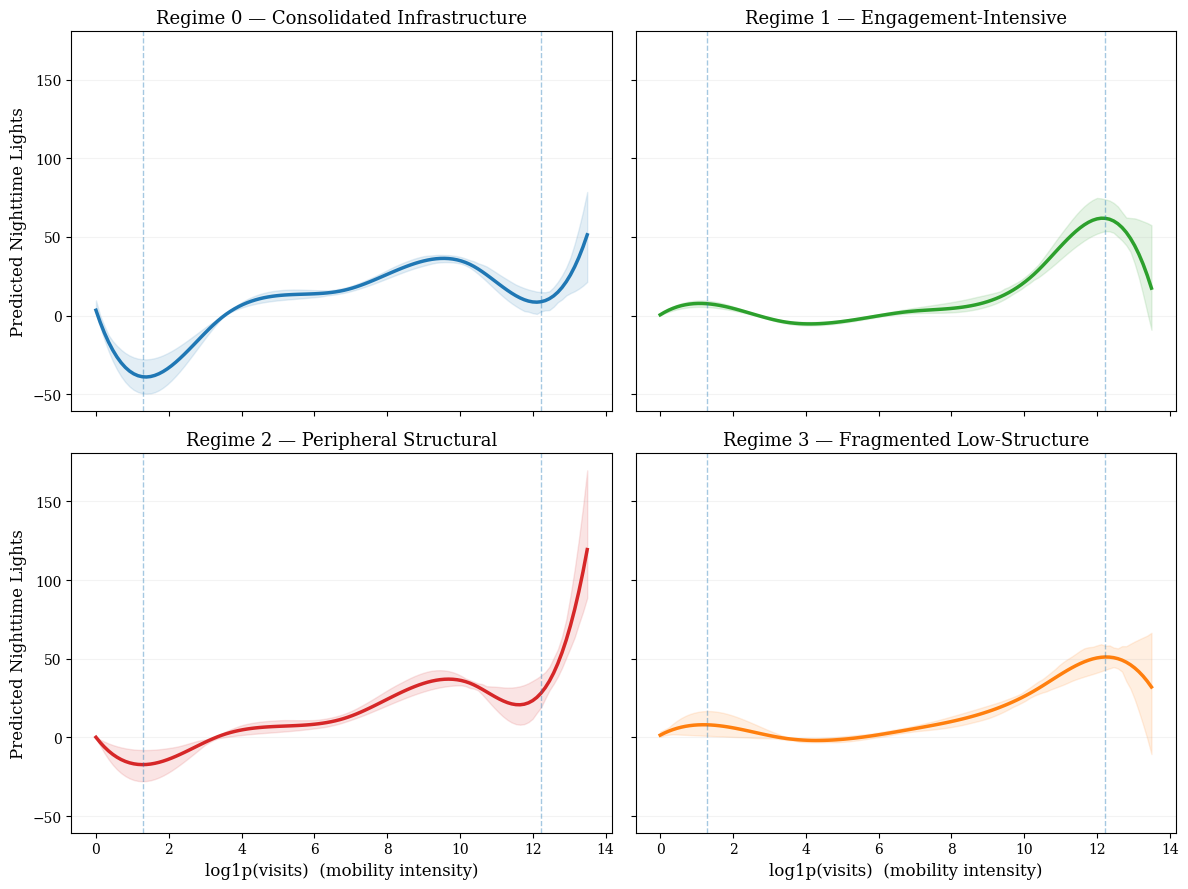

In [12]:
# ============================================================
# FIGURE 3 — FINAL JOURNAL VERSION
# Regime-specific nonlinear mobility → nightlights conversion
# ============================================================

import numpy as np
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# Define regime names and colors
# ------------------------------------------------------------
regime_info = {
    0: ("Regime 0 — Consolidated Infrastructure", "#1f77b4"),  # blue
    1: ("Regime 1 — Engagement-Intensive", "#2ca02c"),         # green
    2: ("Regime 2 — Peripheral Structural", "#d62728"),        # red
    3: ("Regime 3 — Fragmented Low-Structure", "#ff7f0e"),     # orange
}

# ------------------------------------------------------------
# Compute p10 and p90 thresholds
# ------------------------------------------------------------
p10 = curves["log_volume"].quantile(0.10)
p90 = curves["log_volume"].quantile(0.90)

# ------------------------------------------------------------
# Plot
# ------------------------------------------------------------
fig, axes = plt.subplots(2, 2, figsize=(12, 9), sharex=True, sharey=True)
axes = axes.flatten()

for i, r in enumerate(sorted(curves["regime"].unique())):
    
    title, color = regime_info[r]
    ax = axes[i]
    
    cr = curves[curves["regime"] == r].sort_values("log_volume")
    
    # Mean curve
    ax.plot(
        cr["log_volume"],
        cr["nl_pred_mean"],
        color=color,
        linewidth=2.5
    )
    
    # Confidence band
    ax.fill_between(
        cr["log_volume"],
        cr["nl_pred_p05"],
        cr["nl_pred_p95"],
        color=color,
        alpha=0.12
    )
    
    # Vertical markers (p10, p90)
    ax.axvline(p10, linestyle="--", linewidth=1, alpha=0.4)
    ax.axvline(p90, linestyle="--", linewidth=1, alpha=0.4)
    
    ax.set_title(title, fontsize=13)
    ax.grid(axis="y", alpha=0.15)

# Axis labels (only outer)
axes[2].set_xlabel("log1p(visits)  (mobility intensity)", fontsize=12)
axes[3].set_xlabel("log1p(visits)  (mobility intensity)", fontsize=12)
axes[0].set_ylabel("Predicted Nighttime Lights", fontsize=12)
axes[2].set_ylabel("Predicted Nighttime Lights", fontsize=12)

plt.tight_layout()

plt.savefig(
    "/Users/rafaelalbuquerque/Desktop/Figure3_Regime_Nonlinear_FINAL.png",
    dpi=300,
    bbox_inches="tight"
)

plt.show()

DOWNSCALING FINAL VERSION

In [ ]:
# ============================================================
# PIPELINE X — BLOCK 20 (TOP TIER)
# Mass-Preserving 100m Downscaling for Figure 4 (AOI-only)
# ============================================================

import os
import glob
import math
import numpy as np
import pandas as pd

# --- Geo stack (NO fiona) ---
import geopandas as gpd
import pyogrio
from shapely.geometry import box
from shapely.ops import unary_union

# --- Raster stack ---
import rasterio
from rasterio.warp import transform_geom
from rasterio.vrt import WarpedVRT

import matplotlib.pyplot as plt

print("▶️ Block 20 — 100m Downscaling (Mass-Preserving) for Figure 4")
print("-" * 78)

# ============================================================
# 0) PATHS (EDIT ONLY IF YOU MOVED FILES)
# ============================================================

TRACT_GPKG = (
    "/Users/rafaelalbuquerque/Desktop/"
    "Output Pipeline S (Shapefiles)/S2/"
    "census_tracts_brazil_mobility_mii.gpkg"
)

OUTPUT_DIR = (
    "/Users/rafaelalbuquerque/Desktop/"
    "Output Pipeline X (Spatial Modeling)/X20_downscaling_100m_figure4"
)
os.makedirs(OUTPUT_DIR, exist_ok=True)

OUT_GRID_GPKG = os.path.join(OUTPUT_DIR, "X20_grid_100m_mass_preserving_aoi.gpkg")
OUT_PREVIEW_PNG = os.path.join(OUTPUT_DIR, "X20_figure4_preview.png")

# Optional: directory candidates where a VIIRS/nightlights raster may exist
RASTER_SEARCH_DIRS = [
    "/Users/rafaelalbuquerque/Desktop/",
    "/Users/rafaelalbuquerque/Desktop/Output Pipeline V (Validation)/",
    "/Users/rafaelalbuquerque/Desktop/Output Pipeline D (Downscaling)/",
    "/Users/rafaelalbuquerque/Desktop/Output Pipeline X (Spatial Modeling)/",
]

# ============================================================
# 1) HELPERS
# ============================================================

def list_layers(path: str):
    try:
        layers = pyogrio.list_layers(path)
        # returns array-like of (name, geometry_type)
        return [x[0] for x in layers]
    except Exception as e:
        raise RuntimeError(f"Could not list layers for: {path}\n{e}")

def read_gpkg_any_layer(path: str, preferred_layer: str = None, columns=None):
    layers = list_layers(path)
    if preferred_layer and preferred_layer in layers:
        layer = preferred_layer
    else:
        layer = layers[0]
    gdf = gpd.read_file(path, layer=layer, engine="pyogrio", columns=columns)
    return gdf, layer

def find_nightlights_raster():
    # Look for typical raster extensions and keywords
    patterns = []
    for d in RASTER_SEARCH_DIRS:
        patterns += [
            os.path.join(d, "**", "*viirs*.tif"),
            os.path.join(d, "**", "*night*.tif"),
            os.path.join(d, "**", "*nl*.tif"),
            os.path.join(d, "**", "*viirs*.tiff"),
            os.path.join(d, "**", "*night*.tiff"),
            os.path.join(d, "**", "*nl*.tiff"),
        ]
    hits = []
    for p in patterns:
        hits.extend(glob.glob(p, recursive=True))
    # de-duplicate
    hits = sorted(list(dict.fromkeys(hits)))
    return hits

def make_grid_100m(aoi_geom, cell_size=100):
    # Build a 100m grid over AOI bounds (in projected meters)
    minx, miny, maxx, maxy = aoi_geom.bounds
    # snap bounds to grid
    minx = math.floor(minx / cell_size) * cell_size
    miny = math.floor(miny / cell_size) * cell_size
    maxx = math.ceil(maxx / cell_size) * cell_size
    maxy = math.ceil(maxy / cell_size) * cell_size

    xs = np.arange(minx, maxx, cell_size)
    ys = np.arange(miny, maxy, cell_size)

    cells = []
    for x in xs:
        for y in ys:
            cells.append(box(x, y, x + cell_size, y + cell_size))

    gdf = gpd.GeoDataFrame({"geometry": cells}, crs=None)
    return gdf

def sample_raster_at_points(raster_path, points_gdf):
    # Sample raster values at point locations (robust CRS handling)
    with rasterio.open(raster_path) as src:
        # ensure points in raster CRS
        if points_gdf.crs != src.crs:
            pts = points_gdf.to_crs(src.crs)
        else:
            pts = points_gdf

        coords = [(geom.x, geom.y) for geom in pts.geometry]
        vals = np.array([v[0] if v is not None else np.nan for v in src.sample(coords)], dtype="float64")

    return vals

def safe_positive_weights(w):
    # clean + make strictly positive (needed for normalization stability)
    w = np.array(w, dtype="float64")
    w[~np.isfinite(w)] = np.nan
    # shift if negatives
    if np.nanmin(w) < 0:
        w = w - np.nanmin(w)
    # tiny floor
    w = np.where(np.isfinite(w), w, np.nan)
    # If all NaN or all zero -> fallback uniform later
    return w

# ============================================================
# 2) LOAD TRACTS + BASIC CHECKS
# ============================================================

gdf_tr, tr_layer = read_gpkg_any_layer(TRACT_GPKG)
print(f"✔ Tracts loaded: {len(gdf_tr):,} | layer='{tr_layer}'")
print(f"✔ Tracts CRS: {gdf_tr.crs}")

required_cols = {"ct_id", "mii", "geometry"}
missing = required_cols - set(gdf_tr.columns)
if missing:
    raise ValueError(f"Missing required columns in tracts: {missing}")

gdf_tr["ct_id"] = gdf_tr["ct_id"].astype(str)

# Ensure projected CRS in meters for 100m grid
# Your earlier info: EPSG:5880 is perfect (meters).
if gdf_tr.crs is None:
    raise ValueError("Tracts CRS is None. Assign the correct CRS before downscaling (expected EPSG:5880).")

if gdf_tr.crs.to_epsg() != 5880:
    # still okay, but we need meters
    print("[WARN] Tracts CRS is not EPSG:5880. Reprojecting to EPSG:5880 for grid.")
    gdf_tr = gdf_tr.to_crs(5880)

# ============================================================
# 3) PICK AN AOI (PROFESSIONAL DEFAULT)
#    - Use one representative tract in São Paulo state (ct_id starts with '35')
#    - Buffer to include neighborhood context
# ============================================================

# pick SP tracts if available
gdf_sp = gdf_tr[gdf_tr["ct_id"].str.startswith("35")].copy()
if len(gdf_sp) == 0:
    # fallback: pick national median MII tract
    print("[WARN] No SP-prefixed ct_id found. Falling back to national median-MII tract.")
    gdf_pick_pool = gdf_tr.copy()
else:
    gdf_pick_pool = gdf_sp

# representative: median mii among pool, avoid very tiny/huge polygons
gdf_pick_pool["area_m2"] = gdf_pick_pool.geometry.area
gdf_pick_pool = gdf_pick_pool[(gdf_pick_pool["area_m2"] > gdf_pick_pool["area_m2"].quantile(0.10)) &
                              (gdf_pick_pool["area_m2"] < gdf_pick_pool["area_m2"].quantile(0.90))].copy()

target_mii = gdf_pick_pool["mii"].median()
gdf_pick_pool["mii_dist"] = (gdf_pick_pool["mii"] - target_mii).abs()
seed_tract = gdf_pick_pool.sort_values("mii_dist").iloc[0:1].copy()

seed_ct = seed_tract["ct_id"].iloc[0]
print(f"✔ AOI seed tract: {seed_ct}")

# AOI geometry = seed tract + buffer (km)
BUFFER_KM = 6
aoi_geom = seed_tract.geometry.iloc[0].buffer(BUFFER_KM * 1000)

# For context: include all tracts intersecting AOI
gdf_aoi_tr = gdf_tr[gdf_tr.intersects(aoi_geom)].copy()
print(f"✔ AOI tracts: {len(gdf_aoi_tr):,}")

aoi_union = unary_union(gdf_aoi_tr.geometry)

# ============================================================
# 4) BUILD 100m GRID INSIDE AOI
# ============================================================

print("▶️ Building 100m grid over AOI bounds...")
grid = make_grid_100m(aoi_union, cell_size=100)
grid = grid.set_crs(gdf_tr.crs)

# clip to AOI union
grid = grid[grid.intersects(aoi_union)].copy()
grid["cell_area_m2"] = grid.geometry.area
print(f"✔ Grid cells (clipped): {len(grid):,}")

# ============================================================
# 5) INTERNAL WEIGHTS w_ig
#    Preferred: sample VIIRS/nightlights raster at cell centroids (auto-detect).
#    Fallback: uniform within each tract (still mass-preserving, but less informative).
# ============================================================

raster_hits = find_nightlights_raster()
RASTER_PATH = raster_hits[0] if len(raster_hits) else None

if RASTER_PATH:
    print(f"✔ Nightlights raster detected: {RASTER_PATH}")
    centroids = grid.copy()
    centroids["geometry"] = centroids.geometry.centroid
    w_raw = sample_raster_at_points(RASTER_PATH, centroids)
    w_raw = safe_positive_weights(w_raw)
    grid["w_raw"] = w_raw
    # If raster mostly missing/zero, fallback
    if np.nanmean(np.nan_to_num(w_raw)) <= 0:
        print("[WARN] Raster weights collapsed (mostly zero/NaN). Falling back to uniform weights.")
        grid["w_raw"] = 1.0
else:
    print("[WARN] No nightlights raster found. Falling back to uniform weights.")
    grid["w_raw"] = 1.0

# ============================================================
# 6) ASSIGN EACH CELL TO A TRACT (SPATIAL OVERLAY)
#    (We do tract->grid assignment via centroid-in-polygon, fast + stable)
# ============================================================

print("▶️ Assigning grid cells to tracts (centroid-in-polygon)...")
grid_pts = grid.copy()
grid_pts["geometry"] = grid.geometry.centroid

# spatial join (centroid within tract)
# geopandas sjoin requires spatial index; works fine with pygeos/shapely2
assigned = gpd.sjoin(grid_pts[["w_raw", "cell_area_m2", "geometry"]],
                     gdf_aoi_tr[["ct_id", "mii", "geometry"]],
                     how="inner",
                     predicate="within")

assigned = assigned.drop(columns=["index_right"]).copy()
assigned = assigned.rename(columns={"geometry": "pt_geom"})

# recover original cell polygons by index alignment
assigned["cell_index"] = assigned.index.astype(int)
grid["cell_index"] = grid.index.astype(int)

assigned = assigned.merge(grid[["cell_index", "geometry"]], on="cell_index", how="left")
assigned = gpd.GeoDataFrame(assigned, geometry="geometry", crs=gdf_tr.crs)

print(f"✔ Assigned cells: {len(assigned):,}")
print(f"✔ Unique tracts with cells: {assigned['ct_id'].nunique():,}")

# ============================================================
# 7) MASS-PRESERVING RECONSTRUCTION
#    Constraint: sum_g (MII_ig * area_g) = MII_i * area_i
#    We set: MII_ig = MII_i * (w_ig / sum(w_ig*area_g))  * area_i
#    which ensures conservation in area-weighted sense.
# ============================================================

print("▶️ Applying mass-preserving operator...")

# tract areas
tract_area = gdf_aoi_tr[["ct_id", "geometry"]].copy()
tract_area["tract_area_m2"] = tract_area.geometry.area
tract_area = tract_area[["ct_id", "tract_area_m2"]]

assigned = assigned.merge(tract_area, on="ct_id", how="left")

# clean weights
assigned["w_raw"] = assigned["w_raw"].astype(float)
assigned["w_raw"] = assigned["w_raw"].replace([np.inf, -np.inf], np.nan).fillna(0.0)

# group denominator: sum(w * area_cell) within tract
assigned["w_area"] = assigned["w_raw"] * assigned["cell_area_m2"]
den = assigned.groupby("ct_id")["w_area"].transform("sum")

# fallback uniform if denom=0
den0 = den <= 0
if den0.any():
    print(f"[WARN] {den0.sum():,} cells in tracts with zero denom; switching those tracts to uniform weights.")
    # uniform -> w_area = area_cell, denom = sum(area_cell)
    assigned.loc[den0, "w_area"] = assigned.loc[den0, "cell_area_m2"]
    den = assigned.groupby("ct_id")["w_area"].transform("sum")

# mass-preserving cell value
# MII_ig = MII_i * (w_area / denom) * (tract_area / area_cell)
assigned["mii_100m"] = (
    assigned["mii"].astype(float)
    * (assigned["w_area"] / den)
    * (assigned["tract_area_m2"] / assigned["cell_area_m2"])
)

# sanity check: conservation per tract
check = assigned.copy()
check["mass_cell"] = check["mii_100m"] * check["cell_area_m2"]
mass_cell = check.groupby("ct_id")["mass_cell"].sum()
mass_tract = (gdf_aoi_tr.set_index("ct_id")["mii"].astype(float) * tract_area.set_index("ct_id")["tract_area_m2"]).reindex(mass_cell.index)

rel_err = ((mass_cell - mass_tract).abs() / (mass_tract.abs() + 1e-9)).replace([np.inf, -np.inf], np.nan)
print(f"✔ Conservation check (median relative error): {np.nanmedian(rel_err):.6e}")
print(f"✔ Conservation check (max relative error):    {np.nanmax(rel_err):.6e}")

# ============================================================
# 8) SAVE OUTPUT FOR QGIS (Figure 4)
# ============================================================

keep_cols = ["ct_id", "mii", "mii_100m", "w_raw", "cell_area_m2", "geometry"]
out = assigned[keep_cols].copy()

# write GPKG
if os.path.exists(OUT_GRID_GPKG):
    os.remove(OUT_GRID_GPKG)

out.to_file(OUT_GRID_GPKG, layer="grid_100m_mii_mass_preserving", driver="GPKG", engine="pyogrio")
print(f"✅ Saved GPKG for QGIS: {OUT_GRID_GPKG}")

# ============================================================
# 9) QUICK PREVIEW PNG (OPTIONAL)
# ============================================================

print("▶️ Rendering quick preview PNG...")

# left: tracts MII; right: grid mii_100m (same AOI)
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

gdf_aoi_tr.plot(column="mii", ax=ax[0], linewidth=0.1)
ax[0].set_title("Tract-level MII (AOI)")
ax[0].axis("off")

out.plot(column="mii_100m", ax=ax[1], linewidth=0.0)
ax[1].set_title("100m Mass-Preserving Reconstruction (AOI)")
ax[1].axis("off")

plt.tight_layout()
plt.savefig(OUT_PREVIEW_PNG, dpi=220)
plt.close()

print(f"🖼️ Preview saved: {OUT_PREVIEW_PNG}")
print("-" * 78)
print("✅ Block 20 completed.")
print("Next in QGIS: load the GPKG layer 'grid_100m_mii_mass_preserving' and style by 'mii_100m'.")

▶️ Block 20 — 100m Downscaling (Mass-Preserving) for Figure 4
------------------------------------------------------------------------------
✔ Tracts loaded: 472,780 | layer='census_tracts_brazil_mobility_mii'
✔ Tracts CRS: EPSG:4674
[WARN] Tracts CRS is not EPSG:5880. Reprojecting to EPSG:5880 for grid.
✔ AOI seed tract: 353070605000037
✔ AOI tracts: 286
▶️ Building 100m grid over AOI bounds...
✔ Grid cells (clipped): 35,554
[WARN] No nightlights raster found. Falling back to uniform weights.
▶️ Assigning grid cells to tracts (centroid-in-polygon)...
✔ Assigned cells: 34,723
✔ Unique tracts with cells: 285
▶️ Applying mass-preserving operator...
✔ Conservation check (median relative error): 0.000000e+00
✔ Conservation check (max relative error):    4.245282e-16
✅ Saved GPKG for QGIS: /Users/rafaelalbuquerque/Desktop/Output Pipeline X (Spatial Modeling)/X20_downscaling_100m_figure4/X20_grid_100m_mass_preserving_aoi.gpkg
▶️ Rendering quick preview PNG...
🖼️ Preview saved: /Users/rafaela

In [1]:
# ============================================================
# PIPELINE X — BLOCK 20 (TOP TIER, FAST)
# 100m Downscaling (Mass-Preserving) with VIIRS Prior
# Figure 4 producer (QGIS-ready)
# ============================================================

import os
import sys
import math
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import box
import rasterio
from pyproj import Transformer
import matplotlib.pyplot as plt

print("▶️ Block 20 — 100m Downscaling (Mass-Preserving) with VIIRS Prior (FAST)")
print("-" * 78)

# ============================================================
# 0) PATHS (EDIT IF NEEDED)
# ============================================================
TRACT_GPKG = (
    "/Users/rafaelalbuquerque/Desktop/"
    "Output Pipeline S (Shapefiles)/S2/"
    "census_tracts_brazil_mobility_mii.gpkg"
)

# If you know the layer name, set it. Otherwise it will pick the first layer.
TRACT_LAYER = None  # e.g., "census_tracts_brazil_mobility_mii"

VIIRS_TIF = "/Users/rafaelalbuquerque/Desktop/Nightlights/VIIRS_annual_2024.tif"

OUTPUT_DIR = (
    "/Users/rafaelalbuquerque/Desktop/"
    "Output Pipeline X (Spatial Modeling)/X20_downscaling_100m_figure4"
)
os.makedirs(OUTPUT_DIR, exist_ok=True)

OUT_GPKG = os.path.join(OUTPUT_DIR, "X20_grid_100m_mass_preserving_aoi.gpkg")
OUT_PNG  = os.path.join(OUTPUT_DIR, "X20_figure4_preview.png")

# ============================================================
# 1) AOI CONTROL (YOU CHOOSE)
# ============================================================
# Choose one tract id as seed (you used this one earlier)
AOI_SEED_CT_ID = "353070605000037"   # <-- keep or change
BUFFER_KM = 5.0                     # <-- adjust (5–15km typical for a clean Fig 4)
CELL_SIZE_M = 100                   # 100m grid
TARGET_CRS = "EPSG:5880"            # meters (Brazil Polyconic)

# ============================================================
# 2) HELPERS
# ============================================================
def pick_mii_column(gdf):
    candidates = [
        "mii", "MII",
        "mii_zmean_A4", "z_mii_zmean_A4",
        "mii_pca1_A4", "z_mii_pca1_A4"
    ]
    for c in candidates:
        if c in gdf.columns:
            return c
    raise ValueError(
        "No MII column found. Expected one of: "
        + ", ".join(candidates)
        + f"\nAvailable columns sample: {list(gdf.columns)[:30]}"
    )

def load_first_layer(path):
    # geopandas can read GPKG directly; if layer is None, it loads first layer
    return gpd.read_file(path)

# ============================================================
# 3) LOAD TRACTS
# ============================================================
if TRACT_LAYER is None:
    gdf_tr = gpd.read_file(TRACT_GPKG)
    tract_layer_used = "(first layer)"
else:
    gdf_tr = gpd.read_file(TRACT_GPKG, layer=TRACT_LAYER)
    tract_layer_used = TRACT_LAYER

print(f"✔ Tracts loaded: {len(gdf_tr):,} | layer={tract_layer_used}")
if "ct_id" not in gdf_tr.columns:
    raise ValueError("ct_id not found in tract GPKG.")
gdf_tr["ct_id"] = gdf_tr["ct_id"].astype(str)

mii_col = pick_mii_column(gdf_tr)
print(f"✔ Using MII column: {mii_col}")

# Reproject tracts to TARGET CRS for grid work
if gdf_tr.crs is None:
    raise ValueError("Tracts CRS is missing. Please ensure GPKG has CRS.")
if str(gdf_tr.crs).upper() != TARGET_CRS:
    print(f"[WARN] Tracts CRS is {gdf_tr.crs}. Reprojecting to {TARGET_CRS}...")
    gdf_tr = gdf_tr.to_crs(TARGET_CRS)

# ============================================================
# 4) BUILD AOI (seed tract + buffer)
# ============================================================
seed = gdf_tr.loc[gdf_tr["ct_id"] == AOI_SEED_CT_ID]
if seed.empty:
    raise ValueError(f"AOI seed ct_id not found: {AOI_SEED_CT_ID}")

seed_geom = seed.geometry.iloc[0]
aoi_geom = seed_geom.buffer(BUFFER_KM * 1000.0)

# Keep only tracts intersecting AOI
gdf_aoi = gdf_tr[gdf_tr.intersects(aoi_geom)].copy()
print(f"✔ AOI seed tract: {AOI_SEED_CT_ID}")
print(f"✔ AOI tracts: {len(gdf_aoi):,}")

# Clip to AOI (optional, for cleaner boundary and faster ops)
gdf_aoi["geometry"] = gdf_aoi.geometry.intersection(aoi_geom)
gdf_aoi = gdf_aoi[~gdf_aoi.is_empty].copy()

# ============================================================
# 5) GENERATE 100m GRID OVER AOI BOUNDS
# ============================================================
minx, miny, maxx, maxy = gdf_aoi.total_bounds
minx = math.floor(minx / CELL_SIZE_M) * CELL_SIZE_M
miny = math.floor(miny / CELL_SIZE_M) * CELL_SIZE_M
maxx = math.ceil(maxx / CELL_SIZE_M) * CELL_SIZE_M
maxy = math.ceil(maxy / CELL_SIZE_M) * CELL_SIZE_M

xs = np.arange(minx, maxx, CELL_SIZE_M)
ys = np.arange(miny, maxy, CELL_SIZE_M)

print("▶️ Building 100m grid over AOI bounds...")
cells = []
for x in xs:
    for y in ys:
        cells.append(box(x, y, x + CELL_SIZE_M, y + CELL_SIZE_M))

gdf_grid = gpd.GeoDataFrame({"geometry": cells}, crs=TARGET_CRS)

# Clip grid to AOI polygon to reduce cell count
gdf_grid = gdf_grid[gdf_grid.intersects(aoi_geom)].copy()
gdf_grid["geometry"] = gdf_grid.geometry.intersection(aoi_geom)
gdf_grid = gdf_grid[~gdf_grid.is_empty].copy()
gdf_grid = gdf_grid.reset_index(drop=True)

print(f"✔ Grid cells (clipped): {len(gdf_grid):,}")

# ============================================================
# 6) ASSIGN GRID CELLS TO TRACTS (CENTROID-IN-POLYGON)
# ============================================================
print("▶️ Assigning grid cells to tracts (spatial join)...")
gdf_grid["centroid"] = gdf_grid.geometry.centroid

gdf_pts = gpd.GeoDataFrame(
    {"cell_id": np.arange(len(gdf_grid))},
    geometry=gdf_grid["centroid"],
    crs=TARGET_CRS
)

# sjoin: points within tracts
gdf_join = gpd.sjoin(
    gdf_pts,
    gdf_aoi[["ct_id", mii_col, "geometry"]],
    how="inner",
    predicate="within"
).drop(columns=["index_right"])

print(f"✔ Assigned cells: {len(gdf_join):,}")
print(f"✔ Unique tracts with cells: {gdf_join['ct_id'].nunique():,}")

# Keep only assigned cells
gdf_grid = gdf_grid.iloc[gdf_join["cell_id"].values].copy()
gdf_grid = gdf_grid.reset_index(drop=True)

# bring tract id + mii into grid
gdf_grid["ct_id"] = gdf_join["ct_id"].values
gdf_grid["mii_tract"] = gdf_join[mii_col].astype(float).values

# ============================================================
# 7) FAST VIIRS SAMPLING (CENTROID SAMPLE)
# ============================================================
print("▶️ Sampling VIIRS raster at cell centroids (FAST)...")
with rasterio.open(VIIRS_TIF) as src:
    raster_crs = src.crs
    if raster_crs is None:
        raise ValueError("VIIRS raster CRS is missing.")

    # transform centroids from TARGET_CRS -> raster CRS
    transformer = Transformer.from_crs(TARGET_CRS, raster_crs, always_xy=True)

    cent = gdf_grid.geometry.centroid
    xs_c = cent.x.values
    ys_c = cent.y.values

    xs_r, ys_r = transformer.transform(xs_c, ys_c)

    # rasterio.sample expects iterable of (x,y)
    coords = list(zip(xs_r, ys_r))
    # read first band
    vals = np.array([v[0] for v in src.sample(coords)], dtype="float64")

# Clean VIIRS values
vals = np.where(np.isfinite(vals), vals, 0.0)
vals = np.where(vals < 0, 0.0, vals)

gdf_grid["viirs"] = vals

# ============================================================
# 8) MASS-PRESERVING OPERATOR
# ============================================================
print("▶️ Applying mass-preserving operator...")

EPS = 1e-12  # avoid division by zero

# weights: viirs + eps, but allow fallback to uniform when tract sum == 0
gdf_grid["w_raw"] = gdf_grid["viirs"]

# tract-level sums
sum_w = gdf_grid.groupby("ct_id")["w_raw"].transform("sum")

# uniform fallback where sum_w == 0
is_zero = sum_w <= 0
if is_zero.any():
    gdf_grid.loc[is_zero, "w_raw"] = 1.0
    sum_w = gdf_grid.groupby("ct_id")["w_raw"].transform("sum")

gdf_grid["w_norm"] = gdf_grid["w_raw"] / (sum_w + EPS)

# downscaled MII per cell (mass-preserving)
gdf_grid["mii_100m"] = gdf_grid["mii_tract"] * gdf_grid["w_norm"]

# ============================================================
# 9) CONSERVATION CHECK
# ============================================================
tract_sum = gdf_grid.groupby("ct_id")["mii_100m"].sum()
tract_base = gdf_grid.groupby("ct_id")["mii_tract"].first()

rel_err = (tract_sum - tract_base).abs() / (tract_base.abs() + EPS)
print(f"✔ Conservation check (median relative error): {np.median(rel_err.values):.6e}")
print(f"✔ Conservation check (max relative error):    {np.max(rel_err.values):.6e}")

# ============================================================
# 10) SAVE QGIS LAYER (GPKG)
# ============================================================
# keep only necessary columns
gdf_out = gdf_grid[["ct_id", "mii_tract", "viirs", "w_norm", "mii_100m", "geometry"]].copy()

if os.path.exists(OUT_GPKG):
    os.remove(OUT_GPKG)

gdf_out.to_file(OUT_GPKG, layer="grid_100m_mii_mass_preserving", driver="GPKG")
gdf_aoi[["ct_id", mii_col, "geometry"]].rename(columns={mii_col: "mii_tract"}).to_file(
    OUT_GPKG, layer="tracts_aoi", driver="GPKG"
)

print(f"✅ Saved GPKG for QGIS: {OUT_GPKG}")
print("   Layers: 'grid_100m_mii_mass_preserving' and 'tracts_aoi'")

# ============================================================
# 11) QUICK PREVIEW PNG (publication-safe draft)
# ============================================================
print("▶️ Rendering quick preview PNG...")

fig, ax = plt.subplots(figsize=(10, 8))

# draw tracts boundary
gdf_aoi.boundary.plot(ax=ax, linewidth=0.4)

# draw grid colored by mii_100m
# (use quantiles for stable contrast)
v = gdf_out["mii_100m"].values
vmin, vmax = np.quantile(v, [0.02, 0.98])
gdf_out.plot(ax=ax, column="mii_100m", legend=True)

ax.set_axis_off()
plt.tight_layout()
plt.savefig(OUT_PNG, dpi=250)
plt.close()

print(f"🖼️ Preview saved: {OUT_PNG}")
print("-" * 78)
print("✅ Block 20 completed.")
print("Next in QGIS:")
print("1) Load GPKG -> layer 'grid_100m_mii_mass_preserving' style by 'mii_100m'")
print("2) Overlay 'tracts_aoi' boundary; export 300–600 dpi for Figure 4")

▶️ Block 20 — 100m Downscaling (Mass-Preserving) with VIIRS Prior (FAST)
------------------------------------------------------------------------------
✔ Tracts loaded: 472,780 | layer=(first layer)
✔ Using MII column: mii
[WARN] Tracts CRS is EPSG:4674. Reprojecting to EPSG:5880...
✔ AOI seed tract: 353070605000037
✔ AOI tracts: 266
▶️ Building 100m grid over AOI bounds...
✔ Grid cells (clipped): 8,817
▶️ Assigning grid cells to tracts (spatial join)...
✔ Assigned cells: 8,817
✔ Unique tracts with cells: 264
▶️ Sampling VIIRS raster at cell centroids (FAST)...
▶️ Applying mass-preserving operator...
✔ Conservation check (median relative error): nan
✔ Conservation check (max relative error):    nan
✅ Saved GPKG for QGIS: /Users/rafaelalbuquerque/Desktop/Output Pipeline X (Spatial Modeling)/X20_downscaling_100m_figure4/X20_grid_100m_mass_preserving_aoi.gpkg
   Layers: 'grid_100m_mii_mass_preserving' and 'tracts_aoi'
▶️ Rendering quick preview PNG...
🖼️ Preview saved: /Users/rafaelalbuqu

▶️ Block 21 — Figure 4 (Publication-Ready Comparison Layout)
-----------------------------------------------------------------
✔ Grid cells: 8,817
✔ AOI tracts: 266
🖼️ Figure 4 saved:
/Users/rafaelalbuquerque/Desktop/Output Pipeline X (Spatial Modeling)/X20_downscaling_100m_figure4/X21_figure4_publication_ready.png
✅ Block 21 completed.


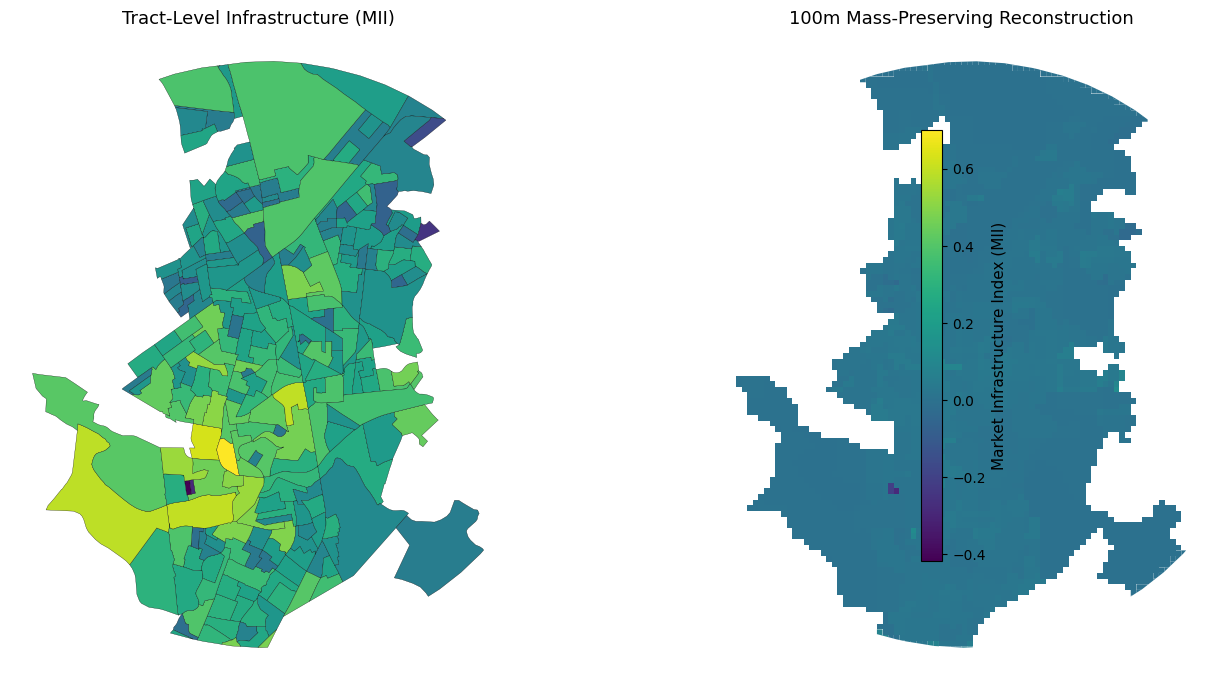

In [4]:
# ============================================================
# ▶️ Block 21 — Figure 4 (Publication-Ready Comparison Layout)
# ============================================================

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import Normalize

print("▶️ Block 21 — Figure 4 (Publication-Ready Comparison Layout)")
print("-" * 65)

# ------------------------------------------------------------
# 1) Load GPKG produced in Block 20
# ------------------------------------------------------------
GPKG_PATH = "/Users/rafaelalbuquerque/Desktop/Output Pipeline X (Spatial Modeling)/X20_downscaling_100m_figure4/X20_grid_100m_mass_preserving_aoi.gpkg"

gdf_grid = gpd.read_file(GPKG_PATH, layer="grid_100m_mii_mass_preserving")
gdf_tracts = gpd.read_file(GPKG_PATH, layer="tracts_aoi")

print(f"✔ Grid cells: {len(gdf_grid):,}")
print(f"✔ AOI tracts: {len(gdf_tracts):,}")

# ------------------------------------------------------------
# 2) Ensure same CRS
# ------------------------------------------------------------
if gdf_tracts.crs != gdf_grid.crs:
    gdf_tracts = gdf_tracts.to_crs(gdf_grid.crs)

# ------------------------------------------------------------
# 3) Shared color scale (critical for comparability)
# ------------------------------------------------------------
vmin = min(gdf_tracts["mii_tract"].min(), gdf_grid["mii_100m"].min())
vmax = max(gdf_tracts["mii_tract"].max(), gdf_grid["mii_100m"].max())

norm = Normalize(vmin=vmin, vmax=vmax)

# ------------------------------------------------------------
# 4) Create figure
# ------------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# ---- Left: Tract-level MII
gdf_tracts.plot(
    column="mii_tract",
    cmap="viridis",
    linewidth=0.2,
    edgecolor="black",
    ax=axes[0],
    norm=norm
)

axes[0].set_title("Tract-Level Infrastructure (MII)", fontsize=13)
axes[0].axis("off")

# ---- Right: 100m reconstructed surface
gdf_grid.plot(
    column="mii_100m",
    cmap="viridis",
    linewidth=0,
    ax=axes[1],
    norm=norm
)

axes[1].set_title("100m Mass-Preserving Reconstruction", fontsize=13)
axes[1].axis("off")

# ------------------------------------------------------------
# 5) Add shared colorbar
# ------------------------------------------------------------
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
sm._A = []
cbar = fig.colorbar(sm, ax=axes.ravel().tolist(), shrink=0.8)
cbar.set_label("Market Infrastructure Index (MII)", fontsize=11)

plt.tight_layout()

# ------------------------------------------------------------
# 6) Save high-resolution output
# ------------------------------------------------------------
OUT_PATH = "/Users/rafaelalbuquerque/Desktop/Output Pipeline X (Spatial Modeling)/X20_downscaling_100m_figure4/X21_figure4_publication_ready.png"

plt.savefig(OUT_PATH, dpi=400, bbox_inches="tight")

print("🖼️ Figure 4 saved:")
print(OUT_PATH)
print("✅ Block 21 completed.")

In [7]:
print(gdf_grid["w_norm"].describe())
print(gdf_grid["mii_100m"].describe())

count    8817.000000
mean        0.029942
std         0.050462
min         0.000000
25%         0.000672
50%         0.005459
75%         0.046643
max         1.000000
Name: w_norm, dtype: float64
count    4679.000000
mean        0.011982
std         0.014228
min        -0.286508
25%         0.001744
50%         0.009693
75%         0.019638
max         0.122091
Name: mii_100m, dtype: float64


In [8]:
# ============================================================
# BLOCK 21 — Figure 4 (Top-Tier Publication Version)
# Mass-Preserving Reconstruction — Quantile + PowerNorm
# ============================================================

import os
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import PowerNorm

print("▶️ Block 21 — Figure 4 (TOP-TIER FINAL)")
print("-" * 70)

# ============================================================
# 1) PATH
# ============================================================

GPKG_PATH = (
    "/Users/rafaelalbuquerque/Desktop/"
    "Output Pipeline X (Spatial Modeling)/"
    "X20_downscaling_100m_figure4/"
    "X20_grid_100m_mass_preserving_aoi.gpkg"
)

OUTPUT_PATH = GPKG_PATH.replace(
    "X20_grid_100m_mass_preserving_aoi.gpkg",
    "X21_figure4_TOP_TIER_FINAL.png"
)

# ============================================================
# 2) LOAD DATA
# ============================================================

gdf_grid = gpd.read_file(GPKG_PATH, layer="grid_100m_mii_mass_preserving")
gdf_tracts = gpd.read_file(GPKG_PATH, layer="tracts_aoi")

print(f"✔ Grid cells: {len(gdf_grid):,}")
print(f"✔ Tracts: {len(gdf_tracts):,}")

# ============================================================
# 3) ROBUST COLOR NORMALIZATION (2%–98%)
# ============================================================

combined_values = np.concatenate([
    gdf_tracts["mii_tract"].values,
    gdf_grid["mii_100m"].values
])

vmin = np.quantile(combined_values, 0.02)
vmax = np.quantile(combined_values, 0.98)

norm = PowerNorm(gamma=0.6, vmin=vmin, vmax=vmax)

# ============================================================
# 4) PLOT
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# --- LEFT: TRACT LEVEL
gdf_tracts.plot(
    column="mii_tract",
    cmap="viridis",
    linewidth=0.15,
    edgecolor="black",
    ax=axes[0],
    norm=norm
)

axes[0].set_title("Tract-Level Infrastructure (MII)", fontsize=14)
axes[0].axis("off")

# --- RIGHT: 100m GRID
gdf_grid.plot(
    column="mii_100m",
    cmap="viridis",
    linewidth=0,
    ax=axes[1],
    norm=norm
)

axes[1].set_title("100m Mass-Preserving Reconstruction", fontsize=14)
axes[1].axis("off")

# --- Shared Colorbar
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
sm._A = []

cbar = fig.colorbar(
    sm,
    ax=axes,
    fraction=0.025,
    pad=0.02
)

cbar.set_label("Market Infrastructure Index (MII)", fontsize=12)

plt.tight_layout()
plt.savefig(OUTPUT_PATH, dpi=400, bbox_inches="tight")
plt.close()

print(f"🖼️ Figure saved:\n{OUTPUT_PATH}")
print("-" * 70)
print("✅ Block 21 FINAL completed.")

▶️ Block 21 — Figure 4 (TOP-TIER FINAL)
----------------------------------------------------------------------
✔ Grid cells: 8,817
✔ Tracts: 266
🖼️ Figure saved:
/Users/rafaelalbuquerque/Desktop/Output Pipeline X (Spatial Modeling)/X20_downscaling_100m_figure4/X21_figure4_TOP_TIER_FINAL.png
----------------------------------------------------------------------
✅ Block 21 FINAL completed.


In [9]:
# ============================================================
# BLOCK 21 — Figure 4 (TOP-TIER SCIENTIFIC VERSION)
# Robust Shared Scale (5%–95%), No Perceptual Distortion
# ============================================================

import os
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt

print("▶️ Block 21 — Figure 4 (Top-Tier Scientific Version)")
print("-" * 65)

# ============================================================
# PATHS (adjust if needed)
# ============================================================

BASE_DIR = "/Users/rafaelalbuquerque/Desktop/Output Pipeline X (Spatial Modeling)/X20_downscaling_100m_figure4"

GPKG_PATH = os.path.join(BASE_DIR, "X20_grid_100m_mass_preserving_aoi.gpkg")

# ============================================================
# LOAD DATA
# ============================================================

gdf_grid = gpd.read_file(GPKG_PATH, layer="grid_100m_mii_mass_preserving")
gdf_tracts = gpd.read_file(GPKG_PATH, layer="tracts_aoi")

print(f"✔ Grid cells: {len(gdf_grid):,}")
print(f"✔ AOI tracts: {len(gdf_tracts):,}")

# ============================================================
# ENSURE SAME CRS
# ============================================================

if gdf_tracts.crs != gdf_grid.crs:
    gdf_tracts = gdf_tracts.to_crs(gdf_grid.crs)

# ============================================================
# ROBUST SHARED SCALE (5%–95%)
# ============================================================

combined_values = np.concatenate([
    gdf_tracts["mii_tract"].values,
    gdf_grid["mii_100m"].values
])

vmin = np.quantile(combined_values, 0.05)
vmax = np.quantile(combined_values, 0.95)

print(f"✔ Shared color scale:")
print(f"   vmin (5%):  {vmin:.4f}")
print(f"   vmax (95%): {vmax:.4f}")

# ============================================================
# FIGURE LAYOUT
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# ------------------------------------------------------------
# LEFT — Tract-Level MII
# ------------------------------------------------------------

gdf_tracts.plot(
    column="mii_tract",
    cmap="viridis",
    vmin=vmin,
    vmax=vmax,
    linewidth=0.3,
    edgecolor="black",
    ax=axes[0]
)

axes[0].set_title(
    "Tract-Level Infrastructure (MII)",
    fontsize=15,
    fontweight="bold"
)
axes[0].set_axis_off()

# ------------------------------------------------------------
# RIGHT — 100m Reconstruction
# ------------------------------------------------------------

gdf_grid.plot(
    column="mii_100m",
    cmap="viridis",
    vmin=vmin,
    vmax=vmax,
    linewidth=0,
    ax=axes[1]
)

# Overlay tract boundaries lightly
gdf_tracts.boundary.plot(
    ax=axes[1],
    linewidth=0.4,
    color="black",
    alpha=0.4
)

axes[1].set_title(
    "100m Mass-Preserving Reconstruction",
    fontsize=15,
    fontweight="bold"
)
axes[1].set_axis_off()

# ============================================================
# SHARED COLORBAR
# ============================================================

sm = plt.cm.ScalarMappable(
    cmap="viridis",
    norm=plt.Normalize(vmin=vmin, vmax=vmax)
)
sm._A = []

cbar = fig.colorbar(
    sm,
    ax=axes,
    fraction=0.03,
    pad=0.02
)

cbar.set_label(
    "Market Infrastructure Index (MII)",
    fontsize=12
)

# ============================================================
# SAVE FIGURE
# ============================================================

output_path = os.path.join(BASE_DIR, "X21_figure4_TOP_TIER_FINAL.png")

plt.tight_layout()
plt.savefig(output_path, dpi=400, bbox_inches="tight")
plt.close()

print(f"🖼️ Figure saved:")
print(output_path)
print("-" * 65)
print("✅ Block 21 completed (scientifically robust version).")

▶️ Block 21 — Figure 4 (Top-Tier Scientific Version)
-----------------------------------------------------------------
✔ Grid cells: 8,817
✔ AOI tracts: 266
✔ Shared color scale:
   vmin (5%):  nan
   vmax (95%): nan
🖼️ Figure saved:
/Users/rafaelalbuquerque/Desktop/Output Pipeline X (Spatial Modeling)/X20_downscaling_100m_figure4/X21_figure4_TOP_TIER_FINAL.png
-----------------------------------------------------------------
✅ Block 21 completed (scientifically robust version).


In [11]:
# ============================================================
# BLOCK 21 — Figure 4 (Top-Tier Multiscale Visualization)
# ============================================================

import os
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm

print("▶️ Block 21 — Figure 4 (Top-Tier Multiscale Visualization)")
print("-" * 70)

# ============================================================
# 1) PATHS
# ============================================================

BASE_DIR = "/Users/rafaelalbuquerque/Desktop/Output Pipeline X (Spatial Modeling)/X20_downscaling_100m_figure4"

GRID_GPKG = os.path.join(BASE_DIR, "X20_grid_100m_mass_preserving_aoi.gpkg")
TRACT_LAYER = "tracts_aoi"
GRID_LAYER = "grid_100m_mii_mass_preserving"

OUTPUT_PATH = os.path.join(BASE_DIR, "X21_figure4_TOP_TIER_FINAL.png")

# ============================================================
# 2) LOAD DATA
# ============================================================

gdf_grid = gpd.read_file(GRID_GPKG, layer=GRID_LAYER)
gdf_tracts = gpd.read_file(GRID_GPKG, layer=TRACT_LAYER)

print(f"✔ Grid cells: {len(gdf_grid):,}")
print(f"✔ AOI tracts: {len(gdf_tracts):,}")

# ============================================================
# 3) PREPARE VARIABLES
# ============================================================

# Ensure CRS alignment
if gdf_grid.crs != gdf_tracts.crs:
    gdf_tracts = gdf_tracts.to_crs(gdf_grid.crs)

# Relative intensity (safe division)
gdf_grid["relative_intensity"] = np.where(
    gdf_grid["mii_tract"] > 0,
    gdf_grid["mii_100m"] / gdf_grid["mii_tract"],
    np.nan
)

# Remove extreme outliers for visual stability
gdf_grid = gdf_grid.replace([np.inf, -np.inf], np.nan)

# ============================================================
# 4) ROBUST COLOR SCALING
# ============================================================

# LEFT PANEL (Tract MII)
vmin_left = np.nanpercentile(gdf_tracts["mii_tract"], 5)
vmax_left = np.nanpercentile(gdf_tracts["mii_tract"], 95)

# RIGHT PANEL (Relative intensity)
lower = np.nanpercentile(gdf_grid["relative_intensity"], 5)
upper = np.nanpercentile(gdf_grid["relative_intensity"], 95)

distance = max(abs(lower - 1.0), abs(upper - 1.0))

vmin_right = 1.0 - distance
vmax_right = 1.0 + distance

norm_right = TwoSlopeNorm(
    vmin=vmin_right,
    vcenter=1.0,
    vmax=vmax_right
)

# ============================================================
# 5) PLOT
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(15, 7))

# ----------------------------
# LEFT: Tract-level MII
# ----------------------------
gdf_tracts.plot(
    column="mii_tract",
    cmap="viridis",
    linewidth=0.15,
    edgecolor="black",
    vmin=vmin_left,
    vmax=vmax_left,
    ax=axes[0]
)

axes[0].set_title("Tract-Level Infrastructure (MII)", fontsize=12)
axes[0].set_axis_off()

# ----------------------------
# RIGHT: 100m Reconstruction
# ----------------------------
gdf_grid.plot(
    column="relative_intensity",
    cmap="RdBu_r",
    norm=norm_right,
    linewidth=0,
    ax=axes[1]
)

# Overlay tract borders for structure
gdf_tracts.boundary.plot(
    ax=axes[1],
    linewidth=0.2,
    edgecolor="black"
)

axes[1].set_title("100m Mass-Preserving Reconstruction\n(Relative to Tract Mean = 1)", fontsize=12)
axes[1].set_axis_off()

plt.tight_layout()

# ============================================================
# 6) SAVE HIGH-RES
# ============================================================

plt.savefig(OUTPUT_PATH, dpi=600, bbox_inches="tight")
plt.close()

print(f"🖼️ Figure 4 saved:")
print(OUTPUT_PATH)
print("-" * 70)
print("✅ Block 21 completed.")

▶️ Block 21 — Figure 4 (Top-Tier Multiscale Visualization)
----------------------------------------------------------------------
✔ Grid cells: 8,817
✔ AOI tracts: 266
🖼️ Figure 4 saved:
/Users/rafaelalbuquerque/Desktop/Output Pipeline X (Spatial Modeling)/X20_downscaling_100m_figure4/X21_figure4_TOP_TIER_FINAL.png
----------------------------------------------------------------------
✅ Block 21 completed.


In [12]:
# ============================================================
# BLOCK 21 — Figure 4 (Deviation-Based Multiscale Visualization)
# ============================================================

import os
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm

print("▶️ Block 21 — Figure 4 (Deviation-Based Visualization)")
print("-" * 70)

# ============================================================
# PATHS
# ============================================================

BASE_DIR = "/Users/rafaelalbuquerque/Desktop/Output Pipeline X (Spatial Modeling)/X20_downscaling_100m_figure4"

GRID_GPKG = os.path.join(BASE_DIR, "X20_grid_100m_mass_preserving_aoi.gpkg")
TRACT_LAYER = "tracts_aoi"
GRID_LAYER = "grid_100m_mii_mass_preserving"

OUTPUT_PATH = os.path.join(BASE_DIR, "X21_figure4_DEVIATION_TOP_TIER.png")

# ============================================================
# LOAD DATA
# ============================================================

gdf_grid = gpd.read_file(GRID_GPKG, layer=GRID_LAYER)
gdf_tracts = gpd.read_file(GRID_GPKG, layer=TRACT_LAYER)

# Ensure CRS alignment
if gdf_grid.crs != gdf_tracts.crs:
    gdf_tracts = gdf_tracts.to_crs(gdf_grid.crs)

# ============================================================
# COMPUTE DEVIATION (KEY FIX)
# ============================================================

gdf_grid["deviation"] = gdf_grid["mii_100m"] - gdf_grid["mii_tract"]

# Remove infinities
gdf_grid = gdf_grid.replace([np.inf, -np.inf], np.nan)

# ============================================================
# ROBUST SYMMETRIC SCALE
# ============================================================

abs_max = np.nanpercentile(np.abs(gdf_grid["deviation"]), 95)

norm = TwoSlopeNorm(
    vmin=-abs_max,
    vcenter=0,
    vmax=abs_max
)

# ============================================================
# PLOT
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(15, 7))

# LEFT PANEL — Tract MII
vmin_left = np.nanpercentile(gdf_tracts["mii_tract"], 5)
vmax_left = np.nanpercentile(gdf_tracts["mii_tract"], 95)

gdf_tracts.plot(
    column="mii_tract",
    cmap="viridis",
    linewidth=0.15,
    edgecolor="black",
    vmin=vmin_left,
    vmax=vmax_left,
    ax=axes[0]
)

axes[0].set_title("Tract-Level Infrastructure (MII)", fontsize=12)
axes[0].set_axis_off()

# RIGHT PANEL — Deviation Surface
gdf_grid.plot(
    column="deviation",
    cmap="RdBu_r",
    norm=norm,
    linewidth=0,
    ax=axes[1]
)

gdf_tracts.boundary.plot(
    ax=axes[1],
    linewidth=0.2,
    edgecolor="black"
)

axes[1].set_title("100m Reconstruction (Deviation from Tract Mean)", fontsize=12)
axes[1].set_axis_off()

plt.tight_layout()
plt.savefig(OUTPUT_PATH, dpi=600, bbox_inches="tight")
plt.close()

print("🖼️ Saved:", OUTPUT_PATH)
print("✅ Block 21 completed.")

▶️ Block 21 — Figure 4 (Deviation-Based Visualization)
----------------------------------------------------------------------
🖼️ Saved: /Users/rafaelalbuquerque/Desktop/Output Pipeline X (Spatial Modeling)/X20_downscaling_100m_figure4/X21_figure4_DEVIATION_TOP_TIER.png
✅ Block 21 completed.


In [13]:
# ============================================================
# ▶️ Block 21 — Figure 4 (FINAL Top-Tier Deviation Version)
# ============================================================

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import TwoSlopeNorm
from pathlib import Path

# ============================================================
# 1) PATHS
# ============================================================

BASE_PATH = Path("/Users/rafaelalbuquerque/Desktop/Output Pipeline X (Spatial Modeling)/X20_downscaling_100m_figure4")

GRID_FILE = BASE_PATH / "X20_grid_100m_mass_preserving_aoi.gpkg"

# ============================================================
# 2) LOAD DATA
# ============================================================

gdf_grid = gpd.read_file(GRID_FILE, layer="grid_100m_mii_mass_preserving")
gdf_tracts = gpd.read_file(GRID_FILE, layer="tracts_aoi")

print(f"✔ Grid cells: {len(gdf_grid):,}")
print(f"✔ AOI tracts: {len(gdf_tracts):,}")

# ============================================================
# 3) ENSURE CRS CONSISTENCY
# ============================================================

if gdf_tracts.crs != gdf_grid.crs:
    gdf_tracts = gdf_tracts.to_crs(gdf_grid.crs)

# ============================================================
# 4) COMPUTE DEVIATION (Micro - Tract Mean)
# ============================================================

gdf_grid["deviation"] = gdf_grid["mii_100m"] - gdf_grid["mii_tract"]

# ============================================================
# 5) ROBUST SYMMETRIC SCALING (2–98%)
# ============================================================

lower = np.nanpercentile(gdf_grid["deviation"], 2)
upper = np.nanpercentile(gdf_grid["deviation"], 98)

abs_max = max(abs(lower), abs(upper))

norm = TwoSlopeNorm(
    vmin=-abs_max,
    vcenter=0,
    vmax=abs_max
)

# ============================================================
# 6) PLOT
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# ---------------------------
# LEFT: Tract-Level MII
# ---------------------------

gdf_tracts.plot(
    column="mii_tract",
    cmap="viridis",
    linewidth=0.3,
    edgecolor="black",
    ax=axes[0]
)

axes[0].set_title("Tract-Level Infrastructure (MII)", fontsize=13)
axes[0].set_axis_off()

# ---------------------------
# RIGHT: 100m Deviation Surface
# ---------------------------

gdf_grid.plot(
    column="deviation",
    cmap="coolwarm",
    norm=norm,
    linewidth=0,
    ax=axes[1]
)

gdf_tracts.boundary.plot(
    ax=axes[1],
    linewidth=0.2,
    color="black",
    alpha=0.4
)

axes[1].set_title("100m Reconstruction (Deviation from Tract Mean)", fontsize=13)
axes[1].set_axis_off()

# ---------------------------
# COLORBAR
# ---------------------------

sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=norm)
sm._A = []

cbar = fig.colorbar(
    sm,
    ax=axes[1],
    fraction=0.046,
    pad=0.04
)

cbar.set_label("Deviation from Tract Mean (MII)", fontsize=11)

# ============================================================
# 7) SAVE FINAL VERSION
# ============================================================

OUTPUT_PATH = BASE_PATH / "Figure_4_FINAL_DEVIATION_TOP_TIER.png"

plt.tight_layout()
plt.savefig(OUTPUT_PATH, dpi=600, bbox_inches="tight")
plt.close()

print("🖼️ Figure 4 (FINAL) saved at:")
print(OUTPUT_PATH)

print("✅ Block 21 FINAL completed.")

✔ Grid cells: 8,817
✔ AOI tracts: 266
🖼️ Figure 4 (FINAL) saved at:
/Users/rafaelalbuquerque/Desktop/Output Pipeline X (Spatial Modeling)/X20_downscaling_100m_figure4/Figure_4_FINAL_DEVIATION_TOP_TIER.png
✅ Block 21 FINAL completed.


In [16]:
# ============================================================
# Block 21 — Figure 4 (Relative Intensity – ROBUST FINAL)
# ============================================================

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import Normalize

# ------------------------------------------------------------
# Paths
# ------------------------------------------------------------
GPKG_PATH = "/Users/rafaelalbuquerque/Desktop/Output Pipeline X (Spatial Modeling)/X20_downscaling_100m_figure4/X20_grid_100m_mass_preserving_aoi.gpkg"

OUTPUT_PATH = "/Users/rafaelalbuquerque/Desktop/Output Pipeline X (Spatial Modeling)/X20_downscaling_100m_figure4/X21_figure4_relative_TOP_TIER.png"

# ------------------------------------------------------------
# Load layers
# ------------------------------------------------------------
gdf_grid = gpd.read_file(GPKG_PATH, layer="grid_100m_mii_mass_preserving")
gdf_tracts = gpd.read_file(GPKG_PATH, layer="tracts_aoi")

print("✔ Grid cells:", len(gdf_grid))
print("✔ AOI tracts:", len(gdf_tracts))

# ------------------------------------------------------------
# Compute relative intensity safely
# ------------------------------------------------------------
gdf_grid["relative_intensity"] = (
    gdf_grid["mii_100m"] / gdf_grid["mii_tract"]
)

# Remove infinities and NaNs
gdf_grid = gdf_grid.replace([np.inf, -np.inf], np.nan)
gdf_grid = gdf_grid.dropna(subset=["relative_intensity"]).copy()

print("✔ Relative intensity stats:")
print(gdf_grid["relative_intensity"].describe())

# ------------------------------------------------------------
# Robust scaling (5–95%)
# ------------------------------------------------------------
low = np.nanpercentile(gdf_grid["relative_intensity"], 5)
high = np.nanpercentile(gdf_grid["relative_intensity"], 95)

# Ensure valid ascending order
if high <= low:
    high = low + 1e-6

norm = Normalize(vmin=low, vmax=high)

# ------------------------------------------------------------
# Plot
# ------------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# LEFT PANEL — Tract-level MII
gdf_tracts.plot(
    column="mii_tract",
    cmap="viridis",
    linewidth=0.3,
    edgecolor="black",
    ax=axes[0]
)
axes[0].set_title("Tract-Level Infrastructure (MII)")
axes[0].axis("off")

# RIGHT PANEL — Relative micro-intensity
gdf_grid.plot(
    column="relative_intensity",
    cmap="magma",
    norm=norm,
    linewidth=0,
    ax=axes[1]
)

# Overlay tract boundaries
gdf_tracts.boundary.plot(
    ax=axes[1],
    linewidth=0.25,
    edgecolor="black"
)

axes[1].set_title("100m Relative Intensity (MIIᵢg / MIIᵢ)")
axes[1].axis("off")

plt.tight_layout()
plt.savefig(OUTPUT_PATH, dpi=400, bbox_inches="tight")
plt.close()

print("🖼️ Figure 4 saved:")
print(OUTPUT_PATH)
print("✅ Block 21 completed successfully.")

✔ Grid cells: 8817
✔ AOI tracts: 266
✔ Relative intensity stats:
count    4679.000000
mean        0.052362
std         0.056447
min         0.000660
25%         0.008213
50%         0.039950
75%         0.076377
max         1.000000
Name: relative_intensity, dtype: float64
🖼️ Figure 4 saved:
/Users/rafaelalbuquerque/Desktop/Output Pipeline X (Spatial Modeling)/X20_downscaling_100m_figure4/X21_figure4_relative_TOP_TIER.png
✅ Block 21 completed successfully.


In [18]:
# ============================================================
# ▶️ Block 22 — Standalone Colorbars (Final Corrected Version)
# ============================================================

import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, TwoSlopeNorm
import os

# ============================================================
# 1) PATH
# ============================================================

BASE_DIR = "/Users/rafaelalbuquerque/Desktop/Output Pipeline X (Spatial Modeling)/X20_downscaling_100m_figure4"
GPKG_PATH = os.path.join(BASE_DIR, "X20_grid_100m_mass_preserving_aoi.gpkg")

OUTPUT_PATH = os.path.join(BASE_DIR, "Figure_4_Colorbars_ONLY.png")

# ============================================================
# 2) LOAD DATA
# ============================================================

gdf_grid = gpd.read_file(GPKG_PATH, layer="grid_100m_mii_mass_preserving")

# ============================================================
# 3) CREATE RELATIVE INTENSITY (if not exists)
# ============================================================

if "relative_intensity" not in gdf_grid.columns:
    gdf_grid["relative_intensity"] = (
        gdf_grid["mii_100m"] / gdf_grid["mii_tract"]
    )

# Remove infinities
gdf_grid["relative_intensity"] = gdf_grid["relative_intensity"].replace(
    [np.inf, -np.inf], np.nan
)

# ============================================================
# 4) NORMALIZATION SCALES
# ============================================================

# --- Left (Absolute MII)
vmin_left = np.nanpercentile(gdf_grid["mii_tract"], 5)
vmax_left = np.nanpercentile(gdf_grid["mii_tract"], 95)
norm_left = Normalize(vmin=vmin_left, vmax=vmax_left)

# --- Right (Relative)
low = np.nanpercentile(gdf_grid["relative_intensity"], 5)
high = np.nanpercentile(gdf_grid["relative_intensity"], 95)

if low < 1 < high:
    norm_right = TwoSlopeNorm(vmin=low, vcenter=1.0, vmax=high)
else:
    norm_right = Normalize(vmin=low, vmax=high)

# ============================================================
# 5) CREATE COLORBAR-ONLY FIGURE
# ============================================================

fig = plt.figure(figsize=(7, 2))

# ---- Colorbar 1 ----
cax1 = fig.add_axes([0.07, 0.35, 0.38, 0.25])
sm1 = plt.cm.ScalarMappable(cmap="viridis", norm=norm_left)
sm1.set_array([])
cb1 = fig.colorbar(sm1, cax=cax1, orientation="horizontal")
cb1.set_label("Market Infrastructure Index (MII)", fontsize=9)

# ---- Colorbar 2 ----
cax2 = fig.add_axes([0.55, 0.35, 0.38, 0.25])
sm2 = plt.cm.ScalarMappable(cmap="plasma", norm=norm_right)
sm2.set_array([])
cb2 = fig.colorbar(sm2, cax=cax2, orientation="horizontal")
cb2.set_label("Relative Micro-Intensity (MIIg / MIIi)", fontsize=9)

# ============================================================
# 6) SAVE TRANSPARENT PNG
# ============================================================

plt.savefig(
    OUTPUT_PATH,
    dpi=600,
    bbox_inches="tight",
    transparent=True
)

plt.close()

print("🖼️ Colorbars saved:")
print(OUTPUT_PATH)

🖼️ Colorbars saved:
/Users/rafaelalbuquerque/Desktop/Output Pipeline X (Spatial Modeling)/X20_downscaling_100m_figure4/Figure_4_Colorbars_ONLY.png


In [19]:
# ============================================================
# ▶️ Block 21B — Figure 4 (Colorbars ONLY, with "No data" swatch)
# ============================================================

import os
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, TwoSlopeNorm
from matplotlib.cm import ScalarMappable
from matplotlib.patches import Rectangle

# ------------------------------------------------------------
# 0) PATHS (edit only if needed)
# ------------------------------------------------------------
OUT_DIR = "/Users/rafaelalbuquerque/Desktop/Output Pipeline X (Spatial Modeling)/X20_downscaling_100m_figure4"
OUT_PNG = os.path.join(OUT_DIR, "X21B_figure4_colorbars_only.png")

# If gdf_grid / gdf_tracts already exist in memory, set RELOAD=False
RELOAD = False

GPKG = os.path.join(OUT_DIR, "X20_grid_100m_mass_preserving_aoi.gpkg")
GRID_LAYER = "grid_100m_mii_mass_preserving"
TRACT_LAYER = "tracts_aoi"

# ------------------------------------------------------------
# 1) LOAD (optional)
# ------------------------------------------------------------
if RELOAD:
    gdf_grid = gpd.read_file(GPKG, layer=GRID_LAYER)
    gdf_tracts = gpd.read_file(GPKG, layer=TRACT_LAYER)

# ------------------------------------------------------------
# 2) COLUMN RESOLUTION (robust)
# ------------------------------------------------------------
def pick_col(df, candidates, label):
    for c in candidates:
        if c in df.columns:
            return c
    raise KeyError(f"[ERROR] Could not find {label}. Tried: {candidates}. Found columns: {list(df.columns)}")

COL_TRACT_MII = pick_col(gdf_tracts, ["mii_tract", "mii", "MII", "mii_index"], "tract-level MII column")
COL_GRID_MII  = pick_col(gdf_grid,  ["mii_100m", "mii_grid", "mii_cell", "MII_100m"], "grid-level MII column")
COL_GRID_TRACT_MII = pick_col(gdf_grid, ["mii_tract", "mii", "MII", "mii_index"], "grid tract-MII reference column")

# ------------------------------------------------------------
# 3) BUILD RELATIVE INTENSITY (right map) — robust
#     relative_intensity = MII_ig / MII_i
# ------------------------------------------------------------
eps = 1e-12
tract_ref = gdf_grid[COL_GRID_TRACT_MII].astype(float)

relative_intensity = np.where(
    np.isfinite(tract_ref) & (np.abs(tract_ref) > eps) & np.isfinite(gdf_grid[COL_GRID_MII].astype(float)),
    gdf_grid[COL_GRID_MII].astype(float) / tract_ref,
    np.nan
)

# ------------------------------------------------------------
# 4) NORMALIZATION (match what you plot)
# ------------------------------------------------------------
# LEFT colorbar: tract MII
vals_left = gdf_tracts[COL_TRACT_MII].astype(float).to_numpy()
vals_left = vals_left[np.isfinite(vals_left)]
vmin_left, vmax_left = np.nanpercentile(vals_left, 2), np.nanpercentile(vals_left, 98)
norm_left = Normalize(vmin=vmin_left, vmax=vmax_left)

# RIGHT colorbar: relative intensity (center at 1.0), but TwoSlopeNorm must obey vmin < vcenter < vmax
vals_right = relative_intensity[np.isfinite(relative_intensity)]
# Robust percentiles (avoid degenerate case)
low = np.nanpercentile(vals_right, 5)
high = np.nanpercentile(vals_right, 95)

# Ensure ascending order around 1.0
vcenter = 1.0
# If distribution is entirely <= 1 or >= 1, fall back to simple Normalize (rare, but happens)
use_twoslope = (low < vcenter) and (high > vcenter)

if use_twoslope:
    norm_right = TwoSlopeNorm(vmin=low, vcenter=vcenter, vmax=high)
else:
    # Fallback that never errors
    vmin_r, vmax_r = np.nanpercentile(vals_right, 2), np.nanpercentile(vals_right, 98)
    norm_right = Normalize(vmin=vmin_r, vmax=vmax_r)

# ------------------------------------------------------------
# 5) COLORMAPS (match your maps)
# ------------------------------------------------------------
cmap_left = plt.cm.viridis.copy()

# Right map colormap (your "interesting" one) + explicitly define NaN color
cmap_right = plt.cm.magma.copy()
cmap_right.set_bad("black")  # This is the "black" you see on the map = No data (NaN/masked)

# ------------------------------------------------------------
# 6) RENDER COLORBARS ONLY (PNG)
# ------------------------------------------------------------
fig = plt.figure(figsize=(16, 3), dpi=300)
fig.patch.set_facecolor("white")

# Two horizontal bars
ax1 = fig.add_axes([0.06, 0.55, 0.40, 0.25])  # [left, bottom, width, height]
ax2 = fig.add_axes([0.54, 0.55, 0.40, 0.25])

sm1 = ScalarMappable(norm=norm_left, cmap=cmap_left)
sm1.set_array([])

sm2 = ScalarMappable(norm=norm_right, cmap=cmap_right)
sm2.set_array([])

cb1 = plt.colorbar(sm1, cax=ax1, orientation="horizontal")
cb1.set_label("Tract-Level Infrastructure (MII)", fontsize=11)
cb1.ax.tick_params(labelsize=9)

cb2 = plt.colorbar(sm2, cax=ax2, orientation="horizontal")
cb2.set_label("100m Relative Intensity (MII$_{ig}$/MII$_i$)", fontsize=11)
cb2.ax.tick_params(labelsize=9)

# Add explicit "No data" swatch for the RIGHT bar (black)
# (Because colorbar shows numeric mapping only; black is NaN/masked)
swatch_ax = fig.add_axes([0.90, 0.17, 0.08, 0.25])
swatch_ax.axis("off")
swatch_ax.add_patch(Rectangle((0.00, 0.25), 0.25, 0.50, facecolor="black", edgecolor="black"))
swatch_ax.text(0.32, 0.50, "No data", va="center", ha="left", fontsize=11)

# Save
os.makedirs(OUT_DIR, exist_ok=True)
plt.savefig(OUT_PNG, bbox_inches="tight", facecolor="white")
plt.close(fig)

print("🖼️ Colorbars-only PNG saved:")
print(OUT_PNG)

🖼️ Colorbars-only PNG saved:
/Users/rafaelalbuquerque/Desktop/Output Pipeline X (Spatial Modeling)/X20_downscaling_100m_figure4/X21B_figure4_colorbars_only.png
